# Part II: Approach A - Classification with Preextracted DinoV2 Features
## Feature Extraction Using DinoV2
- Input to DinoV2: Ensure that the images you feed into the DinoV2 model
for feature extraction have undergone the full pre-processing pipeline
defined in Part I (resizing to 224x224 with aspect-ratio-preserving padding,
conversion to tensor, and ImageNet normalization). This is crucial because
the DinoV2 model expects its input in this specific format.
- Batch Processing: Feature extraction can be time-consuming if done
image by image. It's much more efficient to process images in batches.
Your feature extraction script should ideally load images using a the
custom Dataset you have implemented and PyTorch DataLoader and pass
batches of pre-processed images to the DinoV2 model.

We start by preparing our data from our autocontained method. We use batch sampling of size 64 for efficiency and break correlations

In [ ]:
%cd "yourpath"
from load_transform import load_data

train_loader, val_loader, test_loader, label_to_idx = load_data(batch_size=64, seed=42)

/opt/bwhpc/common/jupyter/ai/2025-02-20/lib/python3.11/site-packages/IPython/core/magics/osm.py:417: UserWarning: This is now an optional IPython functionality, setting dhist requires you to install the `pickleshare` library.
  self.shell.db['dhist'] = compress_dhist(dhist)[-100:]


/pfs/data6/home/tu/tu_tu/tu_zxoxe46/Practical Deep Learning/Assignment 2


Inspect the datasets and first batch

In [2]:
# See if all the elements are loaded correctly
print(len(train_loader.dataset))
print(len(val_loader.dataset))
print(len(test_loader.dataset))
print(len(label_to_idx))

10821
2706
3382
10


In [3]:
# Get the first batch from the train_loader
batch_data, _ = next(iter(train_loader))
print(batch_data.shape)
print(type(batch_data))
print(batch_data.dtype)
print(batch_data.min(), batch_data.max())
print(batch_data.mean(), batch_data.std())

torch.Size([64, 3, 224, 224])
<class 'torch.Tensor'>
torch.float32
tensor(-2.1179) tensor(2.6400)
tensor(0.3512) tensor(1.9591)


- Utilizing the Provided Snippet: You are provided with a code snippet (or
you can find examples online using the official DinoV2 repository that loads
a pre-trained DinoV2 model and uses it to extract features.
- Obtaining Features: The DinoV2 model, when used as a feature extractor,
will output a feature vector for each image.
- Storage Strategy: Once you extract the feature vectors for all images in
your training, validation, and test sets, you need to save them to disk. This
is because feature extraction is computationally intensive, and you don't
want to repeat it every time you train your downstream classifier.
    1. Common strategies include saving them as:
    2. .npy files (using numpy.save): You could save all training features in one
    large NumPy array, and similarly for validation and test sets. You'd also
    need to save the corresponding labels separately.
    3. .pt files (using torch.save): You could save lists of tensors, or
    dictionaries mapping image identifiers to their feature tensors.
    4. A separate file per image: Less common for this scale, but possible.

In [4]:

import torch

# Load the DINOv2 model
dinov2_vits14 = torch.hub.load("facebookresearch/dinov2", "dinov2_vits14")
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
dinov2_vits14.to(device).eval()
# Batch inference
all_train_feats = []
all_train_ids   = []
with torch.no_grad():
    for images, labels in train_loader:
        images = images.to(device)
        feats  = dinov2_vits14(images)
        all_train_feats.append(feats.cpu())
        all_train_ids.extend(labels.numpy())
# Save the features and labels
torch.save({
    "features": torch.cat(all_train_feats, dim=0),
    "labels":   torch.tensor(all_train_ids)
}, "train_dinov2_feats.pt")

Using cache found in /home/tu/tu_tu/tu_zxoxe46/.cache/torch/hub/facebookresearch_dinov2_main
/home/tu/tu_tu/tu_zxoxe46/.cache/torch/hub/facebookresearch_dinov2_main/dinov2/layers/swiglu_ffn.py:51: UserWarning: xFormers is not available (SwiGLU)
  warnings.warn("xFormers is not available (SwiGLU)")
/home/tu/tu_tu/tu_zxoxe46/.cache/torch/hub/facebookresearch_dinov2_main/dinov2/layers/attention.py:33: UserWarning: xFormers is not available (Attention)
  warnings.warn("xFormers is not available (Attention)")
/home/tu/tu_tu/tu_zxoxe46/.cache/torch/hub/facebookresearch_dinov2_main/dinov2/layers/block.py:40: UserWarning: xFormers is not available (Block)
  warnings.warn("xFormers is not available (Block)")


- Report the dimensionality (i.e., the length of the vector) of the extracted
DinoV2 features. This will be the input size for your MLP in the next step. 

In [5]:
images_batch = batch_data.to(torch.device("cuda" if torch.cuda.is_available() else "cpu"))

dinov2_vits14 = torch.hub.load("facebookresearch/dinov2", "dinov2_vits14").to(torch.device("cuda" if torch.cuda.is_available() else "cpu")).eval()

with torch.no_grad():
    feats = dinov2_vits14(images_batch)
print(feats.shape[1])

Using cache found in /home/tu/tu_tu/tu_zxoxe46/.cache/torch/hub/facebookresearch_dinov2_main


384


For more robustness and to save our time from extra debugging we register metadata, a smoke test and helper funcions to load data

In [6]:
import json
import numpy as np
from sklearn.neighbors import KNeighborsClassifier
from pathlib import Path

# Helper to reload features
def load_features(split: str):
    """
    Return (X, y) for split in ['train','val','test'].
    """
    path = f"{split}_dinov2_feats.pt"
    data = torch.load(path)
    X = data["features"]
    y = data.get("labels", None)
    return X, y


# Register metadata
metadata = {
    "model":       "dinov2_vits14",
    "feature_dim": 384,
    "script":      "Assignment2_Part2.ipynb",
    "date":        __import__("datetime").datetime.utcnow().isoformat() + "Z"
}
with open("dinov2_metadata.json", "w") as f:
    json.dump(metadata, f, indent=2)

# k-NN smoke test on validation set
X_train, y_train = load_features("train")
X_train = X_train.numpy()
y_train = y_train.numpy()

all_val_feats = []
all_val_ids   = []
with torch.no_grad():
    for images, labels in val_loader:
        images = images.to(device)
        feats  = dinov2_vits14(images)
        all_val_feats.append(feats.cpu())
        all_val_ids.extend(labels.numpy())

torch.save({
    "features": torch.cat(all_val_feats, dim=0),
    "labels":   torch.tensor(all_val_ids)
}, "val_dinov2_feats.pt")

X_val, y_val = load_features("val")
X_val = X_val.numpy()
y_val = y_val.numpy()

knn = KNeighborsClassifier(n_neighbors=5)
knn.fit(X_train, y_train)               # train k-NN
acc = knn.score(X_val, y_val)           # compute accuracy
print(f"Validation k-NN top-1 accuracy: {acc:.4f}")

Validation k-NN top-1 accuracy: 0.5920


## Training and Hyper-parameters 
- Define your MLP model architecture using torch.nn.Module.
- Clearly state your initial choices for the number of hidden layers and
neurons per layer (you will tune these later)

We do a initial configuration for the first try that aims to be as parsimonious as possible. It consists of a relatively small neural network that passes the vector of size 384 that Dino V2 provides us through a hidden layer for the final output that includes the number of classes. We run it for few epochs to test the architecture and prepare for further steps of hyperparameter tuning

Initial Hyperparameters:
- Activation fx: ReLU
- Optimizer: Adam
- LR: 1*10^-3
- LR Scheduler?: None
- Batch Size: 64
- Epochs: 100 (early stopping, patience = 5)
- Hidden layers: (256)

## Early Stopping - Learning Rate Scheduling

In addition we add the rest of the model features specified in the instructions.
- Implement early stopping in your training loop. Explain your chosen
patience value and how you track the "best model" weights.
    - We set a initial patience of 5 such that after 5 epochs not getting better, we stop. We can change this later
- Learning rate scheduling/ Decay
    - We don't use it now because we need a lot of epochs for this to show (and set some hyperparameters beforehand) and in this short example it's not enough
    - We will try for our parameter search the CosineAnnealing method from the torch packages

In [ ]:
# Configuration
class HyperConfig:
    # hyperparameters
    batch_size:     int          = 64
    learning_rate:  float        = 1e-3
    hidden_width:   int          = 256
    num_layers:     int          = 1
    epochs:         int          = 100
    patience:       int          = 10
    # Parameters
    input_dim:      int          = 384
    num_classes:    int          = 10


In [8]:
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import TensorDataset, DataLoader

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

# Load features
train_data = torch.load("train_dinov2_feats.pt")
val_data   = torch.load("val_dinov2_feats.pt")

train_ds = TensorDataset(train_data["features"], train_data["labels"])
val_ds   = TensorDataset(val_data["features"],   val_data["labels"])

train_loader = DataLoader(train_ds, batch_size=HyperConfig.batch_size,
                          shuffle=True, pin_memory=True)
val_loader   = DataLoader(val_ds,   batch_size=HyperConfig.batch_size,
                          shuffle=False, pin_memory=True)

# MLP definition
class DressMLP(nn.Module):
    def __init__(self,
                 in_dim: int,
                 hidden_width: int,
                 num_layers: int,
                 n_classes: int):
        super().__init__()
        layers, prev = [], in_dim
        for _ in range(num_layers):
            layers += [nn.Linear(prev, hidden_width), nn.ReLU(inplace=True)]
            prev = hidden_width
        layers.append(nn.Linear(prev, n_classes))
        self.net = nn.Sequential(*layers)

    def forward(self, x):
        return self.net(x)

model = DressMLP(HyperConfig.input_dim, HyperConfig.hidden_width, HyperConfig.num_layers, HyperConfig.num_classes).to(device)
criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.parameters(), lr=HyperConfig.learning_rate)

# train loop
best_val_loss, patience_ctr = float("inf"), 0
for epoch in range(1, HyperConfig.epochs + 1):
    # train
    model.train()
    for X, y in train_loader:
        X, y = X.to(device), y.to(device)
        optimizer.zero_grad()
        loss = criterion(model(X), y)
        loss.backward()
        optimizer.step()

    # validate
    model.eval()
    val_loss, correct = 0.0, 0
    with torch.no_grad():
        for X, y in val_loader:
            X, y = X.to(device), y.to(device)
            logits = model(X)
            val_loss += criterion(logits, y).item() * X.size(0)
            correct += (logits.argmax(1) == y).sum().item()
    val_loss /= len(val_loader.dataset)
    val_acc   = correct / len(val_loader.dataset)

    print(f"epoch {epoch:03d} | val_loss {val_loss:.4f} | val_acc {val_acc:.4f}")

    # early stopping check
    if val_loss < best_val_loss:
        best_val_loss = val_loss
        patience_ctr = 0
    else:
        patience_ctr += 1
        if patience_ctr >= HyperConfig.patience:
            print("Early stopping.")
            break


epoch 001 | val_loss 1.0923 | val_acc 0.5939
epoch 002 | val_loss 1.0653 | val_acc 0.6094
epoch 003 | val_loss 1.0603 | val_acc 0.6050
epoch 004 | val_loss 1.0283 | val_acc 0.6205
epoch 005 | val_loss 1.0620 | val_acc 0.6120
epoch 006 | val_loss 1.0219 | val_acc 0.6286
epoch 007 | val_loss 1.0427 | val_acc 0.6245
epoch 008 | val_loss 1.0697 | val_acc 0.6201
epoch 009 | val_loss 1.0920 | val_acc 0.6160
epoch 010 | val_loss 1.1113 | val_acc 0.5983
epoch 011 | val_loss 1.0763 | val_acc 0.6260
epoch 012 | val_loss 1.1483 | val_acc 0.6061
epoch 013 | val_loss 1.1571 | val_acc 0.5998
epoch 014 | val_loss 1.1557 | val_acc 0.6256
epoch 015 | val_loss 1.1729 | val_acc 0.6197
epoch 016 | val_loss 1.2764 | val_acc 0.5887
Early stopping.


In this very short test run we get an accuracy slightly higher than with knn, but knowing the short computation time that we set for this test it's reasonable. The next step is to find a way to find the perfect hyperparameters in the most efficient way possible.

## Dealing with Computational Constraints 
Guided Search Strategy:
1. Initial LR & Architecture Scan: Start by fixing a batch size (e.g., 64) and
optimizer (e.g., Adam). Run short training sessions (e.g., few epochs, or
until early stopping triggers quickly) to find a promising range for the
Learning Rate and a basic MLP architecture (e.g., 1 hidden layer with 256
neurons).
2. Refine Architecture: With a good LR, try varying the number of hidden
layers and neurons.
3. Test Batch Size: With a good LR and architecture, see if changing the
batch size (e.g., to 128) offers benefits.
4. Introduce LR Scheduler: Apply your chosen LR scheduler to your best
configuration so far. 

For a cleaner code, we implement the "official" classes that we wrap into each other to carry out hyperparameter search and training. We redefine also a cleaner class for the MLP model. This gives us:
- DressMLP: The model itself
- Trainer: We encapsulate the training loop here
- HyperParameter Searcher: We use ASHA in this case, following the guided search strategy specified above

In [2]:
# Imports/Utilities

import os
import random
import time
import json
import csv
from pathlib import Path
from typing import Tuple, List

import numpy as np
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import TensorDataset, DataLoader
from torch.utils.tensorboard import SummaryWriter

import optuna
from optuna.pruners import SuccessiveHalvingPruner

# reproducibility
def set_seed(seed: int = 42):
    random.seed(seed)
    np.random.seed(seed)
    torch.manual_seed(seed)
    torch.cuda.manual_seed_all(seed)
    torch.backends.cudnn.deterministic = True
    torch.backends.cudnn.benchmark = False

2025-06-14 16:14:19.971495: I tensorflow/core/util/port.cc:153] oneDNN custom operations are on. You may see slightly different numerical results due to floating-point round-off errors from different computation orders. To turn them off, set the environment variable `TF_ENABLE_ONEDNN_OPTS=0`.
2025-06-14 16:14:23.273291: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:477] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
E0000 00:00:1749910464.419113  621261 cuda_dnn.cc:8310] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
E0000 00:00:1749910464.836357  621261 cuda_blas.cc:1418] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered
2025-06-14 16:14:27.600653: I tensorflow/core/platform/cpu_feature_guard.cc:210] This TensorFlow binary is optimized to use available CPU instr

Config

In [48]:
from dataclasses import dataclass, field
@dataclass
class HyperConfig:
    # search spaces
    lr_range: Tuple[float, float] = (1e-4, 1e-2)
    hidden_choices: List[int] = field(default_factory=lambda: [128, 256, 384, 512, 768])
    layer_choices:  List[int] = field(default_factory=lambda: [1, 2, 3])
    batch_choices:  List[int] = field(default_factory=lambda: [32, 64, 128])
    sched_choices:  List[bool] = field(default_factory=lambda: [False, True])

    # global training constants
    seed: int = 42
    epochs:   int = 100
    patience: int = 10
    input_dim: int = 384
    num_classes: int = 10
    device: str = "cuda" if torch.cuda.is_available() else "cpu"

    # Defaults for one run
    batch_size: int = 64
    learning_rate: float = 1e-3
    hidden_width: int = 256
    num_layers: int = 1
    use_scheduler: bool = False


In [ ]:
# Model
class DressMLP(nn.Module):
    def __init__(self, input_dim: int, hidden_dims: Tuple[int, ...], num_classes: int, dropout: float = 0.3):
        super().__init__()
        layers: List[nn.Module] = []
        in_d = input_dim
        for h in hidden_dims:
            layers.append(nn.Linear(in_d, h, bias=False))
            layers.append(nn.BatchNorm1d(h, momentum=0.01))
            layers.append(nn.ReLU(inplace=True))
            layers.append(nn.Dropout(dropout))
            in_d = h
        layers.append(nn.Linear(in_d, num_classes))  # logits
        self.net = nn.Sequential(*layers)

    def forward(self, x: torch.Tensor) -> torch.Tensor:
        return self.net(x)

In [ ]:
# Trainer
class Trainer:
    def __init__(
        self,
        model: nn.Module,
        train_loader: DataLoader,
        val_loader: DataLoader,
        run_dir: Path,
        *,
        learning_rate: float = HyperConfig.learning_rate,
        epochs: int = HyperConfig.epochs,
        patience: int = HyperConfig.patience,
        use_scheduler: bool = HyperConfig.use_scheduler,
        device: str | torch.device = HyperConfig.device,
    ) -> None:
        self.device = torch.device(device) if isinstance(device, str) else device
        self.model = model.to(self.device)
        self.train_loader = train_loader
        self.val_loader = val_loader
        self.epochs = epochs
        self.patience = patience

        self.criterion = nn.CrossEntropyLoss()
        self.optimizer = optim.Adam(self.model.parameters(), lr=learning_rate, weight_decay=1e-4)
        self.scheduler = (
            optim.lr_scheduler.CosineAnnealingLR(self.optimizer, T_max=epochs)
            if use_scheduler
            else None
        )

        self.writer = SummaryWriter(log_dir=run_dir)
        self.csv_path = run_dir / "metrics.csv"
        self.csv_path.parent.mkdir(parents=True, exist_ok=True)
        with open(self.csv_path, "w", newline="") as f:
            csv.writer(f).writerow(["epoch", "train_loss", "train_acc", "val_loss", "val_acc", "lr"])

    def _run_epoch(self) -> Tuple[float, float]:
        self.model.train()
        losses, correct, total = 0.0, 0, 0
        for X, y in self.train_loader:
            X, y = X.to(self.device), y.to(self.device)
            self.optimizer.zero_grad()
            logits = self.model(X)
            loss = self.criterion(logits, y)
            loss.backward()
            self.optimizer.step()
            losses += loss.item() * X.size(0)
            correct += (logits.argmax(1) == y).sum().item()
            total += X.size(0)
        return losses / total, correct / total

    def _validate(self) -> Tuple[float, float]:
        self.model.eval()
        losses, correct, total = 0.0, 0, 0
        with torch.no_grad():
            for X, y in self.val_loader:
                X, y = X.to(self.device), y.to(self.device)
                logits = self.model(X)
                losses += self.criterion(logits, y).item() * X.size(0)
                correct += (logits.argmax(1) == y).sum().item()
                total += X.size(0)
        return losses / total, correct / total

    def train(self, trial: optuna.Trial | None = None) -> dict:
        best_val_loss = float("inf")
        patience_ctr = 0
        best_state: dict | None = None

        for epoch in range(1, self.epochs + 1):
            start_t = time.time()
            train_loss, train_acc = self._run_epoch()
            val_loss, val_acc = self._validate()

            # Pruning
            if trial is not None:
                trial.report(val_loss, step=epoch)
                if trial.should_prune():
                    print(f"Trial pruned at epoch {epoch}")
                    raise optuna.TrialPruned()

            if self.scheduler is not None:
                self.scheduler.step()  # step per epoch

            lr_now = self.optimizer.param_groups[0]["lr"]
            self.writer.add_scalars("Loss", {"train": train_loss, "val": val_loss}, epoch)
            self.writer.add_scalars("Accuracy", {"train": train_acc, "val": val_acc}, epoch)
            self.writer.add_scalar("LR", lr_now, epoch)

            # CSV
            with open(self.csv_path, "a", newline="") as f:
                csv.writer(f).writerow([epoch, train_loss, train_acc, val_loss, val_acc, lr_now])

            print(
                f"epoch {epoch:03d} | "
                f"train_loss {train_loss:.4f} | val_loss {val_loss:.4f} | "
                f"train_acc {train_acc:.4f} | val_acc {val_acc:.4f} | "
                f"lr {lr_now:.2e} | {time.time() - start_t:.1f}s"
            )

            # Early‑stopping
            if val_loss < best_val_loss:
                best_val_loss = val_loss
                best_state = self.model.state_dict()
                patience_ctr = 0
            else:
                patience_ctr += 1
                if patience_ctr >= self.patience:
                    print("Early stopping")
                    break

        # Save best checkpoint
        if best_state is not None:
            ckpt_path = Path(self.writer.log_dir) / "best_model.pt"
            torch.save(best_state, ckpt_path)
        self.writer.flush()
        self.writer.close()
        return {"best_val_loss": best_val_loss, "log_dir": self.writer.log_dir}

ASHA searcher:

In [ ]:
class ASHASearch:
    """Hyper‑parameter search using Optuna + ASHA pruner."""
    def __init__(
        self,
        train_tensors: Tuple[torch.Tensor, torch.Tensor],
        val_tensors: Tuple[torch.Tensor, torch.Tensor],
        cfg: HyperConfig,
        use_pruning: bool = True,
        *,
        base_dir: str = "runs/asha",
    ) -> None:
        set_seed(cfg.seed)
        self.cfg = cfg
        self.X_train, self.y_train = train_tensors
        self.X_val, self.y_val = val_tensors
        self.base_dir = Path(base_dir)
        self.base_dir.mkdir(parents=True, exist_ok=True)
        self.device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

        if use_pruning:
            pruner = SuccessiveHalvingPruner(min_resource=10, reduction_factor=2)
        else:
            pruner = optuna.pruners.NopPruner()


        self.use_pruning = use_pruning
        self.study = optuna.create_study(direction="minimize", pruner=pruner)

    def _make_loaders(self, batch_size: int) -> Tuple[DataLoader, DataLoader]:
        train_ds = TensorDataset(self.X_train, self.y_train)
        val_ds = TensorDataset(self.X_val, self.y_val)
        train_loader = DataLoader(train_ds, batch_size=batch_size, shuffle=True, pin_memory=True)
        val_loader = DataLoader(val_ds, batch_size=batch_size, shuffle=False, pin_memory=True)
        return train_loader, val_loader

    def _objective(self, trial: optuna.Trial) -> float:
        # 1 LR
        lr = trial.suggest_float("lr", *self.cfg.lr_range, log=True)
        # 2.1 Number of hidden layers
        num_layers = trial.suggest_categorical("num_layers", self.cfg.layer_choices)
        # 2.2 Number of neurons per hidden layer
        hidden_width = trial.suggest_categorical("hidden_width", self.cfg.hidden_choices)
        # 3 Optimizer. From the pdf: "Use Adam as a good default. Your primary tuning here will be its learning rate." <- I assume we only use Adam
        # 4 Batch size
        batch_size = trial.suggest_categorical("batch_size", self.cfg.batch_choices)

        # 5 Scheduler vs no scheduler
        use_scheduler = trial.suggest_categorical("use_scheduler", self.cfg.sched_choices)

        hidden_dims = tuple([hidden_width] * num_layers)
        model = DressMLP(input_dim=self.cfg.input_dim, hidden_dims=hidden_dims, num_classes=self.cfg.num_classes).to(self.device)

        train_loader, val_loader = self._make_loaders(batch_size)

        run_dir = self.base_dir / f"trial_{trial.number:04d}"
        trainer = Trainer(
            model,
            train_loader,
            val_loader,
            run_dir,
            learning_rate=lr,
            epochs=self.cfg.epochs,
            patience=self.cfg.patience,
            use_scheduler=use_scheduler,
            device=self.device,
        )

        history = trainer.train(trial)
        val_loss = history["best_val_loss"]

        # Free memory
        del model, trainer
        torch.cuda.empty_cache()
        return val_loss

    def run(self, n_trials: int = 30, timeout: int | None = None):
        self.study.optimize(self._objective, n_trials=n_trials, timeout=timeout)
        best = self.study.best_trial
        summary = {
            "best_val_loss": best.value,
            "params": best.params,
            "trial_number": best.number,
        }
        with open(self.base_dir / "study_summary.json", "w") as f:
            json.dump(summary, f, indent=2)
        return summary

Run:

In [52]:
from IPython.display import HTML, display
display(HTML(
    "<style>"
    "div.output_scroll { max-height: 200px !important; overflow: auto; }"
    "</style>"
))

if __name__ == "__main__":
    cfg = HyperConfig()
    set_seed(cfg.seed)

    # Load pre‑extracted features (change paths if needed)
    train_data = torch.load("train_dinov2_feats.pt")
    val_data = torch.load("val_dinov2_feats.pt")
    X_train, y_train = train_data["features"], train_data["labels"]
    X_val, y_val = val_data["features"], val_data["labels"]

    search = ASHASearch((X_train, y_train), (X_val, y_val), cfg, use_pruning=False, # Without pruning so I can plot everything
                         base_dir="runs/asha")
    print(search.run(n_trials=100, timeout=3600 * 2))

[I 2025-06-14 17:54:15,744] A new study created in memory with name: no-name-1a14f880-7f01-44c0-a798-625b9490af2a


epoch 001 | train_loss 1.6471 | val_loss 1.3693 | train_acc 0.4420 | val_acc 0.5510 | lr 1.56e-04 | 0.9s
epoch 002 | train_loss 1.2820 | val_loss 1.1878 | train_acc 0.5515 | val_acc 0.5905 | lr 1.56e-04 | 0.8s
epoch 003 | train_loss 1.1892 | val_loss 1.1363 | train_acc 0.5811 | val_acc 0.5953 | lr 1.56e-04 | 0.8s
epoch 004 | train_loss 1.1331 | val_loss 1.1074 | train_acc 0.5921 | val_acc 0.6035 | lr 1.56e-04 | 0.8s
epoch 005 | train_loss 1.0958 | val_loss 1.0858 | train_acc 0.6072 | val_acc 0.6127 | lr 1.56e-04 | 0.8s
epoch 006 | train_loss 1.0686 | val_loss 1.0591 | train_acc 0.6136 | val_acc 0.6168 | lr 1.56e-04 | 0.8s
epoch 007 | train_loss 1.0349 | val_loss 1.0439 | train_acc 0.6245 | val_acc 0.6268 | lr 1.56e-04 | 0.8s
epoch 008 | train_loss 1.0134 | val_loss 1.0332 | train_acc 0.6346 | val_acc 0.6249 | lr 1.56e-04 | 0.8s
epoch 009 | train_loss 0.9883 | val_loss 1.0328 | train_acc 0.6424 | val_acc 0.6227 | lr 1.56e-04 | 0.8s
epoch 010 | train_loss 0.9666 | val_loss 1.0185 | train

[I 2025-06-14 17:54:40,126] Trial 0 finished with value: 0.9980425350946227 and parameters: {'lr': 0.00015600027835816066, 'num_layers': 2, 'hidden_width': 256, 'batch_size': 64, 'use_scheduler': False}. Best is trial 0 with value: 0.9980425350946227.


epoch 030 | train_loss 0.6793 | val_loss 1.0335 | train_acc 0.7582 | val_acc 0.6297 | lr 1.56e-04 | 0.8s
Early stopping
epoch 001 | train_loss 1.3363 | val_loss 1.1822 | train_acc 0.5258 | val_acc 0.5658 | lr 3.96e-03 | 1.7s
epoch 002 | train_loss 1.1878 | val_loss 1.0913 | train_acc 0.5685 | val_acc 0.5942 | lr 3.96e-03 | 1.6s
epoch 003 | train_loss 1.1174 | val_loss 1.1374 | train_acc 0.5967 | val_acc 0.5698 | lr 3.96e-03 | 1.6s
epoch 004 | train_loss 1.0876 | val_loss 1.0991 | train_acc 0.6006 | val_acc 0.5979 | lr 3.96e-03 | 1.6s
epoch 005 | train_loss 1.0649 | val_loss 1.1120 | train_acc 0.6054 | val_acc 0.5928 | lr 3.96e-03 | 1.6s
epoch 006 | train_loss 1.0469 | val_loss 1.0637 | train_acc 0.6126 | val_acc 0.6020 | lr 3.96e-03 | 1.6s
epoch 007 | train_loss 1.0144 | val_loss 1.0593 | train_acc 0.6242 | val_acc 0.6142 | lr 3.96e-03 | 1.6s
epoch 008 | train_loss 1.0076 | val_loss 1.0939 | train_acc 0.6297 | val_acc 0.5857 | lr 3.96e-03 | 1.6s
epoch 009 | train_loss 0.9948 | val_loss

[I 2025-06-14 17:55:15,950] Trial 1 finished with value: 1.0319446621342931 and parameters: {'lr': 0.003956884006962734, 'num_layers': 2, 'hidden_width': 384, 'batch_size': 32, 'use_scheduler': False}. Best is trial 0 with value: 0.9980425350946227.


epoch 022 | train_loss 0.8869 | val_loss 1.0354 | train_acc 0.6676 | val_acc 0.6345 | lr 3.96e-03 | 1.6s
Early stopping
epoch 001 | train_loss 1.5432 | val_loss 1.2350 | train_acc 0.4720 | val_acc 0.5721 | lr 1.50e-04 | 1.6s
epoch 002 | train_loss 1.2422 | val_loss 1.1296 | train_acc 0.5601 | val_acc 0.5990 | lr 1.50e-04 | 1.6s
epoch 003 | train_loss 1.1606 | val_loss 1.1004 | train_acc 0.5842 | val_acc 0.5994 | lr 1.50e-04 | 1.6s
epoch 004 | train_loss 1.1145 | val_loss 1.0559 | train_acc 0.5962 | val_acc 0.6205 | lr 1.50e-04 | 1.6s
epoch 005 | train_loss 1.0789 | val_loss 1.0417 | train_acc 0.6108 | val_acc 0.6216 | lr 1.50e-04 | 1.6s
epoch 006 | train_loss 1.0527 | val_loss 1.0256 | train_acc 0.6193 | val_acc 0.6293 | lr 1.50e-04 | 1.6s
epoch 007 | train_loss 1.0208 | val_loss 1.0200 | train_acc 0.6315 | val_acc 0.6301 | lr 1.50e-04 | 1.6s
epoch 008 | train_loss 1.0018 | val_loss 1.0046 | train_acc 0.6358 | val_acc 0.6397 | lr 1.50e-04 | 1.6s
epoch 009 | train_loss 0.9739 | val_loss

[I 2025-06-14 17:55:59,376] Trial 2 finished with value: 0.9882662446077718 and parameters: {'lr': 0.00014989663237103884, 'num_layers': 2, 'hidden_width': 256, 'batch_size': 32, 'use_scheduler': False}. Best is trial 2 with value: 0.9882662446077718.


epoch 027 | train_loss 0.7138 | val_loss 1.0203 | train_acc 0.7388 | val_acc 0.6441 | lr 1.50e-04 | 1.6s
Early stopping
epoch 001 | train_loss 1.2820 | val_loss 1.5156 | train_acc 0.5400 | val_acc 0.5517 | lr 9.69e-03 | 0.4s
epoch 002 | train_loss 1.1130 | val_loss 1.3445 | train_acc 0.5939 | val_acc 0.5617 | lr 9.68e-03 | 0.3s
epoch 003 | train_loss 1.0409 | val_loss 1.0951 | train_acc 0.6206 | val_acc 0.6090 | lr 9.67e-03 | 0.3s
epoch 004 | train_loss 1.0029 | val_loss 1.1082 | train_acc 0.6279 | val_acc 0.6038 | lr 9.65e-03 | 0.3s
epoch 005 | train_loss 0.9649 | val_loss 1.1108 | train_acc 0.6423 | val_acc 0.6168 | lr 9.63e-03 | 0.3s
epoch 006 | train_loss 0.9383 | val_loss 1.0514 | train_acc 0.6486 | val_acc 0.6190 | lr 9.61e-03 | 0.3s
epoch 007 | train_loss 0.9076 | val_loss 1.1128 | train_acc 0.6637 | val_acc 0.6175 | lr 9.58e-03 | 0.3s
epoch 008 | train_loss 0.8927 | val_loss 1.0765 | train_acc 0.6703 | val_acc 0.6194 | lr 9.54e-03 | 0.3s
epoch 009 | train_loss 0.8766 | val_loss

[I 2025-06-14 17:56:04,403] Trial 3 finished with value: 1.0514095238377585 and parameters: {'lr': 0.009692976960320928, 'num_layers': 1, 'hidden_width': 256, 'batch_size': 128, 'use_scheduler': True}. Best is trial 2 with value: 0.9882662446077718.


epoch 016 | train_loss 0.7415 | val_loss 1.1518 | train_acc 0.7213 | val_acc 0.6072 | lr 9.09e-03 | 0.3s
Early stopping
epoch 001 | train_loss 1.4914 | val_loss 1.2690 | train_acc 0.4842 | val_acc 0.5776 | lr 1.24e-04 | 0.7s
epoch 002 | train_loss 1.1890 | val_loss 1.1222 | train_acc 0.5784 | val_acc 0.5950 | lr 1.24e-04 | 0.4s
epoch 003 | train_loss 1.1103 | val_loss 1.0771 | train_acc 0.6031 | val_acc 0.6149 | lr 1.23e-04 | 0.4s
epoch 004 | train_loss 1.0596 | val_loss 1.0525 | train_acc 0.6140 | val_acc 0.6160 | lr 1.23e-04 | 0.4s
epoch 005 | train_loss 1.0202 | val_loss 1.0390 | train_acc 0.6290 | val_acc 0.6212 | lr 1.23e-04 | 0.4s
epoch 006 | train_loss 0.9871 | val_loss 1.0187 | train_acc 0.6463 | val_acc 0.6312 | lr 1.23e-04 | 0.4s
epoch 007 | train_loss 0.9526 | val_loss 1.0157 | train_acc 0.6534 | val_acc 0.6282 | lr 1.22e-04 | 0.4s
epoch 008 | train_loss 0.9349 | val_loss 1.0044 | train_acc 0.6571 | val_acc 0.6378 | lr 1.22e-04 | 0.4s
epoch 009 | train_loss 0.9017 | val_loss

[I 2025-06-14 17:56:12,853] Trial 4 finished with value: 0.9913747438394134 and parameters: {'lr': 0.00012372982246467142, 'num_layers': 2, 'hidden_width': 512, 'batch_size': 64, 'use_scheduler': True}. Best is trial 2 with value: 0.9882662446077718.


epoch 022 | train_loss 0.6410 | val_loss 1.0279 | train_acc 0.7673 | val_acc 0.6308 | lr 1.10e-04 | 0.3s
Early stopping
epoch 001 | train_loss 1.2932 | val_loss 1.3799 | train_acc 0.5359 | val_acc 0.5735 | lr 3.59e-03 | 0.4s
epoch 002 | train_loss 1.1482 | val_loss 1.1296 | train_acc 0.5815 | val_acc 0.5813 | lr 3.59e-03 | 0.3s
epoch 003 | train_loss 1.0714 | val_loss 1.0822 | train_acc 0.6062 | val_acc 0.5979 | lr 3.58e-03 | 0.3s
epoch 004 | train_loss 1.0340 | val_loss 1.0351 | train_acc 0.6140 | val_acc 0.6179 | lr 3.58e-03 | 0.3s
epoch 005 | train_loss 0.9980 | val_loss 1.0407 | train_acc 0.6348 | val_acc 0.6157 | lr 3.57e-03 | 0.3s
epoch 006 | train_loss 0.9706 | val_loss 1.0628 | train_acc 0.6411 | val_acc 0.6120 | lr 3.56e-03 | 0.3s
epoch 007 | train_loss 0.9512 | val_loss 1.0302 | train_acc 0.6513 | val_acc 0.6223 | lr 3.55e-03 | 0.3s
epoch 008 | train_loss 0.9049 | val_loss 1.0161 | train_acc 0.6644 | val_acc 0.6268 | lr 3.53e-03 | 0.3s
epoch 009 | train_loss 0.8827 | val_loss

[I 2025-06-14 17:56:18,624] Trial 5 finished with value: 1.0161407275809593 and parameters: {'lr': 0.0035909120638193594, 'num_layers': 2, 'hidden_width': 512, 'batch_size': 64, 'use_scheduler': True}. Best is trial 2 with value: 0.9882662446077718.


epoch 018 | train_loss 0.7056 | val_loss 1.0720 | train_acc 0.7394 | val_acc 0.6260 | lr 3.31e-03 | 0.3s
Early stopping
epoch 001 | train_loss 1.2727 | val_loss 1.3419 | train_acc 0.5493 | val_acc 0.5654 | lr 5.06e-03 | 0.3s
epoch 002 | train_loss 1.1098 | val_loss 1.1219 | train_acc 0.5923 | val_acc 0.6013 | lr 5.05e-03 | 0.3s
epoch 003 | train_loss 1.0448 | val_loss 1.0858 | train_acc 0.6151 | val_acc 0.5976 | lr 5.05e-03 | 0.3s
epoch 004 | train_loss 1.0004 | val_loss 1.0679 | train_acc 0.6292 | val_acc 0.6116 | lr 5.04e-03 | 0.3s
epoch 005 | train_loss 0.9568 | val_loss 1.0522 | train_acc 0.6479 | val_acc 0.6308 | lr 5.03e-03 | 0.3s
epoch 006 | train_loss 0.9283 | val_loss 1.0292 | train_acc 0.6500 | val_acc 0.6297 | lr 5.01e-03 | 0.3s
epoch 007 | train_loss 0.8902 | val_loss 1.0703 | train_acc 0.6716 | val_acc 0.6231 | lr 5.00e-03 | 0.3s
epoch 008 | train_loss 0.8711 | val_loss 1.0466 | train_acc 0.6759 | val_acc 0.6212 | lr 4.98e-03 | 0.3s
epoch 009 | train_loss 0.8531 | val_loss

[I 2025-06-14 17:56:22,971] Trial 6 finished with value: 1.029172418651454 and parameters: {'lr': 0.0050586101112542105, 'num_layers': 1, 'hidden_width': 512, 'batch_size': 64, 'use_scheduler': True}. Best is trial 2 with value: 0.9882662446077718.


epoch 016 | train_loss 0.7235 | val_loss 1.1288 | train_acc 0.7293 | val_acc 0.6175 | lr 4.75e-03 | 0.3s
Early stopping
epoch 001 | train_loss 1.4190 | val_loss 1.4296 | train_acc 0.5025 | val_acc 0.5809 | lr 4.18e-04 | 0.3s
epoch 002 | train_loss 1.1350 | val_loss 1.1512 | train_acc 0.5920 | val_acc 0.6171 | lr 4.18e-04 | 0.2s
epoch 003 | train_loss 1.0620 | val_loss 1.0463 | train_acc 0.6115 | val_acc 0.6279 | lr 4.18e-04 | 0.2s
epoch 004 | train_loss 1.0048 | val_loss 1.0384 | train_acc 0.6330 | val_acc 0.6175 | lr 4.18e-04 | 0.2s
epoch 005 | train_loss 0.9542 | val_loss 1.0083 | train_acc 0.6520 | val_acc 0.6349 | lr 4.18e-04 | 0.2s
epoch 006 | train_loss 0.9188 | val_loss 1.0098 | train_acc 0.6644 | val_acc 0.6275 | lr 4.18e-04 | 0.2s
epoch 007 | train_loss 0.8804 | val_loss 1.0060 | train_acc 0.6812 | val_acc 0.6323 | lr 4.18e-04 | 0.2s
epoch 008 | train_loss 0.8403 | val_loss 1.0242 | train_acc 0.6912 | val_acc 0.6308 | lr 4.18e-04 | 0.2s
epoch 009 | train_loss 0.8133 | val_loss

[I 2025-06-14 17:56:26,761] Trial 7 finished with value: 1.0060360386736378 and parameters: {'lr': 0.0004182444844788966, 'num_layers': 3, 'hidden_width': 512, 'batch_size': 128, 'use_scheduler': False}. Best is trial 2 with value: 0.9882662446077718.


epoch 017 | train_loss 0.5994 | val_loss 1.0948 | train_acc 0.7783 | val_acc 0.6378 | lr 4.18e-04 | 0.2s
Early stopping
epoch 001 | train_loss 1.3977 | val_loss 1.2465 | train_acc 0.5140 | val_acc 0.5547 | lr 3.66e-04 | 0.2s
epoch 002 | train_loss 1.1060 | val_loss 1.0962 | train_acc 0.6060 | val_acc 0.5983 | lr 3.66e-04 | 0.2s
epoch 003 | train_loss 1.0334 | val_loss 1.0593 | train_acc 0.6302 | val_acc 0.6075 | lr 3.66e-04 | 0.2s
epoch 004 | train_loss 0.9846 | val_loss 1.0318 | train_acc 0.6407 | val_acc 0.6220 | lr 3.66e-04 | 0.2s
epoch 005 | train_loss 0.9462 | val_loss 1.0398 | train_acc 0.6571 | val_acc 0.6212 | lr 3.66e-04 | 0.2s
epoch 006 | train_loss 0.9080 | val_loss 1.0106 | train_acc 0.6770 | val_acc 0.6334 | lr 3.66e-04 | 0.2s
epoch 007 | train_loss 0.8815 | val_loss 1.0131 | train_acc 0.6822 | val_acc 0.6286 | lr 3.66e-04 | 0.2s
epoch 008 | train_loss 0.8472 | val_loss 1.0078 | train_acc 0.6912 | val_acc 0.6327 | lr 3.66e-04 | 0.2s
epoch 009 | train_loss 0.8184 | val_loss

[I 2025-06-14 17:56:30,422] Trial 8 finished with value: 1.0023619627300582 and parameters: {'lr': 0.00036596039534616637, 'num_layers': 1, 'hidden_width': 512, 'batch_size': 128, 'use_scheduler': False}. Best is trial 2 with value: 0.9882662446077718.


epoch 021 | train_loss 0.5415 | val_loss 1.0565 | train_acc 0.8152 | val_acc 0.6338 | lr 3.66e-04 | 0.2s
Early stopping
epoch 001 | train_loss 1.2424 | val_loss 1.1277 | train_acc 0.5502 | val_acc 0.5924 | lr 2.03e-03 | 0.3s
epoch 002 | train_loss 1.0896 | val_loss 1.0751 | train_acc 0.5990 | val_acc 0.5990 | lr 2.03e-03 | 0.3s
epoch 003 | train_loss 1.0307 | val_loss 1.0787 | train_acc 0.6209 | val_acc 0.6090 | lr 2.03e-03 | 0.3s
epoch 004 | train_loss 1.0005 | val_loss 1.0521 | train_acc 0.6328 | val_acc 0.6101 | lr 2.02e-03 | 0.3s
epoch 005 | train_loss 0.9539 | val_loss 1.0478 | train_acc 0.6493 | val_acc 0.6220 | lr 2.02e-03 | 0.3s
epoch 006 | train_loss 0.9256 | val_loss 1.0249 | train_acc 0.6580 | val_acc 0.6242 | lr 2.01e-03 | 0.3s
epoch 007 | train_loss 0.8941 | val_loss 1.0312 | train_acc 0.6705 | val_acc 0.6341 | lr 2.01e-03 | 0.3s
epoch 008 | train_loss 0.8750 | val_loss 1.0185 | train_acc 0.6758 | val_acc 0.6367 | lr 2.00e-03 | 0.3s
epoch 009 | train_loss 0.8468 | val_loss

[I 2025-06-14 17:56:35,283] Trial 9 finished with value: 1.0185219689994411 and parameters: {'lr': 0.0020329692860973064, 'num_layers': 1, 'hidden_width': 256, 'batch_size': 64, 'use_scheduler': True}. Best is trial 2 with value: 0.9882662446077718.


epoch 018 | train_loss 0.6558 | val_loss 1.0652 | train_acc 0.7563 | val_acc 0.6290 | lr 1.87e-03 | 0.3s
Early stopping
epoch 001 | train_loss 1.5043 | val_loss 1.1975 | train_acc 0.4777 | val_acc 0.5765 | lr 6.77e-04 | 0.7s
epoch 002 | train_loss 1.2696 | val_loss 1.1201 | train_acc 0.5528 | val_acc 0.5987 | lr 6.77e-04 | 0.7s
epoch 003 | train_loss 1.1988 | val_loss 1.0894 | train_acc 0.5700 | val_acc 0.6035 | lr 6.77e-04 | 0.6s
epoch 004 | train_loss 1.1474 | val_loss 1.0652 | train_acc 0.5850 | val_acc 0.6105 | lr 6.77e-04 | 0.6s
epoch 005 | train_loss 1.1252 | val_loss 1.0420 | train_acc 0.5927 | val_acc 0.6131 | lr 6.77e-04 | 0.6s
epoch 006 | train_loss 1.1006 | val_loss 1.0452 | train_acc 0.6021 | val_acc 0.6190 | lr 6.77e-04 | 0.6s
epoch 007 | train_loss 1.0867 | val_loss 1.0358 | train_acc 0.6053 | val_acc 0.6201 | lr 6.77e-04 | 0.6s
epoch 008 | train_loss 1.0670 | val_loss 1.0448 | train_acc 0.6118 | val_acc 0.6205 | lr 6.77e-04 | 0.6s
epoch 009 | train_loss 1.0533 | val_loss

[I 2025-06-14 17:57:06,754] Trial 10 finished with value: 0.9915294552060823 and parameters: {'lr': 0.0006770635676917495, 'num_layers': 3, 'hidden_width': 128, 'batch_size': 32, 'use_scheduler': False}. Best is trial 2 with value: 0.9882662446077718.


epoch 026 | train_loss 0.8665 | val_loss 1.0050 | train_acc 0.6831 | val_acc 0.6404 | lr 6.77e-04 | 2.0s
Early stopping
epoch 001 | train_loss 1.3885 | val_loss 1.1438 | train_acc 0.5131 | val_acc 0.5979 | lr 1.02e-04 | 1.7s
epoch 002 | train_loss 1.1351 | val_loss 1.0753 | train_acc 0.5899 | val_acc 0.6120 | lr 1.02e-04 | 0.7s
epoch 003 | train_loss 1.0620 | val_loss 1.0565 | train_acc 0.6200 | val_acc 0.6153 | lr 1.01e-04 | 0.7s
epoch 004 | train_loss 1.0174 | val_loss 1.0274 | train_acc 0.6335 | val_acc 0.6242 | lr 1.01e-04 | 0.7s
epoch 005 | train_loss 0.9742 | val_loss 1.0330 | train_acc 0.6450 | val_acc 0.6275 | lr 1.01e-04 | 0.7s
epoch 006 | train_loss 0.9426 | val_loss 1.0153 | train_acc 0.6515 | val_acc 0.6397 | lr 1.01e-04 | 0.6s
epoch 007 | train_loss 0.8948 | val_loss 1.0041 | train_acc 0.6739 | val_acc 0.6434 | lr 1.00e-04 | 0.6s
epoch 008 | train_loss 0.8632 | val_loss 1.0179 | train_acc 0.6869 | val_acc 0.6282 | lr 1.00e-04 | 0.6s
epoch 009 | train_loss 0.8347 | val_loss

[I 2025-06-14 17:57:17,873] Trial 11 finished with value: 1.0040516500021912 and parameters: {'lr': 0.00010162978000149953, 'num_layers': 2, 'hidden_width': 768, 'batch_size': 32, 'use_scheduler': True}. Best is trial 2 with value: 0.9882662446077718.


epoch 017 | train_loss 0.6313 | val_loss 1.0488 | train_acc 0.7725 | val_acc 0.6415 | lr 9.46e-05 | 0.6s
Early stopping
epoch 001 | train_loss 1.5805 | val_loss 1.2728 | train_acc 0.4640 | val_acc 0.5673 | lr 2.32e-04 | 0.6s
epoch 002 | train_loss 1.2943 | val_loss 1.1643 | train_acc 0.5453 | val_acc 0.5957 | lr 2.32e-04 | 0.6s
epoch 003 | train_loss 1.2039 | val_loss 1.1193 | train_acc 0.5725 | val_acc 0.6046 | lr 2.32e-04 | 0.5s
epoch 004 | train_loss 1.1577 | val_loss 1.0945 | train_acc 0.5836 | val_acc 0.6035 | lr 2.31e-04 | 0.5s
epoch 005 | train_loss 1.1184 | val_loss 1.0740 | train_acc 0.6016 | val_acc 0.6116 | lr 2.31e-04 | 0.5s
epoch 006 | train_loss 1.1018 | val_loss 1.0467 | train_acc 0.5989 | val_acc 0.6205 | lr 2.30e-04 | 0.5s
epoch 007 | train_loss 1.0737 | val_loss 1.0446 | train_acc 0.6105 | val_acc 0.6171 | lr 2.30e-04 | 0.5s
epoch 008 | train_loss 1.0522 | val_loss 1.0464 | train_acc 0.6208 | val_acc 0.6231 | lr 2.29e-04 | 0.5s
epoch 009 | train_loss 1.0388 | val_loss

[I 2025-06-14 17:57:35,491] Trial 12 finished with value: 0.9998411295243043 and parameters: {'lr': 0.00023236815511415386, 'num_layers': 2, 'hidden_width': 128, 'batch_size': 32, 'use_scheduler': True}. Best is trial 2 with value: 0.9882662446077718.


epoch 032 | train_loss 0.7999 | val_loss 1.0213 | train_acc 0.7035 | val_acc 0.6290 | lr 1.78e-04 | 0.5s
Early stopping
epoch 001 | train_loss 1.6098 | val_loss 1.3690 | train_acc 0.4579 | val_acc 0.5595 | lr 1.01e-04 | 0.4s
epoch 002 | train_loss 1.2780 | val_loss 1.1908 | train_acc 0.5493 | val_acc 0.5876 | lr 1.01e-04 | 0.3s
epoch 003 | train_loss 1.1906 | val_loss 1.1302 | train_acc 0.5804 | val_acc 0.5983 | lr 1.01e-04 | 0.3s
epoch 004 | train_loss 1.1281 | val_loss 1.0939 | train_acc 0.5983 | val_acc 0.6083 | lr 1.01e-04 | 0.3s
epoch 005 | train_loss 1.0966 | val_loss 1.0712 | train_acc 0.6067 | val_acc 0.6112 | lr 1.01e-04 | 0.3s
epoch 006 | train_loss 1.0535 | val_loss 1.0551 | train_acc 0.6176 | val_acc 0.6197 | lr 1.01e-04 | 0.3s
epoch 007 | train_loss 1.0348 | val_loss 1.0451 | train_acc 0.6284 | val_acc 0.6194 | lr 1.01e-04 | 0.3s
epoch 008 | train_loss 1.0117 | val_loss 1.0354 | train_acc 0.6389 | val_acc 0.6253 | lr 1.01e-04 | 0.3s
epoch 009 | train_loss 0.9813 | val_loss

[I 2025-06-14 17:57:43,121] Trial 13 finished with value: 0.9924260921506466 and parameters: {'lr': 0.00010116055336885013, 'num_layers': 2, 'hidden_width': 384, 'batch_size': 64, 'use_scheduler': False}. Best is trial 2 with value: 0.9882662446077718.


epoch 024 | train_loss 0.7391 | val_loss 0.9979 | train_acc 0.7305 | val_acc 0.6419 | lr 1.01e-04 | 0.3s
Early stopping
epoch 001 | train_loss 1.2859 | val_loss 1.1599 | train_acc 0.5376 | val_acc 0.5831 | lr 1.11e-03 | 0.6s
epoch 002 | train_loss 1.1251 | val_loss 1.1271 | train_acc 0.5920 | val_acc 0.5806 | lr 1.11e-03 | 0.6s
epoch 003 | train_loss 1.0692 | val_loss 1.0993 | train_acc 0.6119 | val_acc 0.5846 | lr 1.11e-03 | 0.6s
epoch 004 | train_loss 1.0222 | val_loss 1.0470 | train_acc 0.6214 | val_acc 0.6157 | lr 1.10e-03 | 0.6s
epoch 005 | train_loss 0.9716 | val_loss 1.0503 | train_acc 0.6406 | val_acc 0.6050 | lr 1.10e-03 | 0.6s
epoch 006 | train_loss 0.9426 | val_loss 1.0782 | train_acc 0.6485 | val_acc 0.6135 | lr 1.10e-03 | 0.6s
epoch 007 | train_loss 0.9087 | val_loss 1.0419 | train_acc 0.6575 | val_acc 0.6245 | lr 1.10e-03 | 0.6s
epoch 008 | train_loss 0.8753 | val_loss 1.0876 | train_acc 0.6740 | val_acc 0.6046 | lr 1.09e-03 | 0.6s
epoch 009 | train_loss 0.8470 | val_loss

[I 2025-06-14 17:57:54,278] Trial 14 finished with value: 1.0384072164033662 and parameters: {'lr': 0.001108891693116283, 'num_layers': 2, 'hidden_width': 768, 'batch_size': 32, 'use_scheduler': True}. Best is trial 2 with value: 0.9882662446077718.


epoch 020 | train_loss 0.5215 | val_loss 1.1856 | train_acc 0.8034 | val_acc 0.6341 | lr 1.00e-03 | 0.6s
Early stopping
epoch 001 | train_loss 1.4829 | val_loss 1.2369 | train_acc 0.4863 | val_acc 0.5717 | lr 2.59e-04 | 0.3s
epoch 002 | train_loss 1.2002 | val_loss 1.1297 | train_acc 0.5773 | val_acc 0.6031 | lr 2.59e-04 | 0.3s
epoch 003 | train_loss 1.1253 | val_loss 1.0832 | train_acc 0.5939 | val_acc 0.6090 | lr 2.59e-04 | 0.3s
epoch 004 | train_loss 1.0802 | val_loss 1.0632 | train_acc 0.6147 | val_acc 0.6142 | lr 2.59e-04 | 0.3s
epoch 005 | train_loss 1.0439 | val_loss 1.0320 | train_acc 0.6265 | val_acc 0.6282 | lr 2.59e-04 | 0.3s
epoch 006 | train_loss 1.0117 | val_loss 1.0203 | train_acc 0.6341 | val_acc 0.6282 | lr 2.59e-04 | 0.3s
epoch 007 | train_loss 0.9805 | val_loss 1.0142 | train_acc 0.6465 | val_acc 0.6312 | lr 2.59e-04 | 0.3s
epoch 008 | train_loss 0.9491 | val_loss 1.0066 | train_acc 0.6527 | val_acc 0.6356 | lr 2.59e-04 | 0.3s
epoch 009 | train_loss 0.9275 | val_loss

[I 2025-06-14 17:58:00,313] Trial 15 finished with value: 1.0039938174612153 and parameters: {'lr': 0.00025926127909686253, 'num_layers': 2, 'hidden_width': 256, 'batch_size': 64, 'use_scheduler': False}. Best is trial 2 with value: 0.9882662446077718.


epoch 019 | train_loss 0.7491 | val_loss 1.0192 | train_acc 0.7232 | val_acc 0.6297 | lr 2.59e-04 | 0.3s
Early stopping
epoch 001 | train_loss 1.3260 | val_loss 1.2115 | train_acc 0.5286 | val_acc 0.5565 | lr 6.25e-04 | 0.7s
epoch 002 | train_loss 1.1428 | val_loss 1.0748 | train_acc 0.5920 | val_acc 0.6042 | lr 6.24e-04 | 0.7s
epoch 003 | train_loss 1.0827 | val_loss 1.0894 | train_acc 0.6023 | val_acc 0.5976 | lr 6.23e-04 | 0.6s
epoch 004 | train_loss 1.0459 | val_loss 1.0351 | train_acc 0.6164 | val_acc 0.6112 | lr 6.22e-04 | 0.6s
epoch 005 | train_loss 1.0052 | val_loss 1.0214 | train_acc 0.6265 | val_acc 0.6212 | lr 6.21e-04 | 0.6s
epoch 006 | train_loss 0.9695 | val_loss 1.0687 | train_acc 0.6447 | val_acc 0.6072 | lr 6.19e-04 | 0.6s
epoch 007 | train_loss 0.9449 | val_loss 1.0175 | train_acc 0.6499 | val_acc 0.6312 | lr 6.17e-04 | 0.6s
epoch 008 | train_loss 0.9186 | val_loss 1.0219 | train_acc 0.6612 | val_acc 0.6271 | lr 6.15e-04 | 0.6s
epoch 009 | train_loss 0.8792 | val_loss

[I 2025-06-14 17:58:11,357] Trial 16 finished with value: 1.017547747688829 and parameters: {'lr': 0.0006248417062760933, 'num_layers': 3, 'hidden_width': 512, 'batch_size': 32, 'use_scheduler': True}. Best is trial 2 with value: 0.9882662446077718.


epoch 017 | train_loss 0.6851 | val_loss 1.1185 | train_acc 0.7494 | val_acc 0.6371 | lr 5.81e-04 | 0.6s
Early stopping
epoch 001 | train_loss 1.5000 | val_loss 1.2202 | train_acc 0.4848 | val_acc 0.5780 | lr 1.83e-04 | 0.6s
epoch 002 | train_loss 1.2199 | val_loss 1.1239 | train_acc 0.5682 | val_acc 0.5965 | lr 1.83e-04 | 0.6s
epoch 003 | train_loss 1.1424 | val_loss 1.0797 | train_acc 0.5920 | val_acc 0.6064 | lr 1.83e-04 | 0.5s
epoch 004 | train_loss 1.0908 | val_loss 1.0555 | train_acc 0.6092 | val_acc 0.6142 | lr 1.83e-04 | 0.5s
epoch 005 | train_loss 1.0577 | val_loss 1.0394 | train_acc 0.6156 | val_acc 0.6268 | lr 1.83e-04 | 0.5s
epoch 006 | train_loss 1.0264 | val_loss 1.0300 | train_acc 0.6275 | val_acc 0.6183 | lr 1.83e-04 | 0.5s
epoch 007 | train_loss 0.9902 | val_loss 1.0116 | train_acc 0.6421 | val_acc 0.6308 | lr 1.83e-04 | 0.5s
epoch 008 | train_loss 0.9720 | val_loss 1.0092 | train_acc 0.6517 | val_acc 0.6341 | lr 1.83e-04 | 0.5s
epoch 009 | train_loss 0.9548 | val_loss

[I 2025-06-14 17:58:22,454] Trial 17 finished with value: 0.9989291962569322 and parameters: {'lr': 0.00018304261005862218, 'num_layers': 2, 'hidden_width': 256, 'batch_size': 32, 'use_scheduler': False}. Best is trial 2 with value: 0.9882662446077718.


epoch 020 | train_loss 0.7559 | val_loss 1.0086 | train_acc 0.7222 | val_acc 0.6463 | lr 1.83e-04 | 0.6s
Early stopping
epoch 001 | train_loss 1.3717 | val_loss 1.1665 | train_acc 0.5157 | val_acc 0.5817 | lr 1.30e-03 | 0.4s
epoch 002 | train_loss 1.1611 | val_loss 1.0963 | train_acc 0.5779 | val_acc 0.5990 | lr 1.30e-03 | 0.3s
epoch 003 | train_loss 1.1155 | val_loss 1.0776 | train_acc 0.5930 | val_acc 0.6046 | lr 1.30e-03 | 0.3s
epoch 004 | train_loss 1.0830 | val_loss 1.0385 | train_acc 0.6089 | val_acc 0.6190 | lr 1.30e-03 | 0.3s
epoch 005 | train_loss 1.0591 | val_loss 1.0197 | train_acc 0.6118 | val_acc 0.6190 | lr 1.30e-03 | 0.3s
epoch 006 | train_loss 1.0252 | val_loss 1.0297 | train_acc 0.6260 | val_acc 0.6238 | lr 1.30e-03 | 0.3s
epoch 007 | train_loss 1.0044 | val_loss 1.0467 | train_acc 0.6294 | val_acc 0.6179 | lr 1.30e-03 | 0.3s
epoch 008 | train_loss 0.9815 | val_loss 1.0276 | train_acc 0.6367 | val_acc 0.6216 | lr 1.30e-03 | 0.3s
epoch 009 | train_loss 0.9627 | val_loss

[I 2025-06-14 17:58:30,355] Trial 18 finished with value: 1.008149977269564 and parameters: {'lr': 0.0013039463440947191, 'num_layers': 2, 'hidden_width': 128, 'batch_size': 64, 'use_scheduler': False}. Best is trial 2 with value: 0.9882662446077718.


epoch 025 | train_loss 0.7543 | val_loss 1.0477 | train_acc 0.7236 | val_acc 0.6279 | lr 1.30e-03 | 0.3s
Early stopping
epoch 001 | train_loss 1.7144 | val_loss 1.7849 | train_acc 0.4238 | val_acc 0.5455 | lr 1.51e-04 | 0.3s
epoch 002 | train_loss 1.3128 | val_loss 1.3854 | train_acc 0.5477 | val_acc 0.5776 | lr 1.51e-04 | 0.2s
epoch 003 | train_loss 1.2027 | val_loss 1.2022 | train_acc 0.5767 | val_acc 0.5902 | lr 1.51e-04 | 0.2s
epoch 004 | train_loss 1.1428 | val_loss 1.1128 | train_acc 0.5947 | val_acc 0.6061 | lr 1.51e-04 | 0.2s
epoch 005 | train_loss 1.1059 | val_loss 1.0786 | train_acc 0.6011 | val_acc 0.6157 | lr 1.50e-04 | 0.2s
epoch 006 | train_loss 1.0700 | val_loss 1.0555 | train_acc 0.6162 | val_acc 0.6205 | lr 1.50e-04 | 0.2s
epoch 007 | train_loss 1.0415 | val_loss 1.0363 | train_acc 0.6282 | val_acc 0.6253 | lr 1.50e-04 | 0.2s
epoch 008 | train_loss 1.0104 | val_loss 1.0215 | train_acc 0.6343 | val_acc 0.6279 | lr 1.49e-04 | 0.2s
epoch 009 | train_loss 0.9893 | val_loss

[I 2025-06-14 17:58:36,318] Trial 19 finished with value: 0.9847252363640558 and parameters: {'lr': 0.00015136237612748744, 'num_layers': 3, 'hidden_width': 384, 'batch_size': 128, 'use_scheduler': True}. Best is trial 19 with value: 0.9847252363640558.


epoch 027 | train_loss 0.6813 | val_loss 1.0199 | train_acc 0.7509 | val_acc 0.6397 | lr 1.26e-04 | 0.2s
Early stopping
epoch 001 | train_loss 1.5073 | val_loss 1.4773 | train_acc 0.4766 | val_acc 0.5691 | lr 3.62e-04 | 0.3s
epoch 002 | train_loss 1.1835 | val_loss 1.1996 | train_acc 0.5748 | val_acc 0.6035 | lr 3.62e-04 | 0.2s
epoch 003 | train_loss 1.1146 | val_loss 1.0834 | train_acc 0.5988 | val_acc 0.6168 | lr 3.62e-04 | 0.2s
epoch 004 | train_loss 1.0472 | val_loss 1.0657 | train_acc 0.6163 | val_acc 0.6138 | lr 3.62e-04 | 0.2s
epoch 005 | train_loss 1.0167 | val_loss 1.0448 | train_acc 0.6324 | val_acc 0.6135 | lr 3.62e-04 | 0.2s
epoch 006 | train_loss 0.9697 | val_loss 1.0348 | train_acc 0.6519 | val_acc 0.6149 | lr 3.62e-04 | 0.2s
epoch 007 | train_loss 0.9400 | val_loss 1.0407 | train_acc 0.6611 | val_acc 0.6120 | lr 3.62e-04 | 0.2s
epoch 008 | train_loss 0.9127 | val_loss 1.0206 | train_acc 0.6634 | val_acc 0.6279 | lr 3.62e-04 | 0.2s
epoch 009 | train_loss 0.8866 | val_loss

[I 2025-06-14 17:58:40,761] Trial 20 finished with value: 1.0036424238947879 and parameters: {'lr': 0.0003624956575296438, 'num_layers': 3, 'hidden_width': 384, 'batch_size': 128, 'use_scheduler': False}. Best is trial 19 with value: 0.9847252363640558.


epoch 020 | train_loss 0.6234 | val_loss 1.1105 | train_acc 0.7701 | val_acc 0.6323 | lr 3.62e-04 | 0.2s
Early stopping
epoch 001 | train_loss 1.7352 | val_loss 1.7542 | train_acc 0.4137 | val_acc 0.5288 | lr 1.36e-04 | 0.3s
epoch 002 | train_loss 1.3460 | val_loss 1.4158 | train_acc 0.5347 | val_acc 0.5710 | lr 1.36e-04 | 0.2s
epoch 003 | train_loss 1.2315 | val_loss 1.2230 | train_acc 0.5637 | val_acc 0.5824 | lr 1.36e-04 | 0.2s
epoch 004 | train_loss 1.1669 | val_loss 1.1389 | train_acc 0.5867 | val_acc 0.5987 | lr 1.36e-04 | 0.2s
epoch 005 | train_loss 1.1231 | val_loss 1.1101 | train_acc 0.5997 | val_acc 0.6035 | lr 1.35e-04 | 0.2s
epoch 006 | train_loss 1.0863 | val_loss 1.0710 | train_acc 0.6087 | val_acc 0.6090 | lr 1.35e-04 | 0.2s
epoch 007 | train_loss 1.0577 | val_loss 1.0587 | train_acc 0.6200 | val_acc 0.6120 | lr 1.34e-04 | 0.2s
epoch 008 | train_loss 1.0298 | val_loss 1.0518 | train_acc 0.6284 | val_acc 0.6127 | lr 1.34e-04 | 0.2s
epoch 009 | train_loss 1.0053 | val_loss

[I 2025-06-14 17:58:47,170] Trial 21 finished with value: 0.9915366482928516 and parameters: {'lr': 0.00013604273106933905, 'num_layers': 3, 'hidden_width': 384, 'batch_size': 128, 'use_scheduler': True}. Best is trial 19 with value: 0.9847252363640558.


epoch 029 | train_loss 0.6904 | val_loss 1.0172 | train_acc 0.7497 | val_acc 0.6408 | lr 1.10e-04 | 0.2s
Early stopping
epoch 001 | train_loss 1.6087 | val_loss 1.6189 | train_acc 0.4512 | val_acc 0.5569 | lr 2.21e-04 | 0.3s
epoch 002 | train_loss 1.2502 | val_loss 1.2822 | train_acc 0.5587 | val_acc 0.5913 | lr 2.21e-04 | 0.2s
epoch 003 | train_loss 1.1575 | val_loss 1.1503 | train_acc 0.5878 | val_acc 0.6031 | lr 2.21e-04 | 0.2s
epoch 004 | train_loss 1.1041 | val_loss 1.1000 | train_acc 0.6052 | val_acc 0.6020 | lr 2.20e-04 | 0.2s
epoch 005 | train_loss 1.0690 | val_loss 1.0622 | train_acc 0.6163 | val_acc 0.6109 | lr 2.20e-04 | 0.2s
epoch 006 | train_loss 1.0283 | val_loss 1.0373 | train_acc 0.6239 | val_acc 0.6149 | lr 2.19e-04 | 0.2s
epoch 007 | train_loss 0.9933 | val_loss 1.0421 | train_acc 0.6359 | val_acc 0.6160 | lr 2.19e-04 | 0.2s
epoch 008 | train_loss 0.9776 | val_loss 1.0096 | train_acc 0.6422 | val_acc 0.6319 | lr 2.18e-04 | 0.2s
epoch 009 | train_loss 0.9451 | val_loss

[I 2025-06-14 17:58:52,264] Trial 22 finished with value: 0.9887847939157873 and parameters: {'lr': 0.00022135310889973472, 'num_layers': 3, 'hidden_width': 384, 'batch_size': 128, 'use_scheduler': True}. Best is trial 19 with value: 0.9847252363640558.


epoch 023 | train_loss 0.6717 | val_loss 1.0415 | train_acc 0.7547 | val_acc 0.6412 | lr 1.94e-04 | 0.2s
Early stopping
epoch 001 | train_loss 1.6269 | val_loss 1.6923 | train_acc 0.4412 | val_acc 0.5569 | lr 2.36e-04 | 0.3s
epoch 002 | train_loss 1.2436 | val_loss 1.2801 | train_acc 0.5624 | val_acc 0.5916 | lr 2.35e-04 | 0.2s
epoch 003 | train_loss 1.1500 | val_loss 1.1341 | train_acc 0.5881 | val_acc 0.6112 | lr 2.35e-04 | 0.2s
epoch 004 | train_loss 1.0907 | val_loss 1.0891 | train_acc 0.6065 | val_acc 0.6142 | lr 2.35e-04 | 0.2s
epoch 005 | train_loss 1.0522 | val_loss 1.0691 | train_acc 0.6188 | val_acc 0.6053 | lr 2.34e-04 | 0.2s
epoch 006 | train_loss 1.0204 | val_loss 1.0320 | train_acc 0.6291 | val_acc 0.6268 | lr 2.33e-04 | 0.2s
epoch 007 | train_loss 0.9877 | val_loss 1.0217 | train_acc 0.6446 | val_acc 0.6268 | lr 2.33e-04 | 0.2s
epoch 008 | train_loss 0.9580 | val_loss 1.0172 | train_acc 0.6484 | val_acc 0.6282 | lr 2.32e-04 | 0.2s
epoch 009 | train_loss 0.9271 | val_loss

[I 2025-06-14 17:58:57,576] Trial 23 finished with value: 1.0009909920223712 and parameters: {'lr': 0.00023558160090337546, 'num_layers': 3, 'hidden_width': 384, 'batch_size': 128, 'use_scheduler': True}. Best is trial 19 with value: 0.9847252363640558.


epoch 024 | train_loss 0.6331 | val_loss 1.0506 | train_acc 0.7691 | val_acc 0.6419 | lr 2.04e-04 | 0.2s
Early stopping
epoch 001 | train_loss 1.4049 | val_loss 1.3060 | train_acc 0.5066 | val_acc 0.5595 | lr 5.60e-04 | 0.3s
epoch 002 | train_loss 1.1566 | val_loss 1.1297 | train_acc 0.5822 | val_acc 0.6053 | lr 5.59e-04 | 0.2s
epoch 003 | train_loss 1.0806 | val_loss 1.0588 | train_acc 0.6062 | val_acc 0.6098 | lr 5.59e-04 | 0.2s
epoch 004 | train_loss 1.0267 | val_loss 1.0527 | train_acc 0.6300 | val_acc 0.6031 | lr 5.58e-04 | 0.2s
epoch 005 | train_loss 0.9851 | val_loss 1.0177 | train_acc 0.6450 | val_acc 0.6297 | lr 5.57e-04 | 0.2s
epoch 006 | train_loss 0.9429 | val_loss 1.0365 | train_acc 0.6560 | val_acc 0.6171 | lr 5.55e-04 | 0.2s
epoch 007 | train_loss 0.9158 | val_loss 1.0097 | train_acc 0.6620 | val_acc 0.6334 | lr 5.53e-04 | 0.2s
epoch 008 | train_loss 0.8843 | val_loss 1.0058 | train_acc 0.6771 | val_acc 0.6334 | lr 5.51e-04 | 0.2s
epoch 009 | train_loss 0.8494 | val_loss

[I 2025-06-14 17:59:01,577] Trial 24 finished with value: 1.005836913432356 and parameters: {'lr': 0.000560042237163493, 'num_layers': 3, 'hidden_width': 384, 'batch_size': 128, 'use_scheduler': True}. Best is trial 19 with value: 0.9847252363640558.


epoch 018 | train_loss 0.6358 | val_loss 1.1186 | train_acc 0.7664 | val_acc 0.6323 | lr 5.16e-04 | 0.2s
Early stopping
epoch 001 | train_loss 1.6144 | val_loss 1.6701 | train_acc 0.4547 | val_acc 0.5647 | lr 1.95e-04 | 0.3s
epoch 002 | train_loss 1.2631 | val_loss 1.3137 | train_acc 0.5597 | val_acc 0.5957 | lr 1.95e-04 | 0.2s
epoch 003 | train_loss 1.1713 | val_loss 1.1657 | train_acc 0.5810 | val_acc 0.5931 | lr 1.94e-04 | 0.2s
epoch 004 | train_loss 1.1108 | val_loss 1.1006 | train_acc 0.6023 | val_acc 0.6098 | lr 1.94e-04 | 0.2s
epoch 005 | train_loss 1.0765 | val_loss 1.0568 | train_acc 0.6107 | val_acc 0.6227 | lr 1.94e-04 | 0.2s
epoch 006 | train_loss 1.0411 | val_loss 1.0437 | train_acc 0.6241 | val_acc 0.6234 | lr 1.93e-04 | 0.2s
epoch 007 | train_loss 1.0052 | val_loss 1.0392 | train_acc 0.6377 | val_acc 0.6160 | lr 1.92e-04 | 0.2s
epoch 008 | train_loss 0.9687 | val_loss 1.0135 | train_acc 0.6491 | val_acc 0.6238 | lr 1.92e-04 | 0.2s
epoch 009 | train_loss 0.9474 | val_loss

[I 2025-06-14 17:59:06,674] Trial 25 finished with value: 0.9931784645328677 and parameters: {'lr': 0.00019475371236339918, 'num_layers': 3, 'hidden_width': 384, 'batch_size': 128, 'use_scheduler': True}. Best is trial 19 with value: 0.9847252363640558.


epoch 023 | train_loss 0.6860 | val_loss 1.0294 | train_acc 0.7477 | val_acc 0.6360 | lr 1.70e-04 | 0.2s
Early stopping
epoch 001 | train_loss 1.5817 | val_loss 1.5971 | train_acc 0.4562 | val_acc 0.5628 | lr 2.60e-04 | 0.3s
epoch 002 | train_loss 1.2294 | val_loss 1.2568 | train_acc 0.5669 | val_acc 0.5880 | lr 2.60e-04 | 0.2s
epoch 003 | train_loss 1.1406 | val_loss 1.1201 | train_acc 0.5917 | val_acc 0.6024 | lr 2.60e-04 | 0.2s
epoch 004 | train_loss 1.0801 | val_loss 1.0821 | train_acc 0.6076 | val_acc 0.6086 | lr 2.59e-04 | 0.2s
epoch 005 | train_loss 1.0418 | val_loss 1.0432 | train_acc 0.6223 | val_acc 0.6075 | lr 2.59e-04 | 0.2s
epoch 006 | train_loss 1.0013 | val_loss 1.0334 | train_acc 0.6317 | val_acc 0.6190 | lr 2.58e-04 | 0.2s
epoch 007 | train_loss 0.9695 | val_loss 1.0225 | train_acc 0.6474 | val_acc 0.6234 | lr 2.57e-04 | 0.2s
epoch 008 | train_loss 0.9473 | val_loss 1.0048 | train_acc 0.6614 | val_acc 0.6223 | lr 2.56e-04 | 0.2s
epoch 009 | train_loss 0.9140 | val_loss

[I 2025-06-14 17:59:11,129] Trial 26 finished with value: 0.9994087938194529 and parameters: {'lr': 0.00026049760624095457, 'num_layers': 3, 'hidden_width': 384, 'batch_size': 128, 'use_scheduler': True}. Best is trial 19 with value: 0.9847252363640558.


epoch 020 | train_loss 0.6808 | val_loss 1.0608 | train_acc 0.7522 | val_acc 0.6349 | lr 2.36e-04 | 0.2s
Early stopping
epoch 001 | train_loss 1.3533 | val_loss 1.3859 | train_acc 0.5259 | val_acc 0.5843 | lr 3.90e-04 | 0.3s
epoch 002 | train_loss 1.0967 | val_loss 1.1159 | train_acc 0.6058 | val_acc 0.6179 | lr 3.90e-04 | 0.2s
epoch 003 | train_loss 1.0173 | val_loss 1.0409 | train_acc 0.6258 | val_acc 0.6142 | lr 3.89e-04 | 0.2s
epoch 004 | train_loss 0.9662 | val_loss 1.0358 | train_acc 0.6470 | val_acc 0.6175 | lr 3.89e-04 | 0.2s
epoch 005 | train_loss 0.9070 | val_loss 1.0479 | train_acc 0.6684 | val_acc 0.6101 | lr 3.88e-04 | 0.2s
epoch 006 | train_loss 0.8524 | val_loss 1.0497 | train_acc 0.6873 | val_acc 0.6208 | lr 3.87e-04 | 0.2s
epoch 007 | train_loss 0.8128 | val_loss 1.0254 | train_acc 0.7007 | val_acc 0.6290 | lr 3.86e-04 | 0.2s
epoch 008 | train_loss 0.7790 | val_loss 1.0121 | train_acc 0.7122 | val_acc 0.6345 | lr 3.84e-04 | 0.2s
epoch 009 | train_loss 0.7320 | val_loss

[I 2025-06-14 17:59:15,175] Trial 27 finished with value: 1.0120931307827201 and parameters: {'lr': 0.0003903554636211914, 'num_layers': 3, 'hidden_width': 768, 'batch_size': 128, 'use_scheduler': True}. Best is trial 19 with value: 0.9847252363640558.


epoch 018 | train_loss 0.4533 | val_loss 1.2002 | train_acc 0.8307 | val_acc 0.6286 | lr 3.60e-04 | 0.2s
Early stopping
epoch 001 | train_loss 1.8251 | val_loss 1.8661 | train_acc 0.3872 | val_acc 0.5018 | lr 1.51e-04 | 0.3s
epoch 002 | train_loss 1.4235 | val_loss 1.4850 | train_acc 0.5171 | val_acc 0.5540 | lr 1.51e-04 | 0.2s
epoch 003 | train_loss 1.3002 | val_loss 1.2694 | train_acc 0.5481 | val_acc 0.5743 | lr 1.51e-04 | 0.2s
epoch 004 | train_loss 1.2303 | val_loss 1.1815 | train_acc 0.5679 | val_acc 0.5891 | lr 1.51e-04 | 0.2s
epoch 005 | train_loss 1.1851 | val_loss 1.1378 | train_acc 0.5816 | val_acc 0.5935 | lr 1.51e-04 | 0.2s
epoch 006 | train_loss 1.1410 | val_loss 1.1013 | train_acc 0.5949 | val_acc 0.6046 | lr 1.51e-04 | 0.2s
epoch 007 | train_loss 1.1167 | val_loss 1.0746 | train_acc 0.6029 | val_acc 0.6105 | lr 1.51e-04 | 0.2s
epoch 008 | train_loss 1.0825 | val_loss 1.0609 | train_acc 0.6138 | val_acc 0.6186 | lr 1.51e-04 | 0.2s
epoch 009 | train_loss 1.0614 | val_loss

[I 2025-06-14 17:59:21,774] Trial 28 finished with value: 0.9911838858020103 and parameters: {'lr': 0.00015075433864933106, 'num_layers': 3, 'hidden_width': 256, 'batch_size': 128, 'use_scheduler': False}. Best is trial 19 with value: 0.9847252363640558.


epoch 030 | train_loss 0.7820 | val_loss 1.0028 | train_acc 0.7129 | val_acc 0.6434 | lr 1.51e-04 | 0.2s
Early stopping
epoch 001 | train_loss 1.5893 | val_loss 1.2895 | train_acc 0.4528 | val_acc 0.5610 | lr 1.53e-04 | 0.7s
epoch 002 | train_loss 1.2922 | val_loss 1.1711 | train_acc 0.5468 | val_acc 0.5835 | lr 1.53e-04 | 0.7s
epoch 003 | train_loss 1.2098 | val_loss 1.0998 | train_acc 0.5650 | val_acc 0.6053 | lr 1.53e-04 | 0.6s
epoch 004 | train_loss 1.1613 | val_loss 1.0778 | train_acc 0.5810 | val_acc 0.6101 | lr 1.53e-04 | 0.6s
epoch 005 | train_loss 1.1190 | val_loss 1.0630 | train_acc 0.5996 | val_acc 0.6098 | lr 1.53e-04 | 0.6s
epoch 006 | train_loss 1.0934 | val_loss 1.0421 | train_acc 0.6062 | val_acc 0.6238 | lr 1.53e-04 | 0.6s
epoch 007 | train_loss 1.0685 | val_loss 1.0345 | train_acc 0.6168 | val_acc 0.6175 | lr 1.53e-04 | 0.6s
epoch 008 | train_loss 1.0507 | val_loss 1.0264 | train_acc 0.6177 | val_acc 0.6220 | lr 1.53e-04 | 0.6s
epoch 009 | train_loss 1.0290 | val_loss

[I 2025-06-14 17:59:50,409] Trial 29 finished with value: 0.9966606226834384 and parameters: {'lr': 0.00015267734839664233, 'num_layers': 3, 'hidden_width': 256, 'batch_size': 32, 'use_scheduler': False}. Best is trial 19 with value: 0.9847252363640558.


epoch 025 | train_loss 0.7958 | val_loss 1.0195 | train_acc 0.7099 | val_acc 0.6312 | lr 1.53e-04 | 2.0s
Early stopping
epoch 001 | train_loss 1.2851 | val_loss 1.3307 | train_acc 0.5402 | val_acc 0.5569 | lr 8.60e-04 | 0.4s
epoch 002 | train_loss 1.0754 | val_loss 1.0996 | train_acc 0.6103 | val_acc 0.6046 | lr 8.59e-04 | 0.3s
epoch 003 | train_loss 0.9985 | val_loss 1.0461 | train_acc 0.6352 | val_acc 0.6157 | lr 8.58e-04 | 0.3s
epoch 004 | train_loss 0.9503 | val_loss 1.0220 | train_acc 0.6523 | val_acc 0.6356 | lr 8.57e-04 | 0.3s
epoch 005 | train_loss 0.9170 | val_loss 1.0323 | train_acc 0.6632 | val_acc 0.6308 | lr 8.55e-04 | 0.3s
epoch 006 | train_loss 0.8713 | val_loss 1.0355 | train_acc 0.6815 | val_acc 0.6271 | lr 8.52e-04 | 0.3s
epoch 007 | train_loss 0.8390 | val_loss 1.0130 | train_acc 0.6890 | val_acc 0.6293 | lr 8.50e-04 | 0.3s
epoch 008 | train_loss 0.8103 | val_loss 1.0321 | train_acc 0.7013 | val_acc 0.6316 | lr 8.46e-04 | 0.3s
epoch 009 | train_loss 0.7874 | val_loss

[I 2025-06-14 17:59:55,778] Trial 30 finished with value: 1.012997319058674 and parameters: {'lr': 0.0008598983723320728, 'num_layers': 1, 'hidden_width': 384, 'batch_size': 128, 'use_scheduler': True}. Best is trial 19 with value: 0.9847252363640558.


epoch 017 | train_loss 0.5860 | val_loss 1.0452 | train_acc 0.7881 | val_acc 0.6330 | lr 8.00e-04 | 0.3s
Early stopping
epoch 001 | train_loss 1.8166 | val_loss 1.8008 | train_acc 0.3854 | val_acc 0.5144 | lr 1.73e-04 | 0.6s
epoch 002 | train_loss 1.3948 | val_loss 1.4237 | train_acc 0.5248 | val_acc 0.5687 | lr 1.73e-04 | 0.5s
epoch 003 | train_loss 1.2666 | val_loss 1.2368 | train_acc 0.5574 | val_acc 0.5813 | lr 1.73e-04 | 0.5s
epoch 004 | train_loss 1.2035 | val_loss 1.1607 | train_acc 0.5771 | val_acc 0.5924 | lr 1.73e-04 | 0.5s
epoch 005 | train_loss 1.1566 | val_loss 1.1175 | train_acc 0.5857 | val_acc 0.5987 | lr 1.73e-04 | 0.5s
epoch 006 | train_loss 1.1164 | val_loss 1.0885 | train_acc 0.6011 | val_acc 0.6138 | lr 1.73e-04 | 0.5s
epoch 007 | train_loss 1.0870 | val_loss 1.0699 | train_acc 0.6120 | val_acc 0.6153 | lr 1.73e-04 | 0.5s
epoch 008 | train_loss 1.0801 | val_loss 1.0459 | train_acc 0.6145 | val_acc 0.6253 | lr 1.73e-04 | 0.5s
epoch 009 | train_loss 1.0453 | val_loss

[I 2025-06-14 18:00:12,359] Trial 31 finished with value: 0.9925520638580774 and parameters: {'lr': 0.00017303699550147116, 'num_layers': 3, 'hidden_width': 256, 'batch_size': 128, 'use_scheduler': False}. Best is trial 19 with value: 0.9847252363640558.


epoch 032 | train_loss 0.7296 | val_loss 1.0161 | train_acc 0.7366 | val_acc 0.6415 | lr 1.73e-04 | 0.5s
Early stopping
epoch 001 | train_loss 1.9000 | val_loss 1.8614 | train_acc 0.3594 | val_acc 0.5096 | lr 1.38e-04 | 0.6s
epoch 002 | train_loss 1.4370 | val_loss 1.4781 | train_acc 0.5190 | val_acc 0.5558 | lr 1.38e-04 | 0.5s
epoch 003 | train_loss 1.3109 | val_loss 1.2674 | train_acc 0.5499 | val_acc 0.5835 | lr 1.38e-04 | 0.5s
epoch 004 | train_loss 1.2448 | val_loss 1.1881 | train_acc 0.5671 | val_acc 0.5983 | lr 1.38e-04 | 0.5s
epoch 005 | train_loss 1.1900 | val_loss 1.1391 | train_acc 0.5786 | val_acc 0.5983 | lr 1.38e-04 | 0.5s
epoch 006 | train_loss 1.1570 | val_loss 1.1142 | train_acc 0.5901 | val_acc 0.6020 | lr 1.38e-04 | 0.5s
epoch 007 | train_loss 1.1276 | val_loss 1.0926 | train_acc 0.6004 | val_acc 0.6042 | lr 1.38e-04 | 0.5s
epoch 008 | train_loss 1.1041 | val_loss 1.0660 | train_acc 0.6087 | val_acc 0.6153 | lr 1.38e-04 | 0.5s
epoch 009 | train_loss 1.0854 | val_loss

[I 2025-06-14 18:00:31,528] Trial 32 finished with value: 0.998656941975652 and parameters: {'lr': 0.00013815110161089015, 'num_layers': 3, 'hidden_width': 256, 'batch_size': 128, 'use_scheduler': False}. Best is trial 19 with value: 0.9847252363640558.


epoch 037 | train_loss 0.7331 | val_loss 1.0323 | train_acc 0.7376 | val_acc 0.6341 | lr 1.38e-04 | 0.5s
Early stopping
epoch 001 | train_loss 1.6600 | val_loss 1.6253 | train_acc 0.4366 | val_acc 0.5410 | lr 2.95e-04 | 0.6s
epoch 002 | train_loss 1.2836 | val_loss 1.3103 | train_acc 0.5502 | val_acc 0.5876 | lr 2.95e-04 | 0.5s
epoch 003 | train_loss 1.1788 | val_loss 1.1542 | train_acc 0.5819 | val_acc 0.5994 | lr 2.95e-04 | 0.5s
epoch 004 | train_loss 1.1278 | val_loss 1.1087 | train_acc 0.5985 | val_acc 0.6105 | lr 2.95e-04 | 0.5s
epoch 005 | train_loss 1.0947 | val_loss 1.0646 | train_acc 0.6043 | val_acc 0.6160 | lr 2.95e-04 | 0.5s
epoch 006 | train_loss 1.0563 | val_loss 1.0620 | train_acc 0.6215 | val_acc 0.6094 | lr 2.95e-04 | 0.5s
epoch 007 | train_loss 1.0272 | val_loss 1.0254 | train_acc 0.6290 | val_acc 0.6234 | lr 2.95e-04 | 0.5s
epoch 008 | train_loss 1.0049 | val_loss 1.0325 | train_acc 0.6317 | val_acc 0.6271 | lr 2.95e-04 | 0.5s
epoch 009 | train_loss 0.9773 | val_loss

[I 2025-06-14 18:00:43,497] Trial 33 finished with value: 0.9916198330285015 and parameters: {'lr': 0.0002953916199970869, 'num_layers': 3, 'hidden_width': 256, 'batch_size': 128, 'use_scheduler': False}. Best is trial 19 with value: 0.9847252363640558.


epoch 023 | train_loss 0.7264 | val_loss 1.0431 | train_acc 0.7354 | val_acc 0.6323 | lr 2.95e-04 | 0.5s
Early stopping
epoch 001 | train_loss 1.7712 | val_loss 1.7500 | train_acc 0.3932 | val_acc 0.5370 | lr 1.93e-04 | 0.6s
epoch 002 | train_loss 1.3647 | val_loss 1.3872 | train_acc 0.5302 | val_acc 0.5776 | lr 1.93e-04 | 0.5s
epoch 003 | train_loss 1.2458 | val_loss 1.2181 | train_acc 0.5670 | val_acc 0.5868 | lr 1.93e-04 | 0.5s
epoch 004 | train_loss 1.1887 | val_loss 1.1404 | train_acc 0.5832 | val_acc 0.5968 | lr 1.93e-04 | 0.5s
epoch 005 | train_loss 1.1454 | val_loss 1.1063 | train_acc 0.5949 | val_acc 0.6061 | lr 1.93e-04 | 0.5s
epoch 006 | train_loss 1.1118 | val_loss 1.0719 | train_acc 0.6035 | val_acc 0.6090 | lr 1.93e-04 | 0.5s
epoch 007 | train_loss 1.0867 | val_loss 1.0640 | train_acc 0.6142 | val_acc 0.6068 | lr 1.93e-04 | 0.5s
epoch 008 | train_loss 1.0548 | val_loss 1.0400 | train_acc 0.6157 | val_acc 0.6179 | lr 1.93e-04 | 0.5s
epoch 009 | train_loss 1.0316 | val_loss

[I 2025-06-14 18:00:57,988] Trial 34 finished with value: 0.9883290275501835 and parameters: {'lr': 0.00019251043979123296, 'num_layers': 3, 'hidden_width': 256, 'batch_size': 128, 'use_scheduler': False}. Best is trial 19 with value: 0.9847252363640558.


epoch 032 | train_loss 0.7140 | val_loss 1.0302 | train_acc 0.7375 | val_acc 0.6305 | lr 1.93e-04 | 0.3s
Early stopping
epoch 001 | train_loss 1.6048 | val_loss 1.6823 | train_acc 0.4498 | val_acc 0.5547 | lr 1.98e-04 | 0.3s
epoch 002 | train_loss 1.2620 | val_loss 1.3090 | train_acc 0.5581 | val_acc 0.5887 | lr 1.98e-04 | 0.3s
epoch 003 | train_loss 1.1733 | val_loss 1.1502 | train_acc 0.5837 | val_acc 0.6009 | lr 1.98e-04 | 0.3s
epoch 004 | train_loss 1.1168 | val_loss 1.0896 | train_acc 0.5974 | val_acc 0.6057 | lr 1.98e-04 | 0.3s
epoch 005 | train_loss 1.0701 | val_loss 1.0487 | train_acc 0.6121 | val_acc 0.6271 | lr 1.98e-04 | 0.3s
epoch 006 | train_loss 1.0384 | val_loss 1.0422 | train_acc 0.6210 | val_acc 0.6183 | lr 1.98e-04 | 0.3s
epoch 007 | train_loss 1.0087 | val_loss 1.0173 | train_acc 0.6358 | val_acc 0.6323 | lr 1.98e-04 | 0.3s
epoch 008 | train_loss 0.9888 | val_loss 1.0088 | train_acc 0.6397 | val_acc 0.6375 | lr 1.98e-04 | 0.3s
epoch 009 | train_loss 0.9536 | val_loss

[I 2025-06-14 18:01:04,050] Trial 35 finished with value: 1.0002377342490558 and parameters: {'lr': 0.00019849102130628317, 'num_layers': 3, 'hidden_width': 384, 'batch_size': 128, 'use_scheduler': False}. Best is trial 19 with value: 0.9847252363640558.


epoch 025 | train_loss 0.6548 | val_loss 1.0557 | train_acc 0.7596 | val_acc 0.6356 | lr 1.98e-04 | 0.2s
Early stopping
epoch 001 | train_loss 1.7076 | val_loss 1.3978 | train_acc 0.4222 | val_acc 0.5569 | lr 1.01e-04 | 0.7s
epoch 002 | train_loss 1.3563 | val_loss 1.2282 | train_acc 0.5249 | val_acc 0.5780 | lr 1.01e-04 | 0.7s
epoch 003 | train_loss 1.2695 | val_loss 1.1544 | train_acc 0.5566 | val_acc 0.5920 | lr 1.01e-04 | 0.6s
epoch 004 | train_loss 1.2167 | val_loss 1.1162 | train_acc 0.5684 | val_acc 0.5957 | lr 1.01e-04 | 0.6s
epoch 005 | train_loss 1.1695 | val_loss 1.0862 | train_acc 0.5839 | val_acc 0.6083 | lr 1.01e-04 | 0.6s
epoch 006 | train_loss 1.1532 | val_loss 1.0681 | train_acc 0.5870 | val_acc 0.6164 | lr 1.01e-04 | 0.6s
epoch 007 | train_loss 1.1207 | val_loss 1.0527 | train_acc 0.5983 | val_acc 0.6208 | lr 1.01e-04 | 0.6s
epoch 008 | train_loss 1.1062 | val_loss 1.0456 | train_acc 0.6053 | val_acc 0.6175 | lr 1.01e-04 | 0.6s
epoch 009 | train_loss 1.0776 | val_loss

[I 2025-06-14 18:01:34,381] Trial 36 finished with value: 0.9827516782926967 and parameters: {'lr': 0.00010059681714820224, 'num_layers': 3, 'hidden_width': 256, 'batch_size': 32, 'use_scheduler': False}. Best is trial 36 with value: 0.9827516782926967.


epoch 034 | train_loss 0.7680 | val_loss 1.0087 | train_acc 0.7188 | val_acc 0.6456 | lr 1.01e-04 | 0.8s
Early stopping
epoch 001 | train_loss 1.5370 | val_loss 1.2452 | train_acc 0.4767 | val_acc 0.5576 | lr 1.14e-04 | 0.6s
epoch 002 | train_loss 1.2389 | val_loss 1.1456 | train_acc 0.5596 | val_acc 0.5872 | lr 1.14e-04 | 0.6s
epoch 003 | train_loss 1.1541 | val_loss 1.1022 | train_acc 0.5858 | val_acc 0.6024 | lr 1.14e-04 | 0.6s
epoch 004 | train_loss 1.1070 | val_loss 1.0721 | train_acc 0.6016 | val_acc 0.6168 | lr 1.14e-04 | 0.6s
epoch 005 | train_loss 1.0727 | val_loss 1.0546 | train_acc 0.6144 | val_acc 0.6190 | lr 1.14e-04 | 0.6s
epoch 006 | train_loss 1.0436 | val_loss 1.0402 | train_acc 0.6210 | val_acc 0.6238 | lr 1.14e-04 | 0.6s
epoch 007 | train_loss 1.0211 | val_loss 1.0318 | train_acc 0.6303 | val_acc 0.6286 | lr 1.14e-04 | 0.5s
epoch 008 | train_loss 0.9961 | val_loss 1.0236 | train_acc 0.6444 | val_acc 0.6375 | lr 1.14e-04 | 0.5s
epoch 009 | train_loss 0.9777 | val_loss

[I 2025-06-14 18:01:50,625] Trial 37 finished with value: 0.9868020979633881 and parameters: {'lr': 0.00011376511555222399, 'num_layers': 1, 'hidden_width': 256, 'batch_size': 32, 'use_scheduler': False}. Best is trial 36 with value: 0.9827516782926967.


epoch 034 | train_loss 0.6754 | val_loss 1.0023 | train_acc 0.7561 | val_acc 0.6515 | lr 1.14e-04 | 0.5s
Early stopping
epoch 001 | train_loss 1.5406 | val_loss 1.2294 | train_acc 0.4770 | val_acc 0.5595 | lr 1.15e-04 | 0.5s
epoch 002 | train_loss 1.2332 | val_loss 1.1376 | train_acc 0.5627 | val_acc 0.5961 | lr 1.15e-04 | 0.5s
epoch 003 | train_loss 1.1537 | val_loss 1.0979 | train_acc 0.5870 | val_acc 0.6079 | lr 1.15e-04 | 0.5s
epoch 004 | train_loss 1.1057 | val_loss 1.0716 | train_acc 0.6035 | val_acc 0.6061 | lr 1.15e-04 | 0.5s
epoch 005 | train_loss 1.0738 | val_loss 1.0536 | train_acc 0.6117 | val_acc 0.6168 | lr 1.15e-04 | 0.5s
epoch 006 | train_loss 1.0448 | val_loss 1.0404 | train_acc 0.6277 | val_acc 0.6242 | lr 1.15e-04 | 0.5s
epoch 007 | train_loss 1.0196 | val_loss 1.0291 | train_acc 0.6311 | val_acc 0.6234 | lr 1.15e-04 | 0.5s
epoch 008 | train_loss 0.9959 | val_loss 1.0207 | train_acc 0.6399 | val_acc 0.6305 | lr 1.15e-04 | 0.5s
epoch 009 | train_loss 0.9815 | val_loss

[I 2025-06-14 18:02:03,924] Trial 38 finished with value: 0.9908632370426491 and parameters: {'lr': 0.0001150162350156928, 'num_layers': 1, 'hidden_width': 256, 'batch_size': 32, 'use_scheduler': False}. Best is trial 36 with value: 0.9827516782926967.


epoch 029 | train_loss 0.7226 | val_loss 1.0081 | train_acc 0.7420 | val_acc 0.6353 | lr 1.15e-04 | 0.5s
Early stopping
epoch 001 | train_loss 1.3039 | val_loss 1.1550 | train_acc 0.5331 | val_acc 0.5883 | lr 8.56e-03 | 0.5s
epoch 002 | train_loss 1.1575 | val_loss 1.1075 | train_acc 0.5830 | val_acc 0.5957 | lr 8.56e-03 | 0.5s
epoch 003 | train_loss 1.1161 | val_loss 1.0854 | train_acc 0.5894 | val_acc 0.6116 | lr 8.56e-03 | 0.5s
epoch 004 | train_loss 1.0911 | val_loss 1.1100 | train_acc 0.5989 | val_acc 0.5935 | lr 8.56e-03 | 0.5s
epoch 005 | train_loss 1.0778 | val_loss 1.1029 | train_acc 0.6011 | val_acc 0.5965 | lr 8.56e-03 | 0.5s
epoch 006 | train_loss 1.0690 | val_loss 1.0992 | train_acc 0.6098 | val_acc 0.5854 | lr 8.56e-03 | 0.5s
epoch 007 | train_loss 1.0647 | val_loss 1.0912 | train_acc 0.6151 | val_acc 0.5950 | lr 8.56e-03 | 0.5s
epoch 008 | train_loss 1.0564 | val_loss 1.1174 | train_acc 0.6115 | val_acc 0.5854 | lr 8.56e-03 | 0.5s
epoch 009 | train_loss 1.0589 | val_loss

[I 2025-06-14 18:02:14,034] Trial 39 finished with value: 1.0586314682421294 and parameters: {'lr': 0.008557538385577355, 'num_layers': 1, 'hidden_width': 256, 'batch_size': 32, 'use_scheduler': False}. Best is trial 36 with value: 0.9827516782926967.


epoch 022 | train_loss 1.0097 | val_loss 1.0672 | train_acc 0.6277 | val_acc 0.6057 | lr 8.56e-03 | 0.5s
Early stopping
epoch 001 | train_loss 1.5727 | val_loss 1.2363 | train_acc 0.4612 | val_acc 0.5565 | lr 1.20e-04 | 0.5s
epoch 002 | train_loss 1.2265 | val_loss 1.1427 | train_acc 0.5707 | val_acc 0.5883 | lr 1.20e-04 | 0.5s
epoch 003 | train_loss 1.1458 | val_loss 1.0987 | train_acc 0.5911 | val_acc 0.6009 | lr 1.20e-04 | 0.5s
epoch 004 | train_loss 1.1058 | val_loss 1.0721 | train_acc 0.6058 | val_acc 0.6090 | lr 1.20e-04 | 0.5s
epoch 005 | train_loss 1.0703 | val_loss 1.0551 | train_acc 0.6124 | val_acc 0.6086 | lr 1.20e-04 | 0.5s
epoch 006 | train_loss 1.0384 | val_loss 1.0415 | train_acc 0.6285 | val_acc 0.6175 | lr 1.20e-04 | 0.5s
epoch 007 | train_loss 1.0164 | val_loss 1.0285 | train_acc 0.6283 | val_acc 0.6208 | lr 1.20e-04 | 0.5s
epoch 008 | train_loss 0.9946 | val_loss 1.0240 | train_acc 0.6433 | val_acc 0.6231 | lr 1.20e-04 | 0.5s
epoch 009 | train_loss 0.9718 | val_loss

[I 2025-06-14 18:02:29,596] Trial 40 finished with value: 0.9833594476040081 and parameters: {'lr': 0.00011995860909617709, 'num_layers': 1, 'hidden_width': 256, 'batch_size': 32, 'use_scheduler': False}. Best is trial 36 with value: 0.9827516782926967.


epoch 034 | train_loss 0.6656 | val_loss 0.9931 | train_acc 0.7628 | val_acc 0.6471 | lr 1.20e-04 | 0.5s
Early stopping
epoch 001 | train_loss 1.5271 | val_loss 1.2313 | train_acc 0.4805 | val_acc 0.5643 | lr 1.25e-04 | 0.5s
epoch 002 | train_loss 1.2199 | val_loss 1.1387 | train_acc 0.5714 | val_acc 0.5909 | lr 1.25e-04 | 0.5s
epoch 003 | train_loss 1.1403 | val_loss 1.0936 | train_acc 0.5966 | val_acc 0.5987 | lr 1.25e-04 | 0.5s
epoch 004 | train_loss 1.1059 | val_loss 1.0702 | train_acc 0.5999 | val_acc 0.6061 | lr 1.25e-04 | 0.5s
epoch 005 | train_loss 1.0634 | val_loss 1.0497 | train_acc 0.6202 | val_acc 0.6157 | lr 1.25e-04 | 0.5s
epoch 006 | train_loss 1.0314 | val_loss 1.0366 | train_acc 0.6280 | val_acc 0.6227 | lr 1.25e-04 | 0.5s
epoch 007 | train_loss 1.0126 | val_loss 1.0259 | train_acc 0.6359 | val_acc 0.6279 | lr 1.25e-04 | 0.5s
epoch 008 | train_loss 0.9888 | val_loss 1.0184 | train_acc 0.6426 | val_acc 0.6297 | lr 1.25e-04 | 0.5s
epoch 009 | train_loss 0.9643 | val_loss

[I 2025-06-14 18:02:47,662] Trial 41 finished with value: 0.9876751058293728 and parameters: {'lr': 0.0001246898816952937, 'num_layers': 1, 'hidden_width': 256, 'batch_size': 32, 'use_scheduler': False}. Best is trial 36 with value: 0.9827516782926967.


epoch 027 | train_loss 0.7344 | val_loss 0.9966 | train_acc 0.7364 | val_acc 0.6423 | lr 1.25e-04 | 1.2s
Early stopping
epoch 001 | train_loss 1.5207 | val_loss 1.2417 | train_acc 0.4842 | val_acc 0.5540 | lr 1.14e-04 | 1.2s
epoch 002 | train_loss 1.2293 | val_loss 1.1446 | train_acc 0.5679 | val_acc 0.5968 | lr 1.14e-04 | 1.2s
epoch 003 | train_loss 1.1537 | val_loss 1.0999 | train_acc 0.5887 | val_acc 0.6061 | lr 1.14e-04 | 1.2s
epoch 004 | train_loss 1.0992 | val_loss 1.0730 | train_acc 0.6050 | val_acc 0.6186 | lr 1.14e-04 | 1.2s
epoch 005 | train_loss 1.0673 | val_loss 1.0510 | train_acc 0.6135 | val_acc 0.6205 | lr 1.14e-04 | 1.2s
epoch 006 | train_loss 1.0383 | val_loss 1.0397 | train_acc 0.6242 | val_acc 0.6238 | lr 1.14e-04 | 1.2s
epoch 007 | train_loss 1.0186 | val_loss 1.0254 | train_acc 0.6303 | val_acc 0.6275 | lr 1.14e-04 | 1.2s
epoch 008 | train_loss 0.9953 | val_loss 1.0156 | train_acc 0.6377 | val_acc 0.6293 | lr 1.14e-04 | 1.2s
epoch 009 | train_loss 0.9696 | val_loss

[I 2025-06-14 18:03:21,641] Trial 42 finished with value: 0.9824916641534212 and parameters: {'lr': 0.00011425469060373843, 'num_layers': 1, 'hidden_width': 256, 'batch_size': 32, 'use_scheduler': False}. Best is trial 42 with value: 0.9824916641534212.


epoch 029 | train_loss 0.7266 | val_loss 0.9960 | train_acc 0.7361 | val_acc 0.6364 | lr 1.14e-04 | 1.2s
Early stopping
epoch 001 | train_loss 1.5677 | val_loss 1.2388 | train_acc 0.4654 | val_acc 0.5617 | lr 1.17e-04 | 1.2s
epoch 002 | train_loss 1.2331 | val_loss 1.1439 | train_acc 0.5635 | val_acc 0.5928 | lr 1.17e-04 | 1.2s
epoch 003 | train_loss 1.1528 | val_loss 1.0983 | train_acc 0.5903 | val_acc 0.6038 | lr 1.17e-04 | 1.2s
epoch 004 | train_loss 1.1028 | val_loss 1.0717 | train_acc 0.6060 | val_acc 0.6101 | lr 1.17e-04 | 1.2s
epoch 005 | train_loss 1.0673 | val_loss 1.0596 | train_acc 0.6181 | val_acc 0.6175 | lr 1.17e-04 | 1.2s
epoch 006 | train_loss 1.0409 | val_loss 1.0385 | train_acc 0.6213 | val_acc 0.6260 | lr 1.17e-04 | 1.2s
epoch 007 | train_loss 1.0178 | val_loss 1.0353 | train_acc 0.6366 | val_acc 0.6234 | lr 1.17e-04 | 0.7s
epoch 008 | train_loss 0.9982 | val_loss 1.0235 | train_acc 0.6424 | val_acc 0.6253 | lr 1.17e-04 | 0.6s
epoch 009 | train_loss 0.9775 | val_loss

[I 2025-06-14 18:03:39,359] Trial 43 finished with value: 0.994217886188166 and parameters: {'lr': 0.00011733536316494683, 'num_layers': 1, 'hidden_width': 256, 'batch_size': 32, 'use_scheduler': False}. Best is trial 42 with value: 0.9824916641534212.


epoch 028 | train_loss 0.7317 | val_loss 0.9982 | train_acc 0.7390 | val_acc 0.6397 | lr 1.17e-04 | 0.5s
Early stopping
epoch 001 | train_loss 1.4935 | val_loss 1.1896 | train_acc 0.4899 | val_acc 0.5761 | lr 1.63e-04 | 0.5s
epoch 002 | train_loss 1.1885 | val_loss 1.1163 | train_acc 0.5786 | val_acc 0.5965 | lr 1.63e-04 | 0.5s
epoch 003 | train_loss 1.1174 | val_loss 1.0775 | train_acc 0.5993 | val_acc 0.6057 | lr 1.63e-04 | 0.5s
epoch 004 | train_loss 1.0804 | val_loss 1.0547 | train_acc 0.6136 | val_acc 0.6149 | lr 1.63e-04 | 0.5s
epoch 005 | train_loss 1.0443 | val_loss 1.0368 | train_acc 0.6218 | val_acc 0.6245 | lr 1.63e-04 | 0.5s
epoch 006 | train_loss 1.0126 | val_loss 1.0282 | train_acc 0.6348 | val_acc 0.6275 | lr 1.63e-04 | 0.5s
epoch 007 | train_loss 0.9875 | val_loss 1.0179 | train_acc 0.6474 | val_acc 0.6286 | lr 1.63e-04 | 0.5s
epoch 008 | train_loss 0.9627 | val_loss 1.0188 | train_acc 0.6498 | val_acc 0.6264 | lr 1.63e-04 | 0.5s
epoch 009 | train_loss 0.9382 | val_loss

[I 2025-06-14 18:03:51,720] Trial 44 finished with value: 0.9968253997900005 and parameters: {'lr': 0.00016261894060382438, 'num_layers': 1, 'hidden_width': 256, 'batch_size': 32, 'use_scheduler': False}. Best is trial 42 with value: 0.9824916641534212.


epoch 027 | train_loss 0.6957 | val_loss 1.0155 | train_acc 0.7502 | val_acc 0.6349 | lr 1.63e-04 | 0.5s
Early stopping
epoch 001 | train_loss 1.6027 | val_loss 1.2518 | train_acc 0.4539 | val_acc 0.5562 | lr 1.04e-04 | 0.5s
epoch 002 | train_loss 1.2519 | val_loss 1.1544 | train_acc 0.5612 | val_acc 0.5820 | lr 1.04e-04 | 0.5s
epoch 003 | train_loss 1.1701 | val_loss 1.1110 | train_acc 0.5820 | val_acc 0.5961 | lr 1.04e-04 | 0.5s
epoch 004 | train_loss 1.1223 | val_loss 1.0824 | train_acc 0.6003 | val_acc 0.6086 | lr 1.04e-04 | 0.5s
epoch 005 | train_loss 1.0870 | val_loss 1.0609 | train_acc 0.6143 | val_acc 0.6142 | lr 1.04e-04 | 0.5s
epoch 006 | train_loss 1.0549 | val_loss 1.0480 | train_acc 0.6256 | val_acc 0.6220 | lr 1.04e-04 | 0.5s
epoch 007 | train_loss 1.0261 | val_loss 1.0385 | train_acc 0.6331 | val_acc 0.6205 | lr 1.04e-04 | 0.5s
epoch 008 | train_loss 1.0047 | val_loss 1.0266 | train_acc 0.6408 | val_acc 0.6249 | lr 1.04e-04 | 0.5s
epoch 009 | train_loss 0.9923 | val_loss

[I 2025-06-14 18:04:06,381] Trial 45 finished with value: 0.9904786089307188 and parameters: {'lr': 0.0001040778489059956, 'num_layers': 1, 'hidden_width': 256, 'batch_size': 32, 'use_scheduler': False}. Best is trial 42 with value: 0.9824916641534212.


epoch 032 | train_loss 0.7183 | val_loss 0.9964 | train_acc 0.7396 | val_acc 0.6430 | lr 1.04e-04 | 0.5s
Early stopping
epoch 001 | train_loss 1.4732 | val_loss 1.1875 | train_acc 0.5015 | val_acc 0.5746 | lr 3.14e-04 | 0.5s
epoch 002 | train_loss 1.1941 | val_loss 1.1077 | train_acc 0.5780 | val_acc 0.6009 | lr 3.14e-04 | 0.5s
epoch 003 | train_loss 1.1254 | val_loss 1.0774 | train_acc 0.5974 | val_acc 0.6001 | lr 3.14e-04 | 0.5s
epoch 004 | train_loss 1.0738 | val_loss 1.0501 | train_acc 0.6101 | val_acc 0.6212 | lr 3.14e-04 | 1.1s
epoch 005 | train_loss 1.0462 | val_loss 1.0389 | train_acc 0.6255 | val_acc 0.6197 | lr 3.14e-04 | 1.2s
epoch 006 | train_loss 1.0225 | val_loss 1.0257 | train_acc 0.6276 | val_acc 0.6253 | lr 3.14e-04 | 1.2s
epoch 007 | train_loss 0.9992 | val_loss 1.0280 | train_acc 0.6387 | val_acc 0.6160 | lr 3.14e-04 | 1.2s
epoch 008 | train_loss 0.9732 | val_loss 1.0212 | train_acc 0.6475 | val_acc 0.6249 | lr 3.14e-04 | 1.2s
epoch 009 | train_loss 0.9627 | val_loss

[I 2025-06-14 18:04:34,631] Trial 46 finished with value: 0.9986218362055438 and parameters: {'lr': 0.0003142482262886236, 'num_layers': 1, 'hidden_width': 128, 'batch_size': 32, 'use_scheduler': False}. Best is trial 42 with value: 0.9824916641534212.


epoch 028 | train_loss 0.7354 | val_loss 1.0233 | train_acc 0.7314 | val_acc 0.6445 | lr 3.14e-04 | 1.2s
Early stopping
epoch 001 | train_loss 1.2570 | val_loss 1.1516 | train_acc 0.5490 | val_acc 0.5953 | lr 2.16e-03 | 1.2s
epoch 002 | train_loss 1.1145 | val_loss 1.0637 | train_acc 0.5900 | val_acc 0.6131 | lr 2.16e-03 | 1.2s
epoch 003 | train_loss 1.0587 | val_loss 1.0448 | train_acc 0.6135 | val_acc 0.6197 | lr 2.16e-03 | 1.2s
epoch 004 | train_loss 1.0234 | val_loss 1.0481 | train_acc 0.6247 | val_acc 0.6105 | lr 2.16e-03 | 1.2s
epoch 005 | train_loss 0.9803 | val_loss 1.0387 | train_acc 0.6375 | val_acc 0.6323 | lr 2.16e-03 | 1.2s
epoch 006 | train_loss 0.9611 | val_loss 1.0474 | train_acc 0.6453 | val_acc 0.6205 | lr 2.16e-03 | 1.2s
epoch 007 | train_loss 0.9356 | val_loss 1.0256 | train_acc 0.6509 | val_acc 0.6301 | lr 2.16e-03 | 1.2s
epoch 008 | train_loss 0.9029 | val_loss 1.0309 | train_acc 0.6625 | val_acc 0.6194 | lr 2.16e-03 | 1.2s
epoch 009 | train_loss 0.8750 | val_loss

[I 2025-06-14 18:04:58,124] Trial 47 finished with value: 1.0240976040396792 and parameters: {'lr': 0.00215636108110128, 'num_layers': 1, 'hidden_width': 256, 'batch_size': 32, 'use_scheduler': False}. Best is trial 42 with value: 0.9824916641534212.


epoch 020 | train_loss 0.6993 | val_loss 1.0692 | train_acc 0.7363 | val_acc 0.6268 | lr 2.16e-03 | 1.2s
Early stopping
epoch 001 | train_loss 1.4235 | val_loss 1.1611 | train_acc 0.5048 | val_acc 0.5817 | lr 1.01e-04 | 1.2s
epoch 002 | train_loss 1.1628 | val_loss 1.0884 | train_acc 0.5828 | val_acc 0.6050 | lr 1.01e-04 | 1.2s
epoch 003 | train_loss 1.0854 | val_loss 1.0571 | train_acc 0.6095 | val_acc 0.6208 | lr 1.01e-04 | 1.2s
epoch 004 | train_loss 1.0333 | val_loss 1.0414 | train_acc 0.6260 | val_acc 0.6201 | lr 1.01e-04 | 1.2s
epoch 005 | train_loss 0.9984 | val_loss 1.0292 | train_acc 0.6363 | val_acc 0.6268 | lr 1.01e-04 | 1.2s
epoch 006 | train_loss 0.9724 | val_loss 1.0163 | train_acc 0.6480 | val_acc 0.6308 | lr 1.01e-04 | 1.2s
epoch 007 | train_loss 0.9340 | val_loss 1.0060 | train_acc 0.6668 | val_acc 0.6316 | lr 1.01e-04 | 1.2s
epoch 008 | train_loss 0.9093 | val_loss 1.0023 | train_acc 0.6718 | val_acc 0.6327 | lr 1.01e-04 | 1.2s
epoch 009 | train_loss 0.8886 | val_loss

[I 2025-06-14 18:05:24,314] Trial 48 finished with value: 0.9947645639545021 and parameters: {'lr': 0.0001006235245096149, 'num_layers': 1, 'hidden_width': 768, 'batch_size': 32, 'use_scheduler': False}. Best is trial 42 with value: 0.9824916641534212.


epoch 022 | train_loss 0.6371 | val_loss 1.0114 | train_acc 0.7825 | val_acc 0.6482 | lr 1.01e-04 | 1.2s
Early stopping
epoch 001 | train_loss 1.4325 | val_loss 1.1611 | train_acc 0.5037 | val_acc 0.5787 | lr 1.34e-04 | 1.2s
epoch 002 | train_loss 1.1588 | val_loss 1.0858 | train_acc 0.5806 | val_acc 0.6083 | lr 1.34e-04 | 1.2s
epoch 003 | train_loss 1.0797 | val_loss 1.0568 | train_acc 0.6083 | val_acc 0.6131 | lr 1.34e-04 | 1.2s
epoch 004 | train_loss 1.0357 | val_loss 1.0353 | train_acc 0.6262 | val_acc 0.6264 | lr 1.34e-04 | 1.2s
epoch 005 | train_loss 0.9996 | val_loss 1.0219 | train_acc 0.6375 | val_acc 0.6323 | lr 1.34e-04 | 1.2s
epoch 006 | train_loss 0.9716 | val_loss 1.0112 | train_acc 0.6494 | val_acc 0.6390 | lr 1.34e-04 | 1.2s
epoch 007 | train_loss 0.9418 | val_loss 1.0120 | train_acc 0.6590 | val_acc 0.6293 | lr 1.34e-04 | 1.2s
epoch 008 | train_loss 0.9159 | val_loss 1.0022 | train_acc 0.6668 | val_acc 0.6360 | lr 1.34e-04 | 1.2s
epoch 009 | train_loss 0.8991 | val_loss

[I 2025-06-14 18:05:48,185] Trial 49 finished with value: 0.9914574223981464 and parameters: {'lr': 0.00013350392458290098, 'num_layers': 1, 'hidden_width': 512, 'batch_size': 32, 'use_scheduler': False}. Best is trial 42 with value: 0.9824916641534212.


epoch 020 | train_loss 0.6961 | val_loss 1.0102 | train_acc 0.7480 | val_acc 0.6415 | lr 1.34e-04 | 1.2s
Early stopping
epoch 001 | train_loss 1.4989 | val_loss 1.2028 | train_acc 0.4871 | val_acc 0.5754 | lr 1.57e-04 | 1.2s
epoch 002 | train_loss 1.2015 | val_loss 1.1234 | train_acc 0.5743 | val_acc 0.5946 | lr 1.57e-04 | 1.2s
epoch 003 | train_loss 1.1219 | val_loss 1.0804 | train_acc 0.5962 | val_acc 0.6086 | lr 1.57e-04 | 1.2s
epoch 004 | train_loss 1.0824 | val_loss 1.0619 | train_acc 0.6133 | val_acc 0.6101 | lr 1.57e-04 | 1.2s
epoch 005 | train_loss 1.0419 | val_loss 1.0412 | train_acc 0.6210 | val_acc 0.6142 | lr 1.57e-04 | 1.2s
epoch 006 | train_loss 1.0172 | val_loss 1.0294 | train_acc 0.6337 | val_acc 0.6208 | lr 1.57e-04 | 1.2s
epoch 007 | train_loss 0.9848 | val_loss 1.0202 | train_acc 0.6433 | val_acc 0.6308 | lr 1.57e-04 | 1.2s
epoch 008 | train_loss 0.9609 | val_loss 1.0143 | train_acc 0.6501 | val_acc 0.6264 | lr 1.57e-04 | 1.2s
epoch 009 | train_loss 0.9454 | val_loss

[I 2025-06-14 18:06:15,048] Trial 50 finished with value: 0.9957059157485003 and parameters: {'lr': 0.00015710749890881313, 'num_layers': 1, 'hidden_width': 256, 'batch_size': 32, 'use_scheduler': False}. Best is trial 42 with value: 0.9824916641534212.


epoch 023 | train_loss 0.7441 | val_loss 1.0051 | train_acc 0.7302 | val_acc 0.6393 | lr 1.57e-04 | 1.2s
Early stopping
epoch 001 | train_loss 1.4924 | val_loss 1.2235 | train_acc 0.4913 | val_acc 0.5650 | lr 1.23e-04 | 1.2s
epoch 002 | train_loss 1.2197 | val_loss 1.1259 | train_acc 0.5688 | val_acc 0.5990 | lr 1.23e-04 | 1.2s
epoch 003 | train_loss 1.1384 | val_loss 1.0888 | train_acc 0.5976 | val_acc 0.6164 | lr 1.23e-04 | 1.2s
epoch 004 | train_loss 1.0957 | val_loss 1.0709 | train_acc 0.6056 | val_acc 0.6105 | lr 1.23e-04 | 1.2s
epoch 005 | train_loss 1.0556 | val_loss 1.0471 | train_acc 0.6220 | val_acc 0.6234 | lr 1.23e-04 | 1.2s
epoch 006 | train_loss 1.0289 | val_loss 1.0433 | train_acc 0.6277 | val_acc 0.6175 | lr 1.23e-04 | 1.2s
epoch 007 | train_loss 1.0087 | val_loss 1.0267 | train_acc 0.6372 | val_acc 0.6341 | lr 1.23e-04 | 1.2s
epoch 008 | train_loss 0.9874 | val_loss 1.0183 | train_acc 0.6414 | val_acc 0.6364 | lr 1.23e-04 | 1.2s
epoch 009 | train_loss 0.9696 | val_loss

[I 2025-06-14 18:06:48,865] Trial 51 finished with value: 0.9884241568275671 and parameters: {'lr': 0.00012338079400158207, 'num_layers': 1, 'hidden_width': 256, 'batch_size': 32, 'use_scheduler': False}. Best is trial 42 with value: 0.9824916641534212.


epoch 029 | train_loss 0.7079 | val_loss 1.0092 | train_acc 0.7447 | val_acc 0.6375 | lr 1.23e-04 | 1.2s
Early stopping
epoch 001 | train_loss 1.5056 | val_loss 1.2158 | train_acc 0.4910 | val_acc 0.5713 | lr 1.27e-04 | 1.2s
epoch 002 | train_loss 1.2127 | val_loss 1.1274 | train_acc 0.5684 | val_acc 0.5976 | lr 1.27e-04 | 1.2s
epoch 003 | train_loss 1.1415 | val_loss 1.0833 | train_acc 0.5939 | val_acc 0.6053 | lr 1.27e-04 | 1.2s
epoch 004 | train_loss 1.0947 | val_loss 1.0578 | train_acc 0.6095 | val_acc 0.6135 | lr 1.27e-04 | 1.2s
epoch 005 | train_loss 1.0515 | val_loss 1.0498 | train_acc 0.6245 | val_acc 0.6149 | lr 1.27e-04 | 1.2s
epoch 006 | train_loss 1.0328 | val_loss 1.0304 | train_acc 0.6255 | val_acc 0.6234 | lr 1.27e-04 | 1.2s
epoch 007 | train_loss 1.0027 | val_loss 1.0233 | train_acc 0.6345 | val_acc 0.6290 | lr 1.27e-04 | 1.2s
epoch 008 | train_loss 0.9859 | val_loss 1.0172 | train_acc 0.6411 | val_acc 0.6297 | lr 1.27e-04 | 1.2s
epoch 009 | train_loss 0.9633 | val_loss

[I 2025-06-14 18:07:25,196] Trial 52 finished with value: 0.9886135039114546 and parameters: {'lr': 0.00012708236548017947, 'num_layers': 1, 'hidden_width': 256, 'batch_size': 32, 'use_scheduler': False}. Best is trial 42 with value: 0.9824916641534212.


epoch 031 | train_loss 0.6948 | val_loss 1.0074 | train_acc 0.7501 | val_acc 0.6323 | lr 1.27e-04 | 1.2s
Early stopping
epoch 001 | train_loss 1.5470 | val_loss 1.2306 | train_acc 0.4773 | val_acc 0.5599 | lr 1.20e-04 | 1.2s
epoch 002 | train_loss 1.2333 | val_loss 1.1400 | train_acc 0.5696 | val_acc 0.5961 | lr 1.20e-04 | 1.2s
epoch 003 | train_loss 1.1564 | val_loss 1.1003 | train_acc 0.5902 | val_acc 0.5979 | lr 1.20e-04 | 1.2s
epoch 004 | train_loss 1.1096 | val_loss 1.0738 | train_acc 0.6022 | val_acc 0.6101 | lr 1.20e-04 | 1.2s
epoch 005 | train_loss 1.0743 | val_loss 1.0496 | train_acc 0.6139 | val_acc 0.6208 | lr 1.20e-04 | 1.2s
epoch 006 | train_loss 1.0464 | val_loss 1.0445 | train_acc 0.6230 | val_acc 0.6183 | lr 1.20e-04 | 1.2s
epoch 007 | train_loss 1.0209 | val_loss 1.0343 | train_acc 0.6306 | val_acc 0.6238 | lr 1.20e-04 | 1.2s
epoch 008 | train_loss 0.9925 | val_loss 1.0219 | train_acc 0.6380 | val_acc 0.6297 | lr 1.20e-04 | 1.2s
epoch 009 | train_loss 0.9808 | val_loss

[I 2025-06-14 18:08:01,421] Trial 53 finished with value: 0.9891875393727225 and parameters: {'lr': 0.00012038016558037702, 'num_layers': 1, 'hidden_width': 256, 'batch_size': 32, 'use_scheduler': False}. Best is trial 42 with value: 0.9824916641534212.


epoch 031 | train_loss 0.6973 | val_loss 0.9954 | train_acc 0.7509 | val_acc 0.6401 | lr 1.20e-04 | 1.2s
Early stopping
epoch 001 | train_loss 1.3041 | val_loss 1.0998 | train_acc 0.5443 | val_acc 0.5953 | lr 5.05e-04 | 1.2s
epoch 002 | train_loss 1.1103 | val_loss 1.0552 | train_acc 0.5987 | val_acc 0.6149 | lr 5.05e-04 | 1.2s
epoch 003 | train_loss 1.0510 | val_loss 1.0436 | train_acc 0.6192 | val_acc 0.6164 | lr 5.05e-04 | 1.2s
epoch 004 | train_loss 1.0060 | val_loss 1.0281 | train_acc 0.6291 | val_acc 0.6253 | lr 5.05e-04 | 1.2s
epoch 005 | train_loss 0.9790 | val_loss 1.0175 | train_acc 0.6428 | val_acc 0.6271 | lr 5.05e-04 | 1.2s
epoch 006 | train_loss 0.9457 | val_loss 1.0131 | train_acc 0.6500 | val_acc 0.6375 | lr 5.05e-04 | 1.2s
epoch 007 | train_loss 0.9161 | val_loss 1.0086 | train_acc 0.6671 | val_acc 0.6242 | lr 5.05e-04 | 1.2s
epoch 008 | train_loss 0.8981 | val_loss 1.0132 | train_acc 0.6677 | val_acc 0.6323 | lr 5.05e-04 | 1.2s
epoch 009 | train_loss 0.8604 | val_loss

[I 2025-06-14 18:08:23,722] Trial 54 finished with value: 1.0029664831697191 and parameters: {'lr': 0.0005045210504809411, 'num_layers': 1, 'hidden_width': 256, 'batch_size': 32, 'use_scheduler': False}. Best is trial 42 with value: 0.9824916641534212.


epoch 019 | train_loss 0.6834 | val_loss 1.0353 | train_acc 0.7481 | val_acc 0.6371 | lr 5.05e-04 | 1.2s
Early stopping
epoch 001 | train_loss 1.5846 | val_loss 1.2703 | train_acc 0.4638 | val_acc 0.5588 | lr 1.65e-04 | 1.2s
epoch 002 | train_loss 1.2649 | val_loss 1.1668 | train_acc 0.5576 | val_acc 0.5876 | lr 1.65e-04 | 1.2s
epoch 003 | train_loss 1.1841 | val_loss 1.1218 | train_acc 0.5861 | val_acc 0.6013 | lr 1.65e-04 | 1.2s
epoch 004 | train_loss 1.1356 | val_loss 1.0908 | train_acc 0.5965 | val_acc 0.6016 | lr 1.65e-04 | 1.2s
epoch 005 | train_loss 1.0984 | val_loss 1.0711 | train_acc 0.6054 | val_acc 0.6105 | lr 1.65e-04 | 1.1s
epoch 006 | train_loss 1.0668 | val_loss 1.0600 | train_acc 0.6151 | val_acc 0.6123 | lr 1.65e-04 | 1.2s
epoch 007 | train_loss 1.0453 | val_loss 1.0487 | train_acc 0.6230 | val_acc 0.6098 | lr 1.65e-04 | 1.2s
epoch 008 | train_loss 1.0279 | val_loss 1.0436 | train_acc 0.6298 | val_acc 0.6149 | lr 1.65e-04 | 1.2s
epoch 009 | train_loss 1.0078 | val_loss

[I 2025-06-14 18:09:04,747] Trial 55 finished with value: 1.0024065026863362 and parameters: {'lr': 0.00016494605646107287, 'num_layers': 1, 'hidden_width': 128, 'batch_size': 32, 'use_scheduler': False}. Best is trial 42 with value: 0.9824916641534212.


epoch 035 | train_loss 0.7560 | val_loss 1.0101 | train_acc 0.7225 | val_acc 0.6382 | lr 1.65e-04 | 1.2s
Early stopping
epoch 001 | train_loss 1.4748 | val_loss 1.2142 | train_acc 0.4976 | val_acc 0.5606 | lr 2.21e-04 | 0.6s
epoch 002 | train_loss 1.1889 | val_loss 1.1151 | train_acc 0.5745 | val_acc 0.5946 | lr 2.21e-04 | 0.6s
epoch 003 | train_loss 1.1150 | val_loss 1.0774 | train_acc 0.6013 | val_acc 0.6131 | lr 2.21e-04 | 0.6s
epoch 004 | train_loss 1.0670 | val_loss 1.0566 | train_acc 0.6192 | val_acc 0.6127 | lr 2.21e-04 | 0.6s
epoch 005 | train_loss 1.0264 | val_loss 1.0438 | train_acc 0.6301 | val_acc 0.6260 | lr 2.21e-04 | 0.6s
epoch 006 | train_loss 1.0038 | val_loss 1.0252 | train_acc 0.6381 | val_acc 0.6249 | lr 2.21e-04 | 0.6s
epoch 007 | train_loss 0.9713 | val_loss 1.0201 | train_acc 0.6497 | val_acc 0.6293 | lr 2.21e-04 | 0.6s
epoch 008 | train_loss 0.9535 | val_loss 1.0104 | train_acc 0.6557 | val_acc 0.6349 | lr 2.21e-04 | 0.6s
epoch 009 | train_loss 0.9286 | val_loss

[I 2025-06-14 18:09:19,134] Trial 56 finished with value: 0.9962704585202958 and parameters: {'lr': 0.00022053060910351107, 'num_layers': 1, 'hidden_width': 256, 'batch_size': 64, 'use_scheduler': False}. Best is trial 42 with value: 0.9824916641534212.


epoch 024 | train_loss 0.6968 | val_loss 1.0106 | train_acc 0.7519 | val_acc 0.6415 | lr 2.21e-04 | 0.6s
Early stopping
epoch 001 | train_loss 1.4508 | val_loss 1.1852 | train_acc 0.5024 | val_acc 0.5691 | lr 1.08e-04 | 1.3s
epoch 002 | train_loss 1.1822 | val_loss 1.1061 | train_acc 0.5757 | val_acc 0.6009 | lr 1.08e-04 | 1.2s
epoch 003 | train_loss 1.1093 | val_loss 1.0686 | train_acc 0.5999 | val_acc 0.6072 | lr 1.08e-04 | 1.2s
epoch 004 | train_loss 1.0621 | val_loss 1.0466 | train_acc 0.6209 | val_acc 0.6190 | lr 1.08e-04 | 1.2s
epoch 005 | train_loss 1.0209 | val_loss 1.0312 | train_acc 0.6267 | val_acc 0.6245 | lr 1.08e-04 | 1.2s
epoch 006 | train_loss 0.9926 | val_loss 1.0195 | train_acc 0.6389 | val_acc 0.6334 | lr 1.08e-04 | 1.2s
epoch 007 | train_loss 0.9682 | val_loss 1.0207 | train_acc 0.6487 | val_acc 0.6242 | lr 1.08e-04 | 1.2s
epoch 008 | train_loss 0.9405 | val_loss 1.0070 | train_acc 0.6604 | val_acc 0.6293 | lr 1.08e-04 | 1.2s
epoch 009 | train_loss 0.9259 | val_loss

[I 2025-06-14 18:09:48,802] Trial 57 finished with value: 0.9887909246918367 and parameters: {'lr': 0.0001077621089582363, 'num_layers': 1, 'hidden_width': 512, 'batch_size': 32, 'use_scheduler': False}. Best is trial 42 with value: 0.9824916641534212.


epoch 025 | train_loss 0.6486 | val_loss 1.0067 | train_acc 0.7693 | val_acc 0.6330 | lr 1.08e-04 | 1.2s
Early stopping
epoch 001 | train_loss 1.3499 | val_loss 1.1334 | train_acc 0.5246 | val_acc 0.5865 | lr 1.36e-04 | 1.2s
epoch 002 | train_loss 1.1231 | val_loss 1.0635 | train_acc 0.5994 | val_acc 0.6101 | lr 1.36e-04 | 1.2s
epoch 003 | train_loss 1.0516 | val_loss 1.0402 | train_acc 0.6190 | val_acc 0.6109 | lr 1.36e-04 | 1.2s
epoch 004 | train_loss 1.0059 | val_loss 1.0209 | train_acc 0.6354 | val_acc 0.6260 | lr 1.36e-04 | 1.2s
epoch 005 | train_loss 0.9654 | val_loss 1.0093 | train_acc 0.6496 | val_acc 0.6375 | lr 1.36e-04 | 1.2s
epoch 006 | train_loss 0.9331 | val_loss 0.9970 | train_acc 0.6627 | val_acc 0.6397 | lr 1.36e-04 | 1.2s
epoch 007 | train_loss 0.8965 | val_loss 0.9944 | train_acc 0.6748 | val_acc 0.6390 | lr 1.36e-04 | 1.2s
epoch 008 | train_loss 0.8689 | val_loss 0.9958 | train_acc 0.6850 | val_acc 0.6397 | lr 1.36e-04 | 1.2s
epoch 009 | train_loss 0.8491 | val_loss

[I 2025-06-14 18:10:14,927] Trial 58 finished with value: 0.9836578839634051 and parameters: {'lr': 0.0001361202565499474, 'num_layers': 1, 'hidden_width': 768, 'batch_size': 32, 'use_scheduler': False}. Best is trial 42 with value: 0.9824916641534212.


epoch 022 | train_loss 0.5728 | val_loss 1.0145 | train_acc 0.7982 | val_acc 0.6412 | lr 1.36e-04 | 1.2s
Early stopping
epoch 001 | train_loss 1.2781 | val_loss 1.1105 | train_acc 0.5501 | val_acc 0.5909 | lr 2.79e-04 | 1.2s
epoch 002 | train_loss 1.0822 | val_loss 1.0544 | train_acc 0.6102 | val_acc 0.6208 | lr 2.79e-04 | 1.2s
epoch 003 | train_loss 1.0099 | val_loss 1.0236 | train_acc 0.6356 | val_acc 0.6231 | lr 2.79e-04 | 1.2s
epoch 004 | train_loss 0.9592 | val_loss 1.0154 | train_acc 0.6511 | val_acc 0.6349 | lr 2.78e-04 | 1.2s
epoch 005 | train_loss 0.9210 | val_loss 1.0240 | train_acc 0.6642 | val_acc 0.6197 | lr 2.78e-04 | 1.2s
epoch 006 | train_loss 0.8809 | val_loss 1.0018 | train_acc 0.6766 | val_acc 0.6334 | lr 2.77e-04 | 1.2s
epoch 007 | train_loss 0.8507 | val_loss 1.0296 | train_acc 0.6949 | val_acc 0.6242 | lr 2.76e-04 | 1.2s
epoch 008 | train_loss 0.8213 | val_loss 1.0152 | train_acc 0.7041 | val_acc 0.6345 | lr 2.75e-04 | 1.2s
epoch 009 | train_loss 0.7794 | val_loss

[I 2025-06-14 18:10:33,934] Trial 59 finished with value: 1.0017518220085262 and parameters: {'lr': 0.0002792932094010062, 'num_layers': 1, 'hidden_width': 768, 'batch_size': 32, 'use_scheduler': True}. Best is trial 42 with value: 0.9824916641534212.


epoch 016 | train_loss 0.5990 | val_loss 1.0507 | train_acc 0.7862 | val_acc 0.6341 | lr 2.62e-04 | 1.2s
Early stopping
epoch 001 | train_loss 1.3969 | val_loss 1.2021 | train_acc 0.5146 | val_acc 0.5931 | lr 1.45e-04 | 0.9s
epoch 002 | train_loss 1.1216 | val_loss 1.0712 | train_acc 0.5991 | val_acc 0.6116 | lr 1.45e-04 | 0.8s
epoch 003 | train_loss 1.0440 | val_loss 1.0508 | train_acc 0.6200 | val_acc 0.6160 | lr 1.45e-04 | 0.8s
epoch 004 | train_loss 1.0002 | val_loss 1.0354 | train_acc 0.6389 | val_acc 0.6268 | lr 1.45e-04 | 0.8s
epoch 005 | train_loss 0.9411 | val_loss 1.0314 | train_acc 0.6612 | val_acc 0.6275 | lr 1.45e-04 | 0.8s
epoch 006 | train_loss 0.9102 | val_loss 1.0270 | train_acc 0.6705 | val_acc 0.6268 | lr 1.45e-04 | 0.8s
epoch 007 | train_loss 0.8659 | val_loss 1.0126 | train_acc 0.6880 | val_acc 0.6323 | lr 1.45e-04 | 0.8s
epoch 008 | train_loss 0.8343 | val_loss 1.0111 | train_acc 0.7006 | val_acc 0.6386 | lr 1.45e-04 | 0.8s
epoch 009 | train_loss 0.8023 | val_loss

[I 2025-06-14 18:10:50,430] Trial 60 finished with value: 1.0033655888225446 and parameters: {'lr': 0.0001452003569453679, 'num_layers': 2, 'hidden_width': 768, 'batch_size': 64, 'use_scheduler': False}. Best is trial 42 with value: 0.9824916641534212.


epoch 020 | train_loss 0.5262 | val_loss 1.0788 | train_acc 0.8068 | val_acc 0.6378 | lr 1.45e-04 | 0.8s
Early stopping
epoch 001 | train_loss 1.3195 | val_loss 1.1125 | train_acc 0.5308 | val_acc 0.5983 | lr 1.82e-04 | 1.2s
epoch 002 | train_loss 1.0943 | val_loss 1.0600 | train_acc 0.6027 | val_acc 0.6131 | lr 1.82e-04 | 1.2s
epoch 003 | train_loss 1.0249 | val_loss 1.0340 | train_acc 0.6300 | val_acc 0.6223 | lr 1.82e-04 | 1.2s
epoch 004 | train_loss 0.9815 | val_loss 1.0169 | train_acc 0.6483 | val_acc 0.6275 | lr 1.82e-04 | 1.2s
epoch 005 | train_loss 0.9408 | val_loss 1.0102 | train_acc 0.6651 | val_acc 0.6330 | lr 1.82e-04 | 1.2s
epoch 006 | train_loss 0.9047 | val_loss 1.0028 | train_acc 0.6754 | val_acc 0.6382 | lr 1.82e-04 | 1.2s
epoch 007 | train_loss 0.8792 | val_loss 1.0011 | train_acc 0.6756 | val_acc 0.6412 | lr 1.82e-04 | 1.2s
epoch 008 | train_loss 0.8461 | val_loss 1.0026 | train_acc 0.6925 | val_acc 0.6378 | lr 1.82e-04 | 1.2s
epoch 009 | train_loss 0.8150 | val_loss

[I 2025-06-14 18:11:10,574] Trial 61 finished with value: 1.001068208540094 and parameters: {'lr': 0.00018167391647737997, 'num_layers': 1, 'hidden_width': 768, 'batch_size': 32, 'use_scheduler': False}. Best is trial 42 with value: 0.9824916641534212.


epoch 017 | train_loss 0.6253 | val_loss 1.0080 | train_acc 0.7772 | val_acc 0.6449 | lr 1.82e-04 | 1.2s
Early stopping
epoch 001 | train_loss 1.4126 | val_loss 1.1583 | train_acc 0.5054 | val_acc 0.5868 | lr 1.01e-04 | 1.2s
epoch 002 | train_loss 1.1535 | val_loss 1.0838 | train_acc 0.5859 | val_acc 0.6064 | lr 1.01e-04 | 1.2s
epoch 003 | train_loss 1.0763 | val_loss 1.0486 | train_acc 0.6139 | val_acc 0.6183 | lr 1.01e-04 | 1.2s
epoch 004 | train_loss 1.0335 | val_loss 1.0289 | train_acc 0.6267 | val_acc 0.6279 | lr 1.01e-04 | 1.2s
epoch 005 | train_loss 0.9939 | val_loss 1.0179 | train_acc 0.6393 | val_acc 0.6330 | lr 1.01e-04 | 1.2s
epoch 006 | train_loss 0.9585 | val_loss 1.0110 | train_acc 0.6569 | val_acc 0.6349 | lr 1.01e-04 | 1.2s
epoch 007 | train_loss 0.9309 | val_loss 1.0057 | train_acc 0.6611 | val_acc 0.6353 | lr 1.01e-04 | 1.2s
epoch 008 | train_loss 0.9123 | val_loss 1.0020 | train_acc 0.6696 | val_acc 0.6408 | lr 1.01e-04 | 1.2s
epoch 009 | train_loss 0.8855 | val_loss

[I 2025-06-14 18:11:38,926] Trial 62 finished with value: 0.9876444102743336 and parameters: {'lr': 0.00010125808826000366, 'num_layers': 1, 'hidden_width': 768, 'batch_size': 32, 'use_scheduler': False}. Best is trial 42 with value: 0.9824916641534212.


epoch 024 | train_loss 0.6053 | val_loss 0.9994 | train_acc 0.7910 | val_acc 0.6478 | lr 1.01e-04 | 1.2s
Early stopping
epoch 001 | train_loss 1.4141 | val_loss 1.1636 | train_acc 0.5037 | val_acc 0.5898 | lr 1.00e-04 | 1.2s
epoch 002 | train_loss 1.1554 | val_loss 1.0946 | train_acc 0.5850 | val_acc 0.5990 | lr 1.00e-04 | 1.2s
epoch 003 | train_loss 1.0823 | val_loss 1.0608 | train_acc 0.6060 | val_acc 0.6098 | lr 1.00e-04 | 1.2s
epoch 004 | train_loss 1.0336 | val_loss 1.0356 | train_acc 0.6247 | val_acc 0.6190 | lr 1.00e-04 | 1.2s
epoch 005 | train_loss 0.9958 | val_loss 1.0218 | train_acc 0.6386 | val_acc 0.6227 | lr 1.00e-04 | 1.2s
epoch 006 | train_loss 0.9710 | val_loss 1.0164 | train_acc 0.6497 | val_acc 0.6212 | lr 1.00e-04 | 1.2s
epoch 007 | train_loss 0.9391 | val_loss 1.0130 | train_acc 0.6611 | val_acc 0.6268 | lr 1.00e-04 | 1.2s
epoch 008 | train_loss 0.9139 | val_loss 0.9990 | train_acc 0.6691 | val_acc 0.6316 | lr 1.00e-04 | 1.2s
epoch 009 | train_loss 0.8916 | val_loss

[I 2025-06-14 18:12:08,590] Trial 63 finished with value: 0.9898494467943224 and parameters: {'lr': 0.0001000525070533818, 'num_layers': 1, 'hidden_width': 768, 'batch_size': 32, 'use_scheduler': False}. Best is trial 42 with value: 0.9824916641534212.


epoch 025 | train_loss 0.5971 | val_loss 1.0276 | train_acc 0.7899 | val_acc 0.6397 | lr 1.00e-04 | 1.2s
Early stopping
epoch 001 | train_loss 1.3565 | val_loss 1.1262 | train_acc 0.5229 | val_acc 0.5946 | lr 1.35e-04 | 1.2s
epoch 002 | train_loss 1.1236 | val_loss 1.0680 | train_acc 0.5978 | val_acc 0.6090 | lr 1.35e-04 | 1.2s
epoch 003 | train_loss 1.0551 | val_loss 1.0418 | train_acc 0.6175 | val_acc 0.6201 | lr 1.35e-04 | 1.2s
epoch 004 | train_loss 1.0016 | val_loss 1.0235 | train_acc 0.6398 | val_acc 0.6194 | lr 1.35e-04 | 1.2s
epoch 005 | train_loss 0.9601 | val_loss 1.0188 | train_acc 0.6510 | val_acc 0.6286 | lr 1.35e-04 | 1.2s
epoch 006 | train_loss 0.9322 | val_loss 1.0032 | train_acc 0.6664 | val_acc 0.6297 | lr 1.35e-04 | 1.2s
epoch 007 | train_loss 0.8983 | val_loss 1.0011 | train_acc 0.6788 | val_acc 0.6430 | lr 1.35e-04 | 1.2s
epoch 008 | train_loss 0.8732 | val_loss 0.9895 | train_acc 0.6802 | val_acc 0.6486 | lr 1.35e-04 | 1.2s
epoch 009 | train_loss 0.8437 | val_loss

[I 2025-06-14 18:12:29,964] Trial 64 finished with value: 0.9894583348600581 and parameters: {'lr': 0.0001352117525183498, 'num_layers': 1, 'hidden_width': 768, 'batch_size': 32, 'use_scheduler': False}. Best is trial 42 with value: 0.9824916641534212.


epoch 018 | train_loss 0.6407 | val_loss 1.0020 | train_acc 0.7701 | val_acc 0.6511 | lr 1.35e-04 | 1.2s
Early stopping
epoch 001 | train_loss 1.2917 | val_loss 1.1098 | train_acc 0.5380 | val_acc 0.5883 | lr 2.35e-04 | 1.2s
epoch 002 | train_loss 1.0789 | val_loss 1.0537 | train_acc 0.6084 | val_acc 0.6105 | lr 2.35e-04 | 1.2s
epoch 003 | train_loss 1.0112 | val_loss 1.0301 | train_acc 0.6332 | val_acc 0.6205 | lr 2.34e-04 | 1.2s
epoch 004 | train_loss 0.9728 | val_loss 1.0064 | train_acc 0.6433 | val_acc 0.6338 | lr 2.34e-04 | 1.2s
epoch 005 | train_loss 0.9216 | val_loss 1.0127 | train_acc 0.6613 | val_acc 0.6293 | lr 2.33e-04 | 1.2s
epoch 006 | train_loss 0.8788 | val_loss 1.0105 | train_acc 0.6810 | val_acc 0.6223 | lr 2.33e-04 | 1.2s
epoch 007 | train_loss 0.8456 | val_loss 0.9935 | train_acc 0.6957 | val_acc 0.6386 | lr 2.32e-04 | 1.2s
epoch 008 | train_loss 0.8126 | val_loss 1.0062 | train_acc 0.7042 | val_acc 0.6316 | lr 2.31e-04 | 1.2s
epoch 009 | train_loss 0.7856 | val_loss

[I 2025-06-14 18:12:50,042] Trial 65 finished with value: 0.9935342554506864 and parameters: {'lr': 0.00023491587941897737, 'num_layers': 1, 'hidden_width': 768, 'batch_size': 32, 'use_scheduler': True}. Best is trial 42 with value: 0.9824916641534212.


epoch 017 | train_loss 0.5918 | val_loss 1.0275 | train_acc 0.7890 | val_acc 0.6378 | lr 2.19e-04 | 1.2s
Early stopping
epoch 001 | train_loss 1.2560 | val_loss 1.1522 | train_acc 0.5491 | val_acc 0.5713 | lr 1.58e-03 | 1.2s
epoch 002 | train_loss 1.1106 | val_loss 1.0698 | train_acc 0.5936 | val_acc 0.6061 | lr 1.58e-03 | 1.2s
epoch 003 | train_loss 1.0549 | val_loss 1.0598 | train_acc 0.6130 | val_acc 0.6064 | lr 1.58e-03 | 1.2s
epoch 004 | train_loss 0.9944 | val_loss 1.1153 | train_acc 0.6354 | val_acc 0.6016 | lr 1.58e-03 | 1.2s
epoch 005 | train_loss 0.9554 | val_loss 1.0521 | train_acc 0.6482 | val_acc 0.6249 | lr 1.58e-03 | 1.2s
epoch 006 | train_loss 0.9127 | val_loss 1.0537 | train_acc 0.6616 | val_acc 0.6175 | lr 1.58e-03 | 1.2s
epoch 007 | train_loss 0.8737 | val_loss 1.0356 | train_acc 0.6746 | val_acc 0.6234 | lr 1.58e-03 | 1.2s
epoch 008 | train_loss 0.8434 | val_loss 1.0611 | train_acc 0.6837 | val_acc 0.6293 | lr 1.58e-03 | 1.2s
epoch 009 | train_loss 0.8138 | val_loss

[I 2025-06-14 18:13:10,218] Trial 66 finished with value: 1.0355842635090582 and parameters: {'lr': 0.0015796985576616621, 'num_layers': 1, 'hidden_width': 768, 'batch_size': 32, 'use_scheduler': False}. Best is trial 42 with value: 0.9824916641534212.


epoch 017 | train_loss 0.6168 | val_loss 1.1213 | train_acc 0.7720 | val_acc 0.6242 | lr 1.58e-03 | 1.2s
Early stopping
epoch 001 | train_loss 1.3597 | val_loss 1.3998 | train_acc 0.5185 | val_acc 0.5307 | lr 3.09e-03 | 1.7s
epoch 002 | train_loss 1.1841 | val_loss 1.1196 | train_acc 0.5737 | val_acc 0.5894 | lr 3.09e-03 | 1.6s
epoch 003 | train_loss 1.1160 | val_loss 1.0709 | train_acc 0.5925 | val_acc 0.6186 | lr 3.09e-03 | 1.6s
epoch 004 | train_loss 1.0733 | val_loss 1.0805 | train_acc 0.6048 | val_acc 0.5957 | lr 3.09e-03 | 1.6s
epoch 005 | train_loss 1.0573 | val_loss 1.0573 | train_acc 0.6116 | val_acc 0.6061 | lr 3.09e-03 | 1.6s
epoch 006 | train_loss 1.0204 | val_loss 1.0639 | train_acc 0.6227 | val_acc 0.6109 | lr 3.09e-03 | 1.6s
epoch 007 | train_loss 0.9947 | val_loss 1.1175 | train_acc 0.6366 | val_acc 0.5939 | lr 3.09e-03 | 1.6s
epoch 008 | train_loss 0.9838 | val_loss 1.0733 | train_acc 0.6365 | val_acc 0.6083 | lr 3.09e-03 | 1.6s
epoch 009 | train_loss 0.9726 | val_loss

[I 2025-06-14 18:13:47,624] Trial 67 finished with value: 1.0392517902546252 and parameters: {'lr': 0.003090340978238463, 'num_layers': 2, 'hidden_width': 768, 'batch_size': 32, 'use_scheduler': False}. Best is trial 42 with value: 0.9824916641534212.


epoch 023 | train_loss 0.8111 | val_loss 1.0846 | train_acc 0.6987 | val_acc 0.6260 | lr 3.09e-03 | 1.6s
Early stopping
epoch 001 | train_loss 1.9287 | val_loss 1.7557 | train_acc 0.3563 | val_acc 0.4856 | lr 1.49e-04 | 1.0s
epoch 002 | train_loss 1.5423 | val_loss 1.4175 | train_acc 0.4817 | val_acc 0.5458 | lr 1.49e-04 | 1.0s
epoch 003 | train_loss 1.3987 | val_loss 1.2797 | train_acc 0.5255 | val_acc 0.5684 | lr 1.49e-04 | 1.0s
epoch 004 | train_loss 1.3242 | val_loss 1.2172 | train_acc 0.5459 | val_acc 0.5817 | lr 1.49e-04 | 1.0s
epoch 005 | train_loss 1.2628 | val_loss 1.1675 | train_acc 0.5587 | val_acc 0.5939 | lr 1.48e-04 | 1.0s
epoch 006 | train_loss 1.2292 | val_loss 1.1370 | train_acc 0.5689 | val_acc 0.5998 | lr 1.48e-04 | 1.0s
epoch 007 | train_loss 1.2057 | val_loss 1.1273 | train_acc 0.5782 | val_acc 0.5979 | lr 1.47e-04 | 1.0s
epoch 008 | train_loss 1.1871 | val_loss 1.1029 | train_acc 0.5861 | val_acc 0.6050 | lr 1.47e-04 | 1.0s
epoch 009 | train_loss 1.1567 | val_loss

[I 2025-06-14 18:14:36,763] Trial 68 finished with value: 1.004637929746511 and parameters: {'lr': 0.0001491124780682831, 'num_layers': 3, 'hidden_width': 128, 'batch_size': 64, 'use_scheduler': True}. Best is trial 42 with value: 0.9824916641534212.


epoch 049 | train_loss 0.8428 | val_loss 1.0159 | train_acc 0.6964 | val_acc 0.6356 | lr 7.69e-05 | 1.0s
Early stopping
epoch 001 | train_loss 1.3922 | val_loss 1.1410 | train_acc 0.5145 | val_acc 0.5861 | lr 1.93e-04 | 1.2s
epoch 002 | train_loss 1.1372 | val_loss 1.0752 | train_acc 0.5947 | val_acc 0.6075 | lr 1.93e-04 | 1.2s
epoch 003 | train_loss 1.0635 | val_loss 1.0480 | train_acc 0.6171 | val_acc 0.6135 | lr 1.93e-04 | 1.2s
epoch 004 | train_loss 1.0189 | val_loss 1.0224 | train_acc 0.6333 | val_acc 0.6279 | lr 1.93e-04 | 1.2s
epoch 005 | train_loss 0.9852 | val_loss 1.0195 | train_acc 0.6485 | val_acc 0.6286 | lr 1.93e-04 | 1.2s
epoch 006 | train_loss 0.9565 | val_loss 1.0151 | train_acc 0.6519 | val_acc 0.6327 | lr 1.93e-04 | 1.2s
epoch 007 | train_loss 0.9262 | val_loss 1.0056 | train_acc 0.6658 | val_acc 0.6323 | lr 1.93e-04 | 1.2s
epoch 008 | train_loss 0.9061 | val_loss 1.0071 | train_acc 0.6699 | val_acc 0.6371 | lr 1.93e-04 | 1.2s
epoch 009 | train_loss 0.8853 | val_loss

[I 2025-06-14 18:15:01,683] Trial 69 finished with value: 0.9884855875859679 and parameters: {'lr': 0.00019314344453290197, 'num_layers': 1, 'hidden_width': 384, 'batch_size': 32, 'use_scheduler': False}. Best is trial 42 with value: 0.9824916641534212.


epoch 021 | train_loss 0.6541 | val_loss 1.0283 | train_acc 0.7660 | val_acc 0.6456 | lr 1.93e-04 | 1.2s
Early stopping
epoch 001 | train_loss 1.3497 | val_loss 1.1352 | train_acc 0.5268 | val_acc 0.5913 | lr 3.33e-04 | 2.1s
epoch 002 | train_loss 1.1500 | val_loss 1.0808 | train_acc 0.5871 | val_acc 0.6031 | lr 3.32e-04 | 2.1s
epoch 003 | train_loss 1.0790 | val_loss 1.0532 | train_acc 0.6076 | val_acc 0.6149 | lr 3.32e-04 | 2.0s
epoch 004 | train_loss 1.0386 | val_loss 1.0400 | train_acc 0.6240 | val_acc 0.6171 | lr 3.31e-04 | 2.0s
epoch 005 | train_loss 1.0031 | val_loss 1.0136 | train_acc 0.6298 | val_acc 0.6238 | lr 3.31e-04 | 2.1s
epoch 006 | train_loss 0.9546 | val_loss 1.0090 | train_acc 0.6498 | val_acc 0.6264 | lr 3.30e-04 | 2.0s
epoch 007 | train_loss 0.9292 | val_loss 1.0055 | train_acc 0.6586 | val_acc 0.6305 | lr 3.29e-04 | 2.1s
epoch 008 | train_loss 0.8944 | val_loss 1.0256 | train_acc 0.6676 | val_acc 0.6275 | lr 3.27e-04 | 2.0s
epoch 009 | train_loss 0.8670 | val_loss

[I 2025-06-14 18:15:40,746] Trial 70 finished with value: 1.0044071258480074 and parameters: {'lr': 0.00033269739235273447, 'num_layers': 3, 'hidden_width': 512, 'batch_size': 32, 'use_scheduler': True}. Best is trial 42 with value: 0.9824916641534212.


epoch 019 | train_loss 0.6355 | val_loss 1.0987 | train_acc 0.7624 | val_acc 0.6327 | lr 3.04e-04 | 2.0s
Early stopping
epoch 001 | train_loss 1.5299 | val_loss 1.2404 | train_acc 0.4781 | val_acc 0.5469 | lr 1.18e-04 | 1.2s
epoch 002 | train_loss 1.2315 | val_loss 1.1479 | train_acc 0.5640 | val_acc 0.5920 | lr 1.18e-04 | 1.2s
epoch 003 | train_loss 1.1516 | val_loss 1.0974 | train_acc 0.5874 | val_acc 0.6057 | lr 1.18e-04 | 1.2s
epoch 004 | train_loss 1.1042 | val_loss 1.0706 | train_acc 0.6005 | val_acc 0.6090 | lr 1.18e-04 | 1.2s
epoch 005 | train_loss 1.0716 | val_loss 1.0529 | train_acc 0.6137 | val_acc 0.6160 | lr 1.18e-04 | 1.2s
epoch 006 | train_loss 1.0401 | val_loss 1.0384 | train_acc 0.6288 | val_acc 0.6194 | lr 1.18e-04 | 1.2s
epoch 007 | train_loss 1.0129 | val_loss 1.0249 | train_acc 0.6375 | val_acc 0.6305 | lr 1.18e-04 | 1.2s
epoch 008 | train_loss 0.9944 | val_loss 1.0194 | train_acc 0.6378 | val_acc 0.6330 | lr 1.18e-04 | 1.2s
epoch 009 | train_loss 0.9720 | val_loss

[I 2025-06-14 18:16:11,070] Trial 71 finished with value: 0.9889432280837211 and parameters: {'lr': 0.0001182847677891521, 'num_layers': 1, 'hidden_width': 256, 'batch_size': 32, 'use_scheduler': False}. Best is trial 42 with value: 0.9824916641534212.


epoch 026 | train_loss 0.7468 | val_loss 0.9993 | train_acc 0.7296 | val_acc 0.6445 | lr 1.18e-04 | 1.2s
Early stopping
epoch 001 | train_loss 1.5383 | val_loss 1.2380 | train_acc 0.4801 | val_acc 0.5669 | lr 1.14e-04 | 1.2s
epoch 002 | train_loss 1.2422 | val_loss 1.1409 | train_acc 0.5629 | val_acc 0.5972 | lr 1.14e-04 | 1.2s
epoch 003 | train_loss 1.1586 | val_loss 1.0950 | train_acc 0.5916 | val_acc 0.6024 | lr 1.14e-04 | 1.2s
epoch 004 | train_loss 1.1092 | val_loss 1.0702 | train_acc 0.5976 | val_acc 0.6064 | lr 1.14e-04 | 1.2s
epoch 005 | train_loss 1.0701 | val_loss 1.0497 | train_acc 0.6202 | val_acc 0.6197 | lr 1.14e-04 | 1.2s
epoch 006 | train_loss 1.0517 | val_loss 1.0360 | train_acc 0.6240 | val_acc 0.6242 | lr 1.14e-04 | 1.2s
epoch 007 | train_loss 1.0249 | val_loss 1.0262 | train_acc 0.6327 | val_acc 0.6327 | lr 1.14e-04 | 1.2s
epoch 008 | train_loss 0.9981 | val_loss 1.0197 | train_acc 0.6402 | val_acc 0.6279 | lr 1.14e-04 | 1.2s
epoch 009 | train_loss 0.9788 | val_loss

[I 2025-06-14 18:16:44,927] Trial 72 finished with value: 0.9823930212417005 and parameters: {'lr': 0.00011382147703182521, 'num_layers': 1, 'hidden_width': 256, 'batch_size': 32, 'use_scheduler': False}. Best is trial 72 with value: 0.9823930212417005.


epoch 029 | train_loss 0.7281 | val_loss 0.9912 | train_acc 0.7388 | val_acc 0.6404 | lr 1.14e-04 | 1.2s
Early stopping
epoch 001 | train_loss 1.5315 | val_loss 1.2421 | train_acc 0.4840 | val_acc 0.5639 | lr 1.11e-04 | 1.2s
epoch 002 | train_loss 1.2387 | val_loss 1.1481 | train_acc 0.5661 | val_acc 0.5909 | lr 1.11e-04 | 1.2s
epoch 003 | train_loss 1.1557 | val_loss 1.1002 | train_acc 0.5881 | val_acc 0.6035 | lr 1.11e-04 | 0.8s
epoch 004 | train_loss 1.1057 | val_loss 1.0739 | train_acc 0.6060 | val_acc 0.6131 | lr 1.11e-04 | 1.0s
epoch 005 | train_loss 1.0746 | val_loss 1.0554 | train_acc 0.6149 | val_acc 0.6171 | lr 1.11e-04 | 1.2s
epoch 006 | train_loss 1.0452 | val_loss 1.0443 | train_acc 0.6260 | val_acc 0.6208 | lr 1.11e-04 | 1.2s
epoch 007 | train_loss 1.0224 | val_loss 1.0325 | train_acc 0.6270 | val_acc 0.6249 | lr 1.11e-04 | 1.2s
epoch 008 | train_loss 0.9982 | val_loss 1.0294 | train_acc 0.6381 | val_acc 0.6216 | lr 1.11e-04 | 1.2s
epoch 009 | train_loss 0.9842 | val_loss

[I 2025-06-14 18:17:21,861] Trial 73 finished with value: 0.9898472843748151 and parameters: {'lr': 0.00011137526198031153, 'num_layers': 1, 'hidden_width': 256, 'batch_size': 32, 'use_scheduler': False}. Best is trial 72 with value: 0.9823930212417005.


epoch 032 | train_loss 0.7019 | val_loss 1.0129 | train_acc 0.7485 | val_acc 0.6382 | lr 1.11e-04 | 1.2s
Early stopping
epoch 001 | train_loss 1.4592 | val_loss 1.1978 | train_acc 0.4955 | val_acc 0.5702 | lr 1.64e-04 | 1.2s
epoch 002 | train_loss 1.1901 | val_loss 1.1068 | train_acc 0.5755 | val_acc 0.6072 | lr 1.64e-04 | 1.2s
epoch 003 | train_loss 1.1194 | val_loss 1.0728 | train_acc 0.5977 | val_acc 0.6086 | lr 1.64e-04 | 1.2s
epoch 004 | train_loss 1.0729 | val_loss 1.0495 | train_acc 0.6129 | val_acc 0.6223 | lr 1.64e-04 | 1.2s
epoch 005 | train_loss 1.0416 | val_loss 1.0371 | train_acc 0.6257 | val_acc 0.6249 | lr 1.64e-04 | 1.2s
epoch 006 | train_loss 1.0100 | val_loss 1.0245 | train_acc 0.6341 | val_acc 0.6308 | lr 1.64e-04 | 1.2s
epoch 007 | train_loss 0.9827 | val_loss 1.0158 | train_acc 0.6425 | val_acc 0.6382 | lr 1.64e-04 | 1.2s
epoch 008 | train_loss 0.9591 | val_loss 1.0084 | train_acc 0.6533 | val_acc 0.6382 | lr 1.64e-04 | 1.2s
epoch 009 | train_loss 0.9442 | val_loss

[I 2025-06-14 18:17:51,158] Trial 74 finished with value: 0.9890944383273016 and parameters: {'lr': 0.00016355256333539458, 'num_layers': 1, 'hidden_width': 256, 'batch_size': 32, 'use_scheduler': False}. Best is trial 72 with value: 0.9823930212417005.


epoch 025 | train_loss 0.7096 | val_loss 1.0105 | train_acc 0.7509 | val_acc 0.6456 | lr 1.64e-04 | 1.2s
Early stopping
epoch 001 | train_loss 1.5429 | val_loss 1.2422 | train_acc 0.4628 | val_acc 0.5872 | lr 1.41e-04 | 2.1s
epoch 002 | train_loss 1.2456 | val_loss 1.1186 | train_acc 0.5541 | val_acc 0.5994 | lr 1.41e-04 | 2.1s
epoch 003 | train_loss 1.1597 | val_loss 1.0660 | train_acc 0.5801 | val_acc 0.6190 | lr 1.41e-04 | 2.0s
epoch 004 | train_loss 1.1129 | val_loss 1.0517 | train_acc 0.5994 | val_acc 0.6083 | lr 1.41e-04 | 2.0s
epoch 005 | train_loss 1.0839 | val_loss 1.0199 | train_acc 0.6024 | val_acc 0.6301 | lr 1.41e-04 | 2.0s
epoch 006 | train_loss 1.0451 | val_loss 1.0224 | train_acc 0.6165 | val_acc 0.6238 | lr 1.41e-04 | 2.0s
epoch 007 | train_loss 1.0088 | val_loss 1.0078 | train_acc 0.6308 | val_acc 0.6231 | lr 1.41e-04 | 2.0s
epoch 008 | train_loss 0.9895 | val_loss 1.0005 | train_acc 0.6461 | val_acc 0.6334 | lr 1.41e-04 | 2.1s
epoch 009 | train_loss 0.9749 | val_loss

[I 2025-06-14 18:18:38,427] Trial 75 finished with value: 0.9813707301287147 and parameters: {'lr': 0.0001409045004251313, 'num_layers': 3, 'hidden_width': 384, 'batch_size': 32, 'use_scheduler': False}. Best is trial 75 with value: 0.9813707301287147.


epoch 023 | train_loss 0.7185 | val_loss 1.0213 | train_acc 0.7341 | val_acc 0.6308 | lr 1.41e-04 | 2.0s
Early stopping
epoch 001 | train_loss 1.4690 | val_loss 1.2154 | train_acc 0.4876 | val_acc 0.5761 | lr 2.04e-04 | 2.1s
epoch 002 | train_loss 1.2047 | val_loss 1.1115 | train_acc 0.5720 | val_acc 0.5953 | lr 2.04e-04 | 2.1s
epoch 003 | train_loss 1.1313 | val_loss 1.0709 | train_acc 0.5942 | val_acc 0.6024 | lr 2.04e-04 | 2.1s
epoch 004 | train_loss 1.0861 | val_loss 1.0582 | train_acc 0.6090 | val_acc 0.6001 | lr 2.04e-04 | 2.1s
epoch 005 | train_loss 1.0423 | val_loss 1.0391 | train_acc 0.6159 | val_acc 0.6057 | lr 2.04e-04 | 2.1s
epoch 006 | train_loss 1.0093 | val_loss 1.0213 | train_acc 0.6318 | val_acc 0.6238 | lr 2.04e-04 | 2.1s
epoch 007 | train_loss 0.9859 | val_loss 1.0101 | train_acc 0.6374 | val_acc 0.6201 | lr 2.04e-04 | 2.1s
epoch 008 | train_loss 0.9539 | val_loss 1.0116 | train_acc 0.6497 | val_acc 0.6197 | lr 2.04e-04 | 2.1s
epoch 009 | train_loss 0.9320 | val_loss

[I 2025-06-14 18:19:25,844] Trial 76 finished with value: 0.9977757372154805 and parameters: {'lr': 0.00020403803741273543, 'num_layers': 3, 'hidden_width': 384, 'batch_size': 32, 'use_scheduler': False}. Best is trial 75 with value: 0.9813707301287147.


epoch 023 | train_loss 0.6764 | val_loss 1.0527 | train_acc 0.7507 | val_acc 0.6271 | lr 2.04e-04 | 2.1s
Early stopping
epoch 001 | train_loss 1.5410 | val_loss 1.2739 | train_acc 0.4675 | val_acc 0.5743 | lr 1.37e-04 | 2.1s
epoch 002 | train_loss 1.2511 | val_loss 1.1310 | train_acc 0.5567 | val_acc 0.6016 | lr 1.37e-04 | 2.1s
epoch 003 | train_loss 1.1673 | val_loss 1.0976 | train_acc 0.5823 | val_acc 0.6001 | lr 1.37e-04 | 2.1s
epoch 004 | train_loss 1.1204 | val_loss 1.0574 | train_acc 0.5947 | val_acc 0.6146 | lr 1.37e-04 | 2.1s
epoch 005 | train_loss 1.0914 | val_loss 1.0371 | train_acc 0.6088 | val_acc 0.6271 | lr 1.37e-04 | 2.1s
epoch 006 | train_loss 1.0548 | val_loss 1.0221 | train_acc 0.6169 | val_acc 0.6293 | lr 1.37e-04 | 2.1s
epoch 007 | train_loss 1.0152 | val_loss 1.0093 | train_acc 0.6363 | val_acc 0.6364 | lr 1.37e-04 | 2.0s
epoch 008 | train_loss 1.0006 | val_loss 1.0071 | train_acc 0.6342 | val_acc 0.6286 | lr 1.37e-04 | 2.1s
epoch 009 | train_loss 0.9759 | val_loss

[I 2025-06-14 18:20:15,169] Trial 77 finished with value: 0.9841703170330897 and parameters: {'lr': 0.00013730562774655586, 'num_layers': 3, 'hidden_width': 384, 'batch_size': 32, 'use_scheduler': False}. Best is trial 75 with value: 0.9813707301287147.


epoch 024 | train_loss 0.7034 | val_loss 1.0202 | train_acc 0.7453 | val_acc 0.6419 | lr 1.37e-04 | 2.1s
Early stopping
epoch 001 | train_loss 1.5375 | val_loss 1.2570 | train_acc 0.4695 | val_acc 0.5758 | lr 1.38e-04 | 2.1s
epoch 002 | train_loss 1.2534 | val_loss 1.1292 | train_acc 0.5551 | val_acc 0.5942 | lr 1.38e-04 | 2.1s
epoch 003 | train_loss 1.1661 | val_loss 1.0786 | train_acc 0.5823 | val_acc 0.6046 | lr 1.38e-04 | 2.1s
epoch 004 | train_loss 1.1158 | val_loss 1.0570 | train_acc 0.5975 | val_acc 0.6112 | lr 1.38e-04 | 2.1s
epoch 005 | train_loss 1.0727 | val_loss 1.0410 | train_acc 0.6158 | val_acc 0.6197 | lr 1.38e-04 | 2.1s
epoch 006 | train_loss 1.0400 | val_loss 1.0235 | train_acc 0.6232 | val_acc 0.6216 | lr 1.38e-04 | 2.1s
epoch 007 | train_loss 1.0137 | val_loss 1.0166 | train_acc 0.6355 | val_acc 0.6175 | lr 1.38e-04 | 2.0s
epoch 008 | train_loss 0.9866 | val_loss 1.0012 | train_acc 0.6421 | val_acc 0.6327 | lr 1.38e-04 | 2.1s
epoch 009 | train_loss 0.9688 | val_loss

[I 2025-06-14 18:20:56,373] Trial 78 finished with value: 0.9902470183213904 and parameters: {'lr': 0.00013764829548848642, 'num_layers': 3, 'hidden_width': 384, 'batch_size': 32, 'use_scheduler': False}. Best is trial 75 with value: 0.9813707301287147.


epoch 020 | train_loss 0.7571 | val_loss 1.0186 | train_acc 0.7241 | val_acc 0.6308 | lr 1.38e-04 | 2.1s
Early stopping
epoch 001 | train_loss 1.3388 | val_loss 1.1267 | train_acc 0.5213 | val_acc 0.5828 | lr 8.28e-04 | 2.1s
epoch 002 | train_loss 1.1651 | val_loss 1.1087 | train_acc 0.5746 | val_acc 0.5817 | lr 8.28e-04 | 2.1s
epoch 003 | train_loss 1.1070 | val_loss 1.0522 | train_acc 0.5951 | val_acc 0.6190 | lr 8.27e-04 | 2.0s
epoch 004 | train_loss 1.0582 | val_loss 1.0341 | train_acc 0.6084 | val_acc 0.6120 | lr 8.25e-04 | 2.0s
epoch 005 | train_loss 1.0260 | val_loss 1.0288 | train_acc 0.6206 | val_acc 0.6256 | lr 8.23e-04 | 2.1s
epoch 006 | train_loss 0.9944 | val_loss 1.0535 | train_acc 0.6287 | val_acc 0.6256 | lr 8.21e-04 | 2.0s
epoch 007 | train_loss 0.9716 | val_loss 1.0404 | train_acc 0.6384 | val_acc 0.6046 | lr 8.18e-04 | 2.1s
epoch 008 | train_loss 0.9477 | val_loss 1.0180 | train_acc 0.6473 | val_acc 0.6256 | lr 8.15e-04 | 2.0s
epoch 009 | train_loss 0.9230 | val_loss

[I 2025-06-14 18:21:37,436] Trial 79 finished with value: 1.0019575768898614 and parameters: {'lr': 0.0008283606108640348, 'num_layers': 3, 'hidden_width': 384, 'batch_size': 32, 'use_scheduler': True}. Best is trial 75 with value: 0.9813707301287147.


epoch 020 | train_loss 0.6842 | val_loss 1.1027 | train_acc 0.7449 | val_acc 0.6456 | lr 7.49e-04 | 2.1s
Early stopping
epoch 001 | train_loss 1.5650 | val_loss 1.4042 | train_acc 0.4664 | val_acc 0.5698 | lr 1.77e-04 | 1.1s
epoch 002 | train_loss 1.2535 | val_loss 1.1884 | train_acc 0.5558 | val_acc 0.5791 | lr 1.77e-04 | 1.0s
epoch 003 | train_loss 1.1617 | val_loss 1.0920 | train_acc 0.5866 | val_acc 0.6101 | lr 1.77e-04 | 1.0s
epoch 004 | train_loss 1.1165 | val_loss 1.0683 | train_acc 0.6009 | val_acc 0.6075 | lr 1.77e-04 | 1.0s
epoch 005 | train_loss 1.0658 | val_loss 1.0438 | train_acc 0.6124 | val_acc 0.6179 | lr 1.77e-04 | 1.0s
epoch 006 | train_loss 1.0338 | val_loss 1.0421 | train_acc 0.6249 | val_acc 0.6208 | lr 1.77e-04 | 1.0s
epoch 007 | train_loss 1.0079 | val_loss 1.0162 | train_acc 0.6362 | val_acc 0.6290 | lr 1.77e-04 | 1.0s
epoch 008 | train_loss 0.9802 | val_loss 1.0164 | train_acc 0.6409 | val_acc 0.6220 | lr 1.77e-04 | 1.0s
epoch 009 | train_loss 0.9581 | val_loss

[I 2025-06-14 18:22:01,113] Trial 80 finished with value: 0.9956807459361097 and parameters: {'lr': 0.00017725877564015767, 'num_layers': 3, 'hidden_width': 384, 'batch_size': 64, 'use_scheduler': False}. Best is trial 75 with value: 0.9813707301287147.


epoch 023 | train_loss 0.6940 | val_loss 1.0470 | train_acc 0.7489 | val_acc 0.6316 | lr 1.77e-04 | 1.0s
Early stopping
epoch 001 | train_loss 1.5207 | val_loss 1.2435 | train_acc 0.4743 | val_acc 0.5765 | lr 1.42e-04 | 2.1s
epoch 002 | train_loss 1.2388 | val_loss 1.1189 | train_acc 0.5612 | val_acc 0.6024 | lr 1.42e-04 | 2.1s
epoch 003 | train_loss 1.1542 | val_loss 1.0650 | train_acc 0.5855 | val_acc 0.6164 | lr 1.42e-04 | 2.0s
epoch 004 | train_loss 1.1100 | val_loss 1.0395 | train_acc 0.5999 | val_acc 0.6190 | lr 1.42e-04 | 2.0s
epoch 005 | train_loss 1.0818 | val_loss 1.0317 | train_acc 0.6110 | val_acc 0.6268 | lr 1.42e-04 | 2.0s
epoch 006 | train_loss 1.0470 | val_loss 1.0161 | train_acc 0.6195 | val_acc 0.6271 | lr 1.42e-04 | 2.0s
epoch 007 | train_loss 1.0164 | val_loss 1.0183 | train_acc 0.6288 | val_acc 0.6275 | lr 1.42e-04 | 2.0s
epoch 008 | train_loss 0.9891 | val_loss 1.0234 | train_acc 0.6364 | val_acc 0.6179 | lr 1.42e-04 | 2.0s
epoch 009 | train_loss 0.9719 | val_loss

[I 2025-06-14 18:22:46,232] Trial 81 finished with value: 0.9889151205949579 and parameters: {'lr': 0.00014169683229278763, 'num_layers': 3, 'hidden_width': 384, 'batch_size': 32, 'use_scheduler': False}. Best is trial 75 with value: 0.9813707301287147.


epoch 022 | train_loss 0.7365 | val_loss 1.0174 | train_acc 0.7335 | val_acc 0.6390 | lr 1.42e-04 | 2.0s
Early stopping
epoch 001 | train_loss 1.5680 | val_loss 1.2971 | train_acc 0.4634 | val_acc 0.5510 | lr 1.15e-04 | 2.1s
epoch 002 | train_loss 1.2644 | val_loss 1.1477 | train_acc 0.5518 | val_acc 0.5920 | lr 1.15e-04 | 2.1s
epoch 003 | train_loss 1.1828 | val_loss 1.1046 | train_acc 0.5748 | val_acc 0.6027 | lr 1.15e-04 | 2.1s
epoch 004 | train_loss 1.1397 | val_loss 1.0697 | train_acc 0.5848 | val_acc 0.6105 | lr 1.15e-04 | 2.1s
epoch 005 | train_loss 1.1011 | val_loss 1.0436 | train_acc 0.6008 | val_acc 0.6242 | lr 1.15e-04 | 2.0s
epoch 006 | train_loss 1.0649 | val_loss 1.0373 | train_acc 0.6121 | val_acc 0.6223 | lr 1.15e-04 | 2.1s
epoch 007 | train_loss 1.0484 | val_loss 1.0276 | train_acc 0.6186 | val_acc 0.6256 | lr 1.15e-04 | 2.1s
epoch 008 | train_loss 1.0189 | val_loss 1.0233 | train_acc 0.6315 | val_acc 0.6234 | lr 1.15e-04 | 2.0s
epoch 009 | train_loss 0.9969 | val_loss

[I 2025-06-14 18:23:33,423] Trial 82 finished with value: 0.9813379565610414 and parameters: {'lr': 0.0001149883682760068, 'num_layers': 3, 'hidden_width': 384, 'batch_size': 32, 'use_scheduler': False}. Best is trial 82 with value: 0.9813379565610414.


epoch 023 | train_loss 0.7546 | val_loss 1.0036 | train_acc 0.7277 | val_acc 0.6334 | lr 1.15e-04 | 2.1s
Early stopping
epoch 001 | train_loss 1.5697 | val_loss 1.2750 | train_acc 0.4577 | val_acc 0.5813 | lr 1.26e-04 | 2.1s
epoch 002 | train_loss 1.2553 | val_loss 1.1504 | train_acc 0.5576 | val_acc 0.5968 | lr 1.26e-04 | 2.1s
epoch 003 | train_loss 1.1713 | val_loss 1.0891 | train_acc 0.5744 | val_acc 0.6105 | lr 1.26e-04 | 2.0s
epoch 004 | train_loss 1.1180 | val_loss 1.0785 | train_acc 0.5959 | val_acc 0.6053 | lr 1.26e-04 | 2.1s
epoch 005 | train_loss 1.0931 | val_loss 1.0536 | train_acc 0.6061 | val_acc 0.6153 | lr 1.26e-04 | 2.1s
epoch 006 | train_loss 1.0586 | val_loss 1.0504 | train_acc 0.6164 | val_acc 0.6086 | lr 1.26e-04 | 2.1s
epoch 007 | train_loss 1.0237 | val_loss 1.0318 | train_acc 0.6247 | val_acc 0.6164 | lr 1.26e-04 | 2.1s
epoch 008 | train_loss 1.0076 | val_loss 1.0072 | train_acc 0.6337 | val_acc 0.6345 | lr 1.26e-04 | 2.0s
epoch 009 | train_loss 0.9863 | val_loss

[I 2025-06-14 18:24:24,837] Trial 83 finished with value: 0.9979394898093901 and parameters: {'lr': 0.00012632085745596967, 'num_layers': 3, 'hidden_width': 384, 'batch_size': 32, 'use_scheduler': False}. Best is trial 82 with value: 0.9813379565610414.


epoch 025 | train_loss 0.7136 | val_loss 1.0263 | train_acc 0.7349 | val_acc 0.6415 | lr 1.26e-04 | 2.1s
Early stopping
epoch 001 | train_loss 1.5152 | val_loss 1.2368 | train_acc 0.4709 | val_acc 0.5687 | lr 1.53e-04 | 2.1s
epoch 002 | train_loss 1.2342 | val_loss 1.1198 | train_acc 0.5575 | val_acc 0.6016 | lr 1.53e-04 | 2.1s
epoch 003 | train_loss 1.1603 | val_loss 1.0708 | train_acc 0.5849 | val_acc 0.6190 | lr 1.53e-04 | 2.1s
epoch 004 | train_loss 1.1032 | val_loss 1.0450 | train_acc 0.5988 | val_acc 0.6238 | lr 1.53e-04 | 2.1s
epoch 005 | train_loss 1.0675 | val_loss 1.0280 | train_acc 0.6114 | val_acc 0.6327 | lr 1.53e-04 | 2.1s
epoch 006 | train_loss 1.0348 | val_loss 1.0224 | train_acc 0.6282 | val_acc 0.6312 | lr 1.53e-04 | 2.1s
epoch 007 | train_loss 1.0104 | val_loss 1.0193 | train_acc 0.6350 | val_acc 0.6264 | lr 1.53e-04 | 2.0s
epoch 008 | train_loss 0.9725 | val_loss 1.0083 | train_acc 0.6503 | val_acc 0.6190 | lr 1.53e-04 | 2.1s
epoch 009 | train_loss 0.9683 | val_loss

[I 2025-06-14 18:25:14,187] Trial 84 finished with value: 0.9932672606515426 and parameters: {'lr': 0.00015304180615835757, 'num_layers': 3, 'hidden_width': 384, 'batch_size': 32, 'use_scheduler': False}. Best is trial 82 with value: 0.9813379565610414.


epoch 024 | train_loss 0.6953 | val_loss 1.0500 | train_acc 0.7428 | val_acc 0.6279 | lr 1.53e-04 | 2.1s
Early stopping
epoch 001 | train_loss 1.6742 | val_loss 1.7113 | train_acc 0.4338 | val_acc 0.5451 | lr 1.75e-04 | 0.6s
epoch 002 | train_loss 1.2961 | val_loss 1.3360 | train_acc 0.5473 | val_acc 0.5928 | lr 1.75e-04 | 0.5s
epoch 003 | train_loss 1.1916 | val_loss 1.1744 | train_acc 0.5789 | val_acc 0.6024 | lr 1.75e-04 | 0.5s
epoch 004 | train_loss 1.1330 | val_loss 1.0986 | train_acc 0.5925 | val_acc 0.6053 | lr 1.75e-04 | 0.5s
epoch 005 | train_loss 1.0833 | val_loss 1.0759 | train_acc 0.6118 | val_acc 0.6068 | lr 1.75e-04 | 0.5s
epoch 006 | train_loss 1.0538 | val_loss 1.0570 | train_acc 0.6220 | val_acc 0.6160 | lr 1.75e-04 | 0.5s
epoch 007 | train_loss 1.0228 | val_loss 1.0576 | train_acc 0.6336 | val_acc 0.6127 | lr 1.75e-04 | 0.5s
epoch 008 | train_loss 0.9914 | val_loss 1.0334 | train_acc 0.6446 | val_acc 0.6220 | lr 1.75e-04 | 0.5s
epoch 009 | train_loss 0.9719 | val_loss

[I 2025-06-14 18:25:25,748] Trial 85 finished with value: 1.008671520114033 and parameters: {'lr': 0.0001748899016452668, 'num_layers': 3, 'hidden_width': 384, 'batch_size': 128, 'use_scheduler': False}. Best is trial 82 with value: 0.9813379565610414.


epoch 022 | train_loss 0.7183 | val_loss 1.0391 | train_acc 0.7426 | val_acc 0.6356 | lr 1.75e-04 | 0.5s
Early stopping
epoch 001 | train_loss 1.4536 | val_loss 1.2006 | train_acc 0.4907 | val_acc 0.5758 | lr 2.11e-04 | 2.1s
epoch 002 | train_loss 1.1994 | val_loss 1.0842 | train_acc 0.5708 | val_acc 0.6149 | lr 2.11e-04 | 2.1s
epoch 003 | train_loss 1.1287 | val_loss 1.0691 | train_acc 0.5912 | val_acc 0.6105 | lr 2.11e-04 | 2.1s
epoch 004 | train_loss 1.0846 | val_loss 1.0345 | train_acc 0.6051 | val_acc 0.6208 | lr 2.11e-04 | 2.1s
epoch 005 | train_loss 1.0456 | val_loss 1.0426 | train_acc 0.6149 | val_acc 0.6112 | lr 2.11e-04 | 2.1s
epoch 006 | train_loss 1.0121 | val_loss 1.0220 | train_acc 0.6364 | val_acc 0.6264 | lr 2.11e-04 | 2.0s
epoch 007 | train_loss 0.9847 | val_loss 1.0000 | train_acc 0.6408 | val_acc 0.6286 | lr 2.11e-04 | 2.1s
epoch 008 | train_loss 0.9482 | val_loss 1.0195 | train_acc 0.6567 | val_acc 0.6234 | lr 2.11e-04 | 2.1s
epoch 009 | train_loss 0.9325 | val_loss

[I 2025-06-14 18:26:10,970] Trial 86 finished with value: 0.9889509720178506 and parameters: {'lr': 0.00021057614466771322, 'num_layers': 3, 'hidden_width': 384, 'batch_size': 32, 'use_scheduler': False}. Best is trial 82 with value: 0.9813379565610414.


epoch 022 | train_loss 0.6889 | val_loss 1.0293 | train_acc 0.7495 | val_acc 0.6371 | lr 2.11e-04 | 2.0s
Early stopping
epoch 001 | train_loss 1.4206 | val_loss 1.1561 | train_acc 0.5059 | val_acc 0.5891 | lr 2.54e-04 | 2.1s
epoch 002 | train_loss 1.1831 | val_loss 1.0929 | train_acc 0.5792 | val_acc 0.6068 | lr 2.54e-04 | 2.1s
epoch 003 | train_loss 1.1259 | val_loss 1.0633 | train_acc 0.5909 | val_acc 0.6135 | lr 2.54e-04 | 2.1s
epoch 004 | train_loss 1.0751 | val_loss 1.0259 | train_acc 0.6090 | val_acc 0.6131 | lr 2.54e-04 | 2.0s
epoch 005 | train_loss 1.0345 | val_loss 1.0285 | train_acc 0.6199 | val_acc 0.6127 | lr 2.54e-04 | 2.0s
epoch 006 | train_loss 1.0024 | val_loss 1.0021 | train_acc 0.6364 | val_acc 0.6286 | lr 2.54e-04 | 2.0s
epoch 007 | train_loss 0.9771 | val_loss 1.0099 | train_acc 0.6379 | val_acc 0.6186 | lr 2.54e-04 | 2.1s
epoch 008 | train_loss 0.9502 | val_loss 0.9963 | train_acc 0.6517 | val_acc 0.6323 | lr 2.54e-04 | 2.0s
epoch 009 | train_loss 0.9315 | val_loss

[I 2025-06-14 18:26:47,933] Trial 87 finished with value: 0.9963254000818121 and parameters: {'lr': 0.00025363140771870633, 'num_layers': 3, 'hidden_width': 384, 'batch_size': 32, 'use_scheduler': False}. Best is trial 82 with value: 0.9813379565610414.


epoch 018 | train_loss 0.7436 | val_loss 1.0178 | train_acc 0.7244 | val_acc 0.6345 | lr 2.54e-04 | 2.0s
Early stopping
epoch 001 | train_loss 1.5890 | val_loss 1.3026 | train_acc 0.4562 | val_acc 0.5565 | lr 1.13e-04 | 2.1s
epoch 002 | train_loss 1.2730 | val_loss 1.1723 | train_acc 0.5519 | val_acc 0.5831 | lr 1.13e-04 | 2.1s
epoch 003 | train_loss 1.1908 | val_loss 1.1231 | train_acc 0.5715 | val_acc 0.5965 | lr 1.13e-04 | 2.1s
epoch 004 | train_loss 1.1350 | val_loss 1.0803 | train_acc 0.5939 | val_acc 0.6046 | lr 1.13e-04 | 2.1s
epoch 005 | train_loss 1.0951 | val_loss 1.0581 | train_acc 0.6062 | val_acc 0.6094 | lr 1.13e-04 | 2.0s
epoch 006 | train_loss 1.0621 | val_loss 1.0352 | train_acc 0.6137 | val_acc 0.6123 | lr 1.13e-04 | 2.1s
epoch 007 | train_loss 1.0360 | val_loss 1.0233 | train_acc 0.6199 | val_acc 0.6194 | lr 1.13e-04 | 2.1s
epoch 008 | train_loss 1.0135 | val_loss 1.0213 | train_acc 0.6333 | val_acc 0.6249 | lr 1.13e-04 | 2.1s
epoch 009 | train_loss 0.9960 | val_loss

[I 2025-06-14 18:27:39,356] Trial 88 finished with value: 0.9885340892026271 and parameters: {'lr': 0.00011304968029915321, 'num_layers': 3, 'hidden_width': 384, 'batch_size': 32, 'use_scheduler': False}. Best is trial 82 with value: 0.9813379565610414.


epoch 025 | train_loss 0.7308 | val_loss 1.0212 | train_acc 0.7338 | val_acc 0.6338 | lr 1.13e-04 | 2.1s
Early stopping
epoch 001 | train_loss 1.7556 | val_loss 1.7955 | train_acc 0.4053 | val_acc 0.5070 | lr 1.29e-04 | 0.6s
epoch 002 | train_loss 1.3578 | val_loss 1.4182 | train_acc 0.5260 | val_acc 0.5654 | lr 1.29e-04 | 0.5s
epoch 003 | train_loss 1.2390 | val_loss 1.2309 | train_acc 0.5681 | val_acc 0.5905 | lr 1.29e-04 | 0.5s
epoch 004 | train_loss 1.1853 | val_loss 1.1386 | train_acc 0.5829 | val_acc 0.6038 | lr 1.28e-04 | 0.5s
epoch 005 | train_loss 1.1331 | val_loss 1.1052 | train_acc 0.5965 | val_acc 0.6072 | lr 1.28e-04 | 0.5s
epoch 006 | train_loss 1.1012 | val_loss 1.0816 | train_acc 0.6089 | val_acc 0.6098 | lr 1.28e-04 | 0.5s
epoch 007 | train_loss 1.0806 | val_loss 1.0580 | train_acc 0.6102 | val_acc 0.6149 | lr 1.27e-04 | 0.5s
epoch 008 | train_loss 1.0446 | val_loss 1.0561 | train_acc 0.6253 | val_acc 0.6068 | lr 1.27e-04 | 0.5s
epoch 009 | train_loss 1.0274 | val_loss

[I 2025-06-14 18:27:54,378] Trial 89 finished with value: 0.994820498310013 and parameters: {'lr': 0.00012885472805442837, 'num_layers': 3, 'hidden_width': 384, 'batch_size': 128, 'use_scheduler': True}. Best is trial 82 with value: 0.9813379565610414.


epoch 030 | train_loss 0.6938 | val_loss 1.0199 | train_acc 0.7472 | val_acc 0.6353 | lr 1.02e-04 | 0.3s
Early stopping
epoch 001 | train_loss 1.5892 | val_loss 1.2912 | train_acc 0.4455 | val_acc 0.5621 | lr 1.13e-04 | 2.2s
epoch 002 | train_loss 1.2729 | val_loss 1.1574 | train_acc 0.5506 | val_acc 0.5835 | lr 1.13e-04 | 1.2s
epoch 003 | train_loss 1.1830 | val_loss 1.0853 | train_acc 0.5752 | val_acc 0.6098 | lr 1.13e-04 | 1.0s
epoch 004 | train_loss 1.1388 | val_loss 1.0778 | train_acc 0.5902 | val_acc 0.6090 | lr 1.13e-04 | 1.0s
epoch 005 | train_loss 1.0945 | val_loss 1.0430 | train_acc 0.6000 | val_acc 0.6186 | lr 1.13e-04 | 1.0s
epoch 006 | train_loss 1.0692 | val_loss 1.0345 | train_acc 0.6119 | val_acc 0.6223 | lr 1.13e-04 | 0.7s
epoch 007 | train_loss 1.0398 | val_loss 1.0140 | train_acc 0.6243 | val_acc 0.6253 | lr 1.13e-04 | 0.7s
epoch 008 | train_loss 1.0152 | val_loss 1.0074 | train_acc 0.6305 | val_acc 0.6293 | lr 1.13e-04 | 0.7s
epoch 009 | train_loss 0.9821 | val_loss

[I 2025-06-14 18:28:16,208] Trial 90 finished with value: 0.9891789923397947 and parameters: {'lr': 0.00011309932051103808, 'num_layers': 3, 'hidden_width': 384, 'batch_size': 32, 'use_scheduler': False}. Best is trial 82 with value: 0.9813379565610414.


epoch 028 | train_loss 0.6895 | val_loss 1.0331 | train_acc 0.7478 | val_acc 0.6268 | lr 1.13e-04 | 0.7s
Early stopping
epoch 001 | train_loss 1.6225 | val_loss 1.3320 | train_acc 0.4481 | val_acc 0.5673 | lr 1.45e-04 | 0.7s
epoch 002 | train_loss 1.2992 | val_loss 1.1693 | train_acc 0.5480 | val_acc 0.5894 | lr 1.45e-04 | 0.7s
epoch 003 | train_loss 1.2272 | val_loss 1.1147 | train_acc 0.5663 | val_acc 0.5998 | lr 1.45e-04 | 0.7s
epoch 004 | train_loss 1.1650 | val_loss 1.0731 | train_acc 0.5821 | val_acc 0.6112 | lr 1.45e-04 | 0.7s
epoch 005 | train_loss 1.1255 | val_loss 1.0519 | train_acc 0.5947 | val_acc 0.6153 | lr 1.45e-04 | 0.7s
epoch 006 | train_loss 1.0971 | val_loss 1.0461 | train_acc 0.6002 | val_acc 0.6208 | lr 1.45e-04 | 0.7s
epoch 007 | train_loss 1.0775 | val_loss 1.0216 | train_acc 0.6096 | val_acc 0.6297 | lr 1.45e-04 | 0.7s
epoch 008 | train_loss 1.0509 | val_loss 1.0152 | train_acc 0.6160 | val_acc 0.6327 | lr 1.45e-04 | 0.7s
epoch 009 | train_loss 1.0400 | val_loss

[I 2025-06-14 18:28:33,776] Trial 91 finished with value: 0.9896310469175565 and parameters: {'lr': 0.0001452271136325534, 'num_layers': 3, 'hidden_width': 256, 'batch_size': 32, 'use_scheduler': False}. Best is trial 82 with value: 0.9813379565610414.


epoch 026 | train_loss 0.7893 | val_loss 1.0128 | train_acc 0.7058 | val_acc 0.6375 | lr 1.45e-04 | 0.7s
Early stopping
epoch 001 | train_loss 1.6368 | val_loss 1.2994 | train_acc 0.4459 | val_acc 0.5643 | lr 1.11e-04 | 0.6s
epoch 002 | train_loss 1.2883 | val_loss 1.1741 | train_acc 0.5459 | val_acc 0.5909 | lr 1.11e-04 | 0.6s
epoch 003 | train_loss 1.1963 | val_loss 1.1266 | train_acc 0.5775 | val_acc 0.6027 | lr 1.11e-04 | 0.6s
epoch 004 | train_loss 1.1485 | val_loss 1.0879 | train_acc 0.5868 | val_acc 0.6135 | lr 1.11e-04 | 0.6s
epoch 005 | train_loss 1.1061 | val_loss 1.0733 | train_acc 0.6018 | val_acc 0.6157 | lr 1.11e-04 | 0.6s
epoch 006 | train_loss 1.0778 | val_loss 1.0508 | train_acc 0.6145 | val_acc 0.6201 | lr 1.11e-04 | 0.6s
epoch 007 | train_loss 1.0537 | val_loss 1.0353 | train_acc 0.6220 | val_acc 0.6245 | lr 1.11e-04 | 0.6s
epoch 008 | train_loss 1.0293 | val_loss 1.0374 | train_acc 0.6280 | val_acc 0.6256 | lr 1.11e-04 | 0.6s
epoch 009 | train_loss 1.0176 | val_loss

[I 2025-06-14 18:28:52,449] Trial 92 finished with value: 0.9860155184182606 and parameters: {'lr': 0.00011120887120297369, 'num_layers': 2, 'hidden_width': 256, 'batch_size': 32, 'use_scheduler': False}. Best is trial 82 with value: 0.9813379565610414.


epoch 033 | train_loss 0.6955 | val_loss 1.0092 | train_acc 0.7450 | val_acc 0.6426 | lr 1.11e-04 | 0.6s
Early stopping
epoch 001 | train_loss 1.5936 | val_loss 1.2791 | train_acc 0.4593 | val_acc 0.5565 | lr 1.30e-04 | 0.6s
epoch 002 | train_loss 1.2636 | val_loss 1.1585 | train_acc 0.5594 | val_acc 0.5876 | lr 1.30e-04 | 0.6s
epoch 003 | train_loss 1.1778 | val_loss 1.1208 | train_acc 0.5811 | val_acc 0.5983 | lr 1.30e-04 | 0.6s
epoch 004 | train_loss 1.1247 | val_loss 1.0836 | train_acc 0.5941 | val_acc 0.6131 | lr 1.30e-04 | 0.6s
epoch 005 | train_loss 1.0972 | val_loss 1.0579 | train_acc 0.6102 | val_acc 0.6208 | lr 1.30e-04 | 0.6s
epoch 006 | train_loss 1.0628 | val_loss 1.0460 | train_acc 0.6144 | val_acc 0.6238 | lr 1.30e-04 | 0.6s
epoch 007 | train_loss 1.0454 | val_loss 1.0341 | train_acc 0.6223 | val_acc 0.6264 | lr 1.30e-04 | 0.6s
epoch 008 | train_loss 1.0117 | val_loss 1.0428 | train_acc 0.6380 | val_acc 0.6201 | lr 1.30e-04 | 0.6s
epoch 009 | train_loss 0.9827 | val_loss

[I 2025-06-14 18:29:08,861] Trial 93 finished with value: 0.9897792488226429 and parameters: {'lr': 0.00013002745537765516, 'num_layers': 2, 'hidden_width': 256, 'batch_size': 32, 'use_scheduler': False}. Best is trial 82 with value: 0.9813379565610414.


epoch 029 | train_loss 0.7120 | val_loss 1.0324 | train_acc 0.7424 | val_acc 0.6297 | lr 1.30e-04 | 0.6s
Early stopping
epoch 001 | train_loss 1.6104 | val_loss 1.2998 | train_acc 0.4531 | val_acc 0.5625 | lr 1.10e-04 | 0.6s
epoch 002 | train_loss 1.2908 | val_loss 1.1749 | train_acc 0.5452 | val_acc 0.5828 | lr 1.10e-04 | 0.6s
epoch 003 | train_loss 1.1963 | val_loss 1.1213 | train_acc 0.5765 | val_acc 0.6024 | lr 1.10e-04 | 0.6s
epoch 004 | train_loss 1.1475 | val_loss 1.0919 | train_acc 0.5878 | val_acc 0.6094 | lr 1.10e-04 | 0.6s
epoch 005 | train_loss 1.1193 | val_loss 1.0641 | train_acc 0.5970 | val_acc 0.6164 | lr 1.10e-04 | 0.6s
epoch 006 | train_loss 1.0888 | val_loss 1.0444 | train_acc 0.6101 | val_acc 0.6286 | lr 1.10e-04 | 0.6s
epoch 007 | train_loss 1.0527 | val_loss 1.0369 | train_acc 0.6190 | val_acc 0.6205 | lr 1.10e-04 | 0.6s
epoch 008 | train_loss 1.0281 | val_loss 1.0194 | train_acc 0.6306 | val_acc 0.6286 | lr 1.10e-04 | 0.6s
epoch 009 | train_loss 1.0075 | val_loss

[I 2025-06-14 18:29:26,332] Trial 94 finished with value: 0.9904722161233117 and parameters: {'lr': 0.00010988975918576535, 'num_layers': 2, 'hidden_width': 256, 'batch_size': 32, 'use_scheduler': False}. Best is trial 82 with value: 0.9813379565610414.


epoch 031 | train_loss 0.7205 | val_loss 1.0116 | train_acc 0.7379 | val_acc 0.6345 | lr 1.10e-04 | 0.6s
Early stopping
epoch 001 | train_loss 1.5252 | val_loss 1.2273 | train_acc 0.4814 | val_acc 0.5824 | lr 1.67e-04 | 0.6s
epoch 002 | train_loss 1.2365 | val_loss 1.1229 | train_acc 0.5623 | val_acc 0.6050 | lr 1.67e-04 | 0.6s
epoch 003 | train_loss 1.1599 | val_loss 1.0809 | train_acc 0.5824 | val_acc 0.6153 | lr 1.67e-04 | 0.6s
epoch 004 | train_loss 1.1132 | val_loss 1.0577 | train_acc 0.6018 | val_acc 0.6212 | lr 1.67e-04 | 0.6s
epoch 005 | train_loss 1.0706 | val_loss 1.0456 | train_acc 0.6092 | val_acc 0.6234 | lr 1.67e-04 | 0.6s
epoch 006 | train_loss 1.0424 | val_loss 1.0223 | train_acc 0.6230 | val_acc 0.6282 | lr 1.67e-04 | 0.6s
epoch 007 | train_loss 1.0106 | val_loss 1.0300 | train_acc 0.6338 | val_acc 0.6275 | lr 1.67e-04 | 0.6s
epoch 008 | train_loss 0.9942 | val_loss 1.0103 | train_acc 0.6361 | val_acc 0.6301 | lr 1.67e-04 | 0.6s
epoch 009 | train_loss 0.9646 | val_loss

[I 2025-06-14 18:29:42,568] Trial 95 finished with value: 0.9961925561747019 and parameters: {'lr': 0.00016722029601337103, 'num_layers': 2, 'hidden_width': 256, 'batch_size': 32, 'use_scheduler': False}. Best is trial 82 with value: 0.9813379565610414.


epoch 025 | train_loss 0.7125 | val_loss 1.0505 | train_acc 0.7402 | val_acc 0.6234 | lr 1.67e-04 | 1.6s
Early stopping
epoch 001 | train_loss 1.6750 | val_loss 1.3523 | train_acc 0.4455 | val_acc 0.5451 | lr 1.55e-04 | 1.3s
epoch 002 | train_loss 1.3415 | val_loss 1.2104 | train_acc 0.5324 | val_acc 0.5798 | lr 1.55e-04 | 0.6s
epoch 003 | train_loss 1.2481 | val_loss 1.1658 | train_acc 0.5624 | val_acc 0.5854 | lr 1.55e-04 | 0.6s
epoch 004 | train_loss 1.2000 | val_loss 1.1127 | train_acc 0.5753 | val_acc 0.6061 | lr 1.55e-04 | 0.6s
epoch 005 | train_loss 1.1643 | val_loss 1.0869 | train_acc 0.5877 | val_acc 0.6131 | lr 1.55e-04 | 0.6s
epoch 006 | train_loss 1.1432 | val_loss 1.0775 | train_acc 0.5876 | val_acc 0.6120 | lr 1.55e-04 | 0.6s
epoch 007 | train_loss 1.1105 | val_loss 1.0595 | train_acc 0.6028 | val_acc 0.6138 | lr 1.55e-04 | 0.6s
epoch 008 | train_loss 1.0900 | val_loss 1.0517 | train_acc 0.6037 | val_acc 0.6201 | lr 1.55e-04 | 0.6s
epoch 009 | train_loss 1.0696 | val_loss

[I 2025-06-14 18:30:02,917] Trial 96 finished with value: 1.0051903603082222 and parameters: {'lr': 0.00015518358395539384, 'num_layers': 2, 'hidden_width': 128, 'batch_size': 32, 'use_scheduler': False}. Best is trial 82 with value: 0.9813379565610414.


epoch 035 | train_loss 0.8156 | val_loss 1.0278 | train_acc 0.7011 | val_acc 0.6201 | lr 1.55e-04 | 0.6s
Early stopping
epoch 001 | train_loss 1.5793 | val_loss 1.2858 | train_acc 0.4610 | val_acc 0.5628 | lr 1.23e-04 | 0.6s
epoch 002 | train_loss 1.2777 | val_loss 1.1690 | train_acc 0.5510 | val_acc 0.5931 | lr 1.23e-04 | 0.6s
epoch 003 | train_loss 1.1924 | val_loss 1.1121 | train_acc 0.5747 | val_acc 0.5976 | lr 1.23e-04 | 0.6s
epoch 004 | train_loss 1.1446 | val_loss 1.0756 | train_acc 0.5969 | val_acc 0.6120 | lr 1.23e-04 | 0.6s
epoch 005 | train_loss 1.1028 | val_loss 1.0629 | train_acc 0.6052 | val_acc 0.6123 | lr 1.23e-04 | 0.6s
epoch 006 | train_loss 1.0745 | val_loss 1.0520 | train_acc 0.6129 | val_acc 0.6171 | lr 1.23e-04 | 0.6s
epoch 007 | train_loss 1.0449 | val_loss 1.0479 | train_acc 0.6217 | val_acc 0.6245 | lr 1.23e-04 | 0.6s
epoch 008 | train_loss 1.0197 | val_loss 1.0316 | train_acc 0.6312 | val_acc 0.6220 | lr 1.23e-04 | 0.6s
epoch 009 | train_loss 0.9942 | val_loss

[I 2025-06-14 18:30:40,869] Trial 97 finished with value: 0.9889418903493211 and parameters: {'lr': 0.00012252170276460722, 'num_layers': 2, 'hidden_width': 256, 'batch_size': 32, 'use_scheduler': False}. Best is trial 82 with value: 0.9813379565610414.


epoch 029 | train_loss 0.7236 | val_loss 1.0132 | train_acc 0.7346 | val_acc 0.6404 | lr 1.23e-04 | 1.7s
Early stopping
epoch 001 | train_loss 1.3516 | val_loss 1.7440 | train_acc 0.5233 | val_acc 0.5329 | lr 5.78e-03 | 0.6s
epoch 002 | train_loss 1.1578 | val_loss 1.4424 | train_acc 0.5754 | val_acc 0.4989 | lr 5.78e-03 | 0.6s
epoch 003 | train_loss 1.0932 | val_loss 1.1402 | train_acc 0.6032 | val_acc 0.5942 | lr 5.78e-03 | 0.6s
epoch 004 | train_loss 1.0429 | val_loss 1.0591 | train_acc 0.6130 | val_acc 0.6171 | lr 5.78e-03 | 0.5s
epoch 005 | train_loss 1.0032 | val_loss 1.1044 | train_acc 0.6280 | val_acc 0.6038 | lr 5.78e-03 | 0.6s
epoch 006 | train_loss 0.9900 | val_loss 1.1211 | train_acc 0.6334 | val_acc 0.5861 | lr 5.78e-03 | 0.5s
epoch 007 | train_loss 0.9423 | val_loss 1.0570 | train_acc 0.6513 | val_acc 0.6075 | lr 5.78e-03 | 0.6s
epoch 008 | train_loss 0.9330 | val_loss 1.0825 | train_acc 0.6539 | val_acc 0.6027 | lr 5.78e-03 | 0.5s
epoch 009 | train_loss 0.9139 | val_loss

[I 2025-06-14 18:30:51,929] Trial 98 finished with value: 1.0563280605335899 and parameters: {'lr': 0.0057804908923273345, 'num_layers': 3, 'hidden_width': 512, 'batch_size': 128, 'use_scheduler': False}. Best is trial 82 with value: 0.9813379565610414.


epoch 019 | train_loss 0.7567 | val_loss 1.0743 | train_acc 0.7224 | val_acc 0.6275 | lr 5.78e-03 | 0.5s
Early stopping
epoch 001 | train_loss 1.7338 | val_loss 1.4338 | train_acc 0.4098 | val_acc 0.5443 | lr 1.02e-04 | 2.2s
epoch 002 | train_loss 1.3855 | val_loss 1.2521 | train_acc 0.5136 | val_acc 0.5661 | lr 1.02e-04 | 2.1s
epoch 003 | train_loss 1.2833 | val_loss 1.1697 | train_acc 0.5539 | val_acc 0.5887 | lr 1.02e-04 | 2.1s
epoch 004 | train_loss 1.2174 | val_loss 1.1281 | train_acc 0.5632 | val_acc 0.6024 | lr 1.02e-04 | 2.1s
epoch 005 | train_loss 1.1771 | val_loss 1.1001 | train_acc 0.5792 | val_acc 0.6072 | lr 1.01e-04 | 2.1s
epoch 006 | train_loss 1.1471 | val_loss 1.0821 | train_acc 0.5865 | val_acc 0.6079 | lr 1.01e-04 | 2.1s
epoch 007 | train_loss 1.1240 | val_loss 1.0613 | train_acc 0.5987 | val_acc 0.6201 | lr 1.01e-04 | 2.1s
epoch 008 | train_loss 1.0957 | val_loss 1.0452 | train_acc 0.6047 | val_acc 0.6208 | lr 1.00e-04 | 2.1s
epoch 009 | train_loss 1.0867 | val_loss

[I 2025-06-14 18:32:06,262] Trial 99 finished with value: 0.9899065764145947 and parameters: {'lr': 0.00010209020143235037, 'num_layers': 3, 'hidden_width': 256, 'batch_size': 32, 'use_scheduler': True}. Best is trial 82 with value: 0.9813379565610414.


epoch 035 | train_loss 0.7692 | val_loss 1.0045 | train_acc 0.7213 | val_acc 0.6438 | lr 7.42e-05 | 2.1s
Early stopping
{'best_val_loss': 0.9813379565610414, 'params': {'lr': 0.0001149883682760068, 'num_layers': 3, 'hidden_width': 384, 'batch_size': 32, 'use_scheduler': False}, 'trial_number': 82}


### Reporting: 
1. In your notebook, provide a focused explanation of your hyper-parameter
tuning strategy. 

My approach will be to use a bandit-based method that parallelizes and automatizes the guided search strategy proposed in the instructions, making it more effective and spending less computation in settings that are sub-optimal. The chosen algorithm is "Asynchronous Successive Halving (ASHA)", which fixes a resource budget (Epochs) to each hyperparameter configuration (in a continuous or discrete search space depending on which hyperparameter) and then halves that budget for suboptimal trials, allocating them to more promising ones (even pruning them out within a trial). The variable that we aim to optimize is the val-loss to be able to fit for generalizability and not overfit. Another reason why the ASHA approach is superior to the one proposed before is that it doesn't assume independence between hyperparameters, i.e. it works even if there are interaction effects among them that make holding one parameter fixed while adjusting the others unfeasible as an approach.


2. Detail your experiments for Learning Rate and MLP Architecture. Show
plots (validation loss/accuracy) comparing different LRs and architectures.

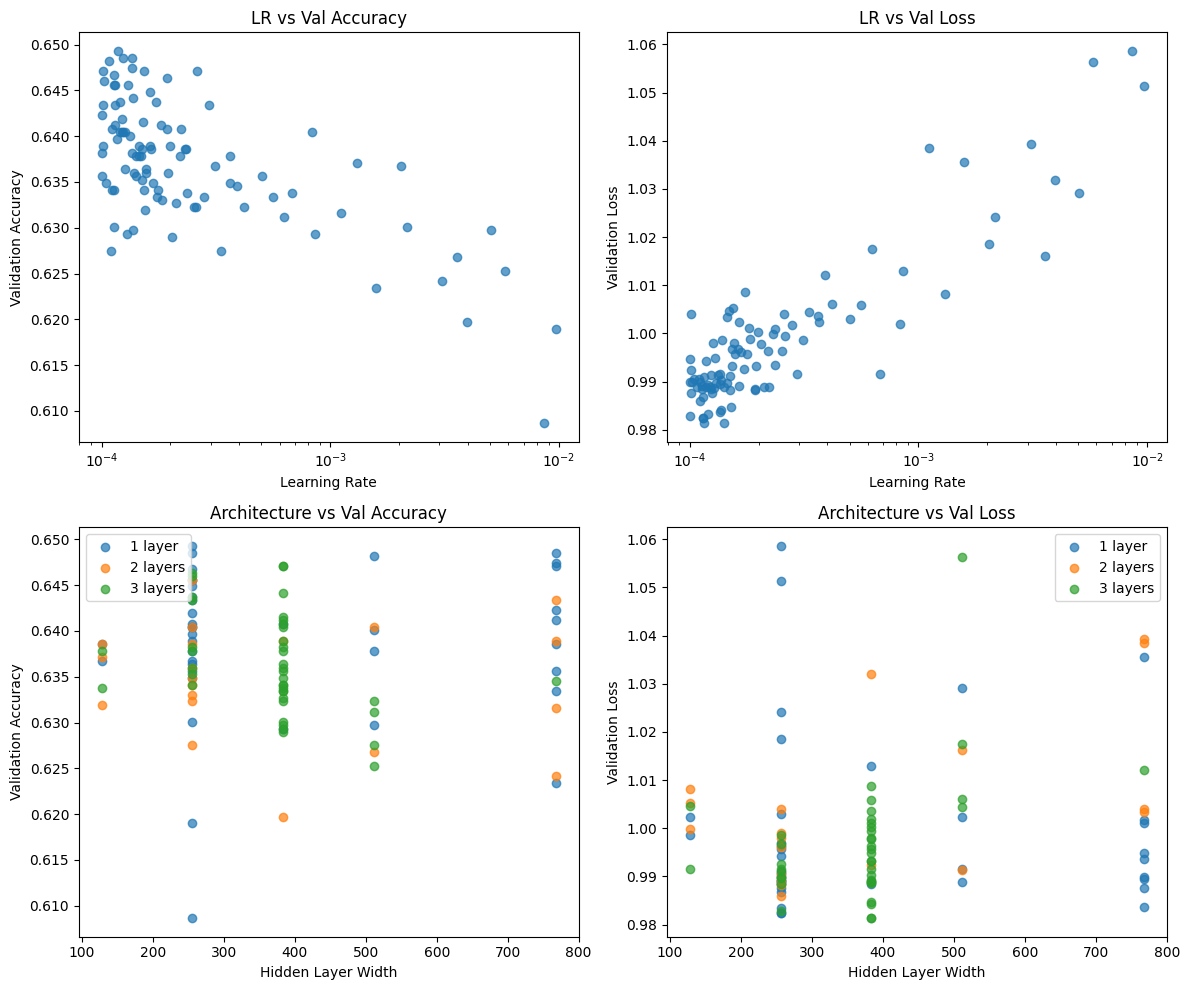

In [ ]:
import pathlib
import pandas as pd
import matplotlib.pyplot as plt

runs_dir = pathlib.Path("runs/asha")
study = search.study

# Aggregate
records = []
for trial in study.trials:
    trial_dir = runs_dir / f"trial_{trial.number:04d}"
    metrics_path = trial_dir / "metrics.csv"
    if not metrics_path.exists():
        continue
    metrics = pd.read_csv(metrics_path)
    best = metrics.loc[metrics["val_loss"].idxmin()]
    records.append({
        "trial": trial.number,
        "lr": trial.params.get("lr"),
        "hidden_width": trial.params.get("hidden_width"),
        "num_layers": trial.params.get("num_layers"),
        "val_loss": best["val_loss"],
        "val_acc": best["val_acc"],
        "trial": trial.number,
        "use_scheduler": trial.params.get("use_scheduler"),
        "batch_size": trial.params.get("batch_size"),
    })

df = pd.DataFrame(records)

# grid of plots
fig, axes = plt.subplots(2, 2, figsize=(12, 10))

# Learning Rate vs Validation Accuracy
ax = axes[0, 0]
ax.scatter(df["lr"], df["val_acc"], alpha=0.7)
ax.set_xscale("log")
ax.set_xlabel("Learning Rate")
ax.set_ylabel("Validation Accuracy")
ax.set_title("LR vs Val Accuracy")

# Learning Rate vs Validation Loss
ax = axes[0, 1]
ax.scatter(df["lr"], df["val_loss"], alpha=0.7)
ax.set_xscale("log")
ax.set_xlabel("Learning Rate")
ax.set_ylabel("Validation Loss")
ax.set_title("LR vs Val Loss")

# Hidden Width vs Validation Accuracy (per layers)
ax = axes[1, 0]
for nl in sorted(df["num_layers"].unique()):
    subset = df[df["num_layers"] == nl]
    ax.scatter(
        subset["hidden_width"],
        subset["val_acc"],
        label=f"{nl} layer{'s' if nl > 1 else ''}",
        alpha=0.7,
    )
ax.set_xlabel("Hidden Layer Width")
ax.set_ylabel("Validation Accuracy")
ax.set_title("Architecture vs Val Accuracy")
ax.legend()

# Hidden Width vs Validation Loss (per layers)
ax = axes[1, 1]
for nl in sorted(df["num_layers"].unique()):
    subset = df[df["num_layers"] == nl]
    ax.scatter(
        subset["hidden_width"],
        subset["val_loss"],
        label=f"{nl} layer{'s' if nl > 1 else ''}",
        alpha=0.7,
    )
ax.set_xlabel("Hidden Layer Width")
ax.set_ylabel("Validation Loss")
ax.set_title("Architecture vs Val Loss")
ax.legend()

fig.tight_layout()
plt.show()


We can see in the upper plots that smaller learning rates lead to better general performance but also more variance in that performance. On the other hand, we can see that 3 layer deep architectures with 384 neurons lead to the lowest validation loss values. 1 layer architectures with 256 or 768 neurons also peak for best accuracies. However, those architectures also show big variance in their values.

3. Briefly discuss your findings for batch size and the impact of the LR
scheduler.

In [54]:
import pandas as pd
from scipy.stats import ttest_ind
import itertools

# 1. Summary statistics
batch_stats = df.groupby("batch_size")[["val_acc", "val_loss"]].agg(['mean', 'std']).reset_index()
scheduler_stats = df.groupby("use_scheduler")[["val_acc", "val_loss"]].agg(['mean', 'std']).reset_index()

print("\nAverage metrics by batch size (mean ± std):")
print(batch_stats.to_string(index=False))

print("\nAverage metrics by scheduler usage (mean ± std):")
print(scheduler_stats.to_string(index=False))

# 2. T-test: scheduler vs no scheduler
acc_sched = df[df["use_scheduler"] == True]["val_acc"]
acc_nosched = df[df["use_scheduler"] == False]["val_acc"]
loss_sched = df[df["use_scheduler"] == True]["val_loss"]
loss_nosched = df[df["use_scheduler"] == False]["val_loss"]

t_acc_s, p_acc_s = ttest_ind(acc_sched, acc_nosched, equal_var=False)
t_loss_s, p_loss_s = ttest_ind(loss_sched, loss_nosched, equal_var=False)

print(f"\nT-test (val_acc) scheduler vs no scheduler: t = {t_acc_s:.3f}, p = {p_acc_s:.3f}")
print(f"T-test (val_loss) scheduler vs no scheduler: t = {t_loss_s:.3f}, p = {p_loss_s:.3f}")

# 3. T-tests between batch sizes
batch_sizes = sorted(df["batch_size"].unique())
for b1, b2 in itertools.combinations(batch_sizes, 2):
    acc1 = df[df["batch_size"] == b1]["val_acc"]
    acc2 = df[df["batch_size"] == b2]["val_acc"]
    loss1 = df[df["batch_size"] == b1]["val_loss"]
    loss2 = df[df["batch_size"] == b2]["val_loss"]
    
    t_acc, p_acc = ttest_ind(acc1, acc2, equal_var=False)
    t_loss, p_loss = ttest_ind(loss1, loss2, equal_var=False)
    
    print(f"\nBatch size {b1} vs {b2} (val_acc): t = {t_acc:.3f}, p = {p_acc:.3f}")
    print(f"Batch size {b1} vs {b2} (val_loss): t = {t_loss:.3f}, p = {p_loss:.3f}")



Average metrics by batch size (mean ± std):
batch_size  val_acc          val_loss         
               mean      std     mean      std
        32 0.637579 0.007565 0.996475 0.015176
        64 0.635563 0.004106 1.004815 0.011520
       128 0.635927 0.006704 1.003427 0.018106

Average metrics by scheduler usage (mean ± std):
use_scheduler  val_acc          val_loss         
                  mean      std     mean      std
        False 0.637497 0.007183 0.996714 0.015086
         True 0.635403 0.006524 1.005881 0.016012

T-test (val_acc) scheduler vs no scheduler: t = -1.354, p = 0.182
T-test (val_loss) scheduler vs no scheduler: t = 2.515, p = 0.016

Batch size 32 vs 64 (val_acc): t = 1.337, p = 0.192
Batch size 32 vs 64 (val_loss): t = -2.186, p = 0.042

Batch size 32 vs 128 (val_acc): t = 0.968, p = 0.339
Batch size 32 vs 128 (val_loss): t = -1.621, p = 0.115

Batch size 64 vs 128 (val_acc): t = -0.196, p = 0.846
Batch size 64 vs 128 (val_loss): t = 0.272, p = 0.787


These 2 hyperparameters are not the most influential ones, but given that they are discrete, it is easy to assess and compare them numerically. 

If we set an $\alpha$ of 0.05 we can see that using a scheduler does not improve validation model accuracy significantly and actually increases validation model loss. This might due to the fact that most data-points lie around smaller learning rate values where having a learning rate scheduler doesn't give any advantages or can make learning too slow or even stop it.

With the same alpha value, we can see that batch size does not provide any significant changes in accuracy or loss with one single exception when you compare a batch size of 64 with the batch size of 32, obtaining a lower loss with the latter.


4. Present your final chosen hyper-parameters for the DinoV2+MLP approach
in a table and justify why you believe this set is optimal or near-optimal
based on your experiments.

In [ ]:
import pandas as pd
import json

# Load the best trial
summary_path = "runs/asha/study_summary.json"
with open(summary_path, "r") as f:
    summary = json.load(f)

# Extract hyper-parameters
best_params = summary["params"]
best_params["best_val_loss"] = summary.get("best_val_loss", None)
best_params["trial_number"] = summary.get("trial_number", None)

df_best = pd.DataFrame([best_params])
print(df_best.to_markdown(index=False))


|          lr |   num_layers |   hidden_width |   batch_size | use_scheduler   |   best_val_loss |   trial_number |
|------------:|-------------:|---------------:|-------------:|:----------------|----------------:|---------------:|
| 0.000114988 |            3 |            384 |           32 | False           |        0.981338 |             82 |


The finding inferred from the graphs and metrics provided by the last 2 points support the model selected by the ASHA algorithm.
- 1) The final learning rate lies around the zone of values where most dots are located (and also the best performing ones). 
- 2) The layers of size 384 appear in the graph as the ones that achieve the best performing range. In that specific region most dots are green, representing 3 layers
- 3) For the batch size and the scheduler, the resulting parameters are coincidental with the ones with the best mean values. However there is not enough statistical power for statistical significancy. Future studies are needed with no trials and computing power.
In general terms the winning trial is consistent with the findings.